(Optional) downsampling script

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707", "split")

Load the aggregated user load data

In [4]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
aggregate_load_segments_train, aggregate_load_df_train = load_split_data_from_folder(dataset_folder_path, 'train')
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test')
aggregate_load_segments_val, aggregate_load_df_val = load_split_data_from_folder(dataset_folder_path, 'val')

In [6]:
# break the segments into per-day segments
def break_segments_into_days(segments):
    """Break segments into per-day segments"""
    daily_segments = []
    for start, end in segments:
        current = start
        while current < end:
            next_day = current + timedelta(days=1) - timedelta(milliseconds=1)
            daily_segments.append((current, min(next_day, end)))
            current = next_day + timedelta(milliseconds=1)
    return daily_segments

daily_segments_train = break_segments_into_days(aggregate_load_segments_train)
daily_segments_test = break_segments_into_days(aggregate_load_segments_test)
daily_segments_val = break_segments_into_days(aggregate_load_segments_val)

In [7]:
# extract the daily aggregate load data from the dataframe
def create_24_hour_sequences(aggregate_load_df, segments):
    """Create 24-hour sequences from aggregate load data"""
    sequences = []
    for start, end in segments:
        day_data = aggregate_load_df[(aggregate_load_df['datetime'] >= start) & (aggregate_load_df['datetime'] <= end)]

        # only keep the timestamp, aggregate, datetime columns
        day_data = day_data[['timestamp', 'aggregate', 'datetime']]

        if not day_data.empty:
            sequences.append(day_data)
    return sequences

daily_sequences_train = create_24_hour_sequences(aggregate_load_df_train, daily_segments_train)
daily_sequences_test = create_24_hour_sequences(aggregate_load_df_test, daily_segments_test)
daily_sequences_val = create_24_hour_sequences(aggregate_load_df_val, daily_segments_val)

Load the signatures from split folder

In [8]:
def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [11]:
signatures_df_train, ranges_train = {}, {}
signatures_df_test, ranges_test = {}, {}
signatures_df_val, ranges_val = {}, {}

# Load signatures for each split
for split_type in ['train', 'test', 'val']:
    sig_lib_folder = dataset_folder_path / 'load_signature_library'
    if sig_lib_folder.exists():
        train_appliances = [d.name for d in (sig_lib_folder / split_type).iterdir() if d.is_dir()]

    print(f"\n{'='*40}"); print(f"Loading signatures for split: {split_type}"); print(f"{'='*40}")

    for appliance in train_appliances:
        print(f"\n{appliance.upper()}:")
        signatures_df, ranges = load_signatures_from_split_folder(dataset_folder_path, split_type, appliance)
        print(f"  {split_type}: {len(signatures_df)} signatures, {len(ranges)} ranges")
        if split_type == 'train':
            signatures_df_train[appliance] = signatures_df
            ranges_train[appliance] = ranges
        elif split_type == 'test':
            signatures_df_test[appliance] = signatures_df
            ranges_test[appliance] = ranges
        elif split_type == 'val':
            signatures_df_val[appliance] = signatures_df
            ranges_val[appliance] = ranges


Loading signatures for split: train

DISHWASHER:
  train: 68972 signatures, 7 ranges

WASHING_MACHINE:
  train: 133667 signatures, 15 ranges

KETTLE:
  train: 132057 signatures, 42 ranges

MICROWAVE:
  train: 115434 signatures, 29 ranges

TV:
  train: 254514 signatures, 49 ranges

GAS_OVEN:
  train: 51558 signatures, 0 ranges

FRIDGE:
  train: 1690909 signatures, 2339 ranges

HTPC:
  train: 565841 signatures, 107 ranges

TOASTER:
  train: 94760 signatures, 28 ranges

KITCHEN_LIGHTS:
  train: 394499 signatures, 181 ranges

Loading signatures for split: test

DISHWASHER:
  test: 36394 signatures, 3 ranges

WASHING_MACHINE:
  test: 64781 signatures, 7 ranges

KETTLE:
  test: 72680 signatures, 23 ranges

MICROWAVE:
  test: 59751 signatures, 19 ranges

TV:
  test: 144164 signatures, 23 ranges

GAS_OVEN:
  test: 25049 signatures, 0 ranges

FRIDGE:
  test: 839669 signatures, 1171 ranges

HTPC:
  test: 301969 signatures, 69 ranges

TOASTER:
  test: 53382 signatures, 14 ranges

KITCHEN_LIGHTS:

In [12]:
signatures_df_train['dishwasher']

index     timestamp  dishwasher
0        92646  1.357682e+09         0.0
1        92647  1.357682e+09         0.0
2        92648  1.357682e+09         0.0
3        92649  1.357682e+09         0.0
4        92650  1.357682e+09         0.0
...        ...           ...         ...
68967  4301711  1.388201e+09         0.0
68968  4301712  1.388201e+09         0.0
68969  4301713  1.388201e+09         0.0
68970  4301714  1.388201e+09         0.0
68971  4301715  1.388201e+09         0.0

[68972 rows x 3 columns]

In [17]:
ranges_train['dishwasher']

[(0, 17),
 (14916, 16067),
 (31747, 32919),
 (44694, 45866),
 (46693, 46898),
 (64824, 65999),
 (66884, 67089)]

---

In [18]:
# Downsampling with user-selectable low-pass filter (LPF) and alignment to original data, avoiding linear interpolation
import numpy as np
import pandas as pd
from scipy.signal import firwin, bessel, lfilter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

# --- Sample User options ---
# filter_type = 'fir'  # Options: 'fir', 'butter', 'cheby1', 'cheby2', 'ellip', 'bessel'
# filter_order = 6   # For FIR, must be odd; for IIR, typical 4-8

cutoff_hz = 1/60     # 1/minute, Nyquist = 1/6 Hz, so cutoff < 1/12 Hz
zero_phase = True    # Use filtfilt (zero-phase) or lfilter (causal)
down_ratio = 10      # Downsample from 1/6 Hz to 1/60 Hz (1 min)

# --- Helper: Design filter ---
def design_lpf(filter_type, order, cutoff, fs, kwargs=None):
    """
    Design a low-pass filter of the given type.
    kwargs: dictionary of extra arguments to pass to the filter design function.
    """
    if kwargs is None:
        kwargs = {}
    if filter_type == 'fir':
        # Allow user to specify window, passband, etc.
        window = kwargs.get('window', 'hamming')
        pass_zero = kwargs.get('pass_zero', True)
        taps = firwin(order, cutoff/(fs/2), window=window, pass_zero=pass_zero, **{k: v for k, v in kwargs.items() if k not in ['window', 'pass_zero']})
        return taps, [1.0]
    elif filter_type == 'bessel':
        norm = kwargs.get('norm', 'phase')
        b, a = bessel(order, cutoff/(fs/2), btype='low', norm=norm, **{k: v for k, v in kwargs.items() if k != 'norm'})
        return b, a
    else:
        raise ValueError(f'Unknown filter type \"{filter_type}\". Supported types: fir, bessel.')

def downsample_with_lpf(
    selected_indices, 
    daily_sequences, 
    filter_type='fir', 
    filter_order=7, 
    cutoff_hz=1/60, 
    zero_phase=True, 
    down_ratio=10, 
    fs=1/6,
    filter_kwargs=None
):
    """
    Downsample daily_sequences at selected_indices using a user-selectable low-pass filter.
    filter_kwargs: dictionary of extra arguments to pass to the filter design function.
    Returns:
        uniform_aggregate_sequences: dict of idx -> uniform aggregate np.ndarray
        resampled_sequences_lpf: dict of idx -> DataFrame with columns ['datetime', 'aggregate', 'timestamp']
    """
    uniform_aggregate_sequences = {}
    filtered_seqs = {}
    resampled_sequences_lpf = {}

    for idx in selected_indices:
        sequence = daily_sequences[idx].copy()
        # Create a uniform 6s grid covering the original data
        start_time = sequence['datetime'].iloc[0]
        end_time = sequence['datetime'].iloc[-1]
        uniform_times = pd.date_range(start=start_time, end=end_time, freq='6s')
        # Use nearest-neighbor reindexing to avoid interpolation
        sequence_nn = sequence.set_index('datetime').reindex(uniform_times, method='nearest').reset_index()
        sequence_nn.rename(columns={'index': 'datetime'}, inplace=True)
        uniform_aggregate = sequence_nn['aggregate'].values
        uniform_aggregate_sequences[idx] = uniform_aggregate

        # Design filter
        b, a = design_lpf(filter_type, filter_order, cutoff_hz, fs, kwargs=filter_kwargs)
        # Apply filter
        if zero_phase:
            filtered = filtfilt(b, a, uniform_aggregate)
        else:
            filtered = lfilter(b, a, uniform_aggregate)

        filtered_seqs[idx] = filtered

        # Downsample
        resampled_sequence = filtered[::down_ratio]
        resampled_times = uniform_times[::down_ratio][:len(resampled_sequence)]
        resampled_df = pd.DataFrame({
            'datetime': resampled_times,
            'aggregate': resampled_sequence,
            'timestamp': resampled_times.astype(np.int64) // 10**9
        })
        resampled_sequences_lpf[idx] = resampled_df

    return uniform_aggregate_sequences, filtered_seqs, resampled_sequences_lpf



In [ ]:
# Configure downsampling parameters
filter_type = 'fir'  # Using FIR filter for best results
filter_order = 19    # Higher order for better frequency response
down_ratio = 10      # From 1/6 Hz to 1/60 Hz (1 sample per minute)
downsampled_rate = "1min"  # For folder naming

print(f"Downsampling configuration:")
print(f"  Filter type: {filter_type}")
print(f"  Filter order: {filter_order}")
print(f"  Down ratio: {down_ratio}")
print(f"  Target rate: {downsampled_rate}")

# Create output directory
output_folder = Path("dataset", f"20250707_downsampled_{downsampled_rate}")
output_folder.mkdir(parents=True)

print(f"\nOutput folder: {output_folder}")

Downsampling configuration:
  Filter type: fir
  Filter order: 19
  Down ratio: 10
  Target rate: 1min

Output folder: dataset/20250707_downsampled_1min


In [15]:
def downsample_aggregate_data(daily_sequences, split_name):
    """
    Downsample aggregate load data for a specific split (train/val/test)
    
    Parameters:
    - daily_sequences: list of daily sequence DataFrames
    - split_name: name of the split for logging
    
    Returns:
    - downsampled_sequences: dict mapping sequence index to downsampled DataFrame
    """
    print(f"Downsampling {split_name} aggregate data...")
    print(f"  Total sequences: {len(daily_sequences)}")
    
    # Use all sequences for downsampling
    sequence_indices = list(range(len(daily_sequences)))
    
    # Apply downsampling function
    uniform_aggregate_sequences, filtered_seqs, downsampled_sequences = downsample_with_lpf(
        sequence_indices,
        daily_sequences,
        filter_type=filter_type,
        filter_order=filter_order,
        cutoff_hz=cutoff_hz,
        zero_phase=zero_phase,
        down_ratio=down_ratio,
        fs=1/6
    )
    
    print(f"  Downsampled {len(downsampled_sequences)} sequences")
    
    # Convert back to list format
    downsampled_list = []
    for i in range(len(daily_sequences)):
        if i in downsampled_sequences:
            downsampled_list.append(downsampled_sequences[i])
        else:
            # Handle empty sequences
            downsampled_list.append(pd.DataFrame(columns=['datetime', 'aggregate', 'timestamp']))
    
    return downsampled_list, uniform_aggregate_sequences, filtered_seqs

# Downsample all splits
print("=" * 60)
print("DOWNSAMPLING AGGREGATE DATA")
print("=" * 60)

downsampled_train, uniform_train, filtered_train = downsample_aggregate_data(daily_sequences_train, 'train')
downsampled_val, uniform_val, filtered_val = downsample_aggregate_data(daily_sequences_val, 'val')
downsampled_test, uniform_test, filtered_test = downsample_aggregate_data(daily_sequences_test, 'test')

print(f"\nDownsampling complete!")
print(f"  Train: {len(downsampled_train)} sequences")
print(f"  Val: {len(downsampled_val)} sequences")
print(f"  Test: {len(downsampled_test)} sequences")

DOWNSAMPLING AGGREGATE DATA
Downsampling train aggregate data...
  Total sequences: 162
  Downsampled 162 sequences
Downsampling val aggregate data...
  Total sequences: 73
  Downsampled 73 sequences
Downsampling test aggregate data...
  Total sequences: 80
  Downsampled 80 sequences

Downsampling complete!
  Train: 162 sequences
  Val: 73 sequences
  Test: 80 sequences


In [36]:

def downsample_appliance_signatures(sequences, appliance_name, split_name):
    """
    Downsample appliance signature data for a specific split
    
    Parameters:
    - sequences: List of signature DataFrames
    - appliance_name: Name of the appliance
    - split_name: Name of the split
    
    Returns:
    - downsampled_sequences: List of downsampled DataFrames
    """
    print(f"    Downsampling {split_name} {appliance_name} signatures...")
    
    downsampled_sequences = []
    
    for i, signatures in enumerate(sequences):

        # rename the "index" column to "index_org" to avoid conflict in line
        # uniform_data = uniform_data.reset_index().rename(columns={'index': 'datetime'})
        signatures.rename(columns={'index': 'index_org'}, inplace=True)

        if signatures.empty:
            downsampled_sequences.append(signatures)
            continue
        
        # Create a uniform time grid for this day's signatures
        start_time = signatures['datetime'].iloc[0]
        end_time = signatures['datetime'].iloc[-1]
        
        # Create uniform 6-second intervals
        uniform_times = pd.date_range(start=start_time, end=end_time, freq='6s')
        
        if len(uniform_times) < 2:
            # Not enough data to downsample
            downsampled_sequences.append(signatures)
            continue
        
        # Reindex to uniform grid using nearest neighbor
        day_signatures_indexed = signatures.set_index('datetime')
        uniform_data = day_signatures_indexed.reindex(uniform_times, method='nearest')
        uniform_data = uniform_data.reset_index().rename(columns={'index': 'datetime'})
        
        # Apply downsampling filter to the main power column, which is named by the appliance's name
        if f'{appliance_name}' in uniform_data.columns:
            power_values = uniform_data[f'{appliance_name}'].fillna(0).values

            try:
                if len(power_values) >= down_ratio:
                    # Design and apply filter
                    b, a = design_lpf(filter_type, filter_order, cutoff_hz, 1/6)

                if zero_phase:
                    filtered_power = filtfilt(b, a, power_values)
                else:
                    filtered_power = lfilter(b, a, power_values)
                
                # Downsample
                downsampled_power = filtered_power[::down_ratio]
                downsampled_times = uniform_times[::down_ratio][:len(downsampled_power)]
                
                # Create downsampled DataFrame
                downsampled_df = pd.DataFrame({
                    'datetime': downsampled_times,
                    f'{appliance_name}': downsampled_power,
                    'timestamp': downsampled_times.astype(np.int64) // 10**9
                })
                
                # # Add other columns if they exist
                # for col in uniform_data.columns:
                #     if col not in ['datetime', f'{appliance_name}', 'timestamp']:
                #         # For non-power columns, use simple decimation
                #         downsampled_df[col] = uniform_data[col].iloc[::down_ratio][:len(downsampled_power)]
                
                downsampled_sequences.append(downsampled_df)
            except Exception as e:
                print(f"Error processing sequence {i} for {appliance_name}: {e}")
                # Append original signatures if filtering fails
                downsampled_sequences.append(signatures)
            
        else:
            print(f"Warning: '{appliance_name}' column not found in signatures for sequence {i}.")
            # No power column, just decimate
            decimated_data = uniform_data.iloc[::down_ratio]
            downsampled_df = pd.DataFrame({
                'datetime': decimated_data['datetime'],
                f'{appliance_name}': decimated_data[f'{appliance_name}'],
                'timestamp': decimated_data['datetime'].astype(np.int64) // 10**9
            })
            
            # Add other columns if they exist
            for col in uniform_data.columns:
                if col not in ['datetime', 'power', 'timestamp']:
                    downsampled_df[col] = uniform_data[col].iloc[::down_ratio][:len(downsampled_df)]
            
            downsampled_sequences.append(downsampled_df)
    
    non_empty_count = sum(1 for seq in downsampled_sequences if not seq.empty)
    print(f"    Processed {len(downsampled_sequences)} sequences ({non_empty_count} non-empty)")
    
    return downsampled_sequences

In [37]:
# Process all appliances for all splits
print("=" * 60)
print("PROCESSING APPLIANCE SIGNATURES")
print("=" * 60)

# Dictionary to store all downsampled signature data
downsampled_signatures = {
    'train': {},
    'val': {},
    'test': {}
}

# Dictionary to store original signature data for reference
original_signatures = {
    'train': {},
    'val': {},
    'test': {}
}

def split_signatures_into_sequences(signatures_df, ranges):
    """Split signatures into sequences based on index ranges from selected_ranges.txt"""
    sequences = []

    # create datetime column if not present
    if 'datetime' not in signatures_df.columns:
        signatures_df['datetime'] = pd.to_datetime(signatures_df['timestamp'], unit='s').dt.to_pydatetime()

    for start_idx, end_idx in ranges:
        # Extract signatures using index range
        sub_seq = signatures_df[(signatures_df.index >= start_idx) & (signatures_df.index <= end_idx)]

        if not sub_seq.empty:
            # # Ensure we have the required columns
            # if 'timestamp' not in sub_seq.columns:
            #     sub_seq['timestamp'] = sub_seq['datetime'].astype(np.int64) // 10**9
            
            # Sort by datetime for consistency
            sub_seq = sub_seq.sort_values('datetime').reset_index(drop=True)
            
        sequences.append(sub_seq)
    
    return sequences

# Process each appliance using the already loaded signature data
for appliance in train_appliances:
    print(f"\nProcessing {appliance}...")
    
    # Split signatures into sequences based on index ranges for each split
    train_sigs = split_signatures_into_sequences(signatures_df_train[appliance], ranges_train[appliance])
    val_sigs = split_signatures_into_sequences(signatures_df_val[appliance], ranges_val[appliance])
    test_sigs = split_signatures_into_sequences(signatures_df_test[appliance], ranges_test[appliance])

    # Store original signatures for reference
    original_signatures['train'][appliance] = (signatures_df_train[appliance], ranges_train[appliance])
    original_signatures['val'][appliance] = (signatures_df_val[appliance], ranges_val[appliance])
    original_signatures['test'][appliance] = (signatures_df_test[appliance], ranges_test[appliance])
    
    # Downsample signatures for each split
    downsampled_signatures['train'][appliance] = downsample_appliance_signatures(
        train_sigs, appliance, 'train'
    )
    downsampled_signatures['val'][appliance] = downsample_appliance_signatures(
        val_sigs, appliance, 'val'
    )
    downsampled_signatures['test'][appliance] = downsample_appliance_signatures(
        test_sigs, appliance, 'test'
    )

print(f"\nAppliance signature processing complete!")
print(f"Processed {len(train_appliances)} appliances for all splits")

PROCESSING APPLIANCE SIGNATURES

Processing dishwasher...
    Downsampling train dishwasher signatures...
Error processing sequence 0 for dishwasher: The length of the input vector x must be greater than padlen, which is 57.
    Processed 7 sequences (7 non-empty)
    Downsampling val dishwasher signatures...
    Processed 1 sequences (1 non-empty)
    Downsampling test dishwasher signatures...
    Processed 3 sequences (3 non-empty)

Processing washing_machine...
    Downsampling train washing_machine signatures...
    Processed 15 sequences (15 non-empty)
    Downsampling val washing_machine signatures...
    Processed 6 sequences (6 non-empty)
    Downsampling test washing_machine signatures...
Error processing sequence 0 for washing_machine: The length of the input vector x must be greater than padlen, which is 57.
    Processed 7 sequences (7 non-empty)

Processing kettle...
    Downsampling train kettle signatures...
    Processed 42 sequences (42 non-empty)
    Downsampling val 

In [38]:
downsampled_signatures['train']['dishwasher'][1]  # Show first 2 sequences for dishwasher

datetime  dishwasher   timestamp
0    2013-04-28 22:18:06  119.000000  1367187486
1    2013-04-28 22:19:06  118.106529  1367187546
2    2013-04-28 22:20:06  118.115971  1367187606
3    2013-04-28 22:21:06  119.076182  1367187666
4    2013-04-28 22:22:06  119.001550  1367187726
...                  ...         ...         ...
4317 2013-05-01 22:15:06  120.388074  1367446506
4318 2013-05-01 22:16:06  119.990290  1367446566
4319 2013-05-01 22:17:06  120.632326  1367446626
4320 2013-05-01 22:18:06  121.001896  1367446686
4321 2013-05-01 22:19:06  120.990767  1367446746

[4322 rows x 3 columns]

---

Visualization

In [39]:
# Copy plot function from EDA_downsampling.ipynb
import seaborn as sns
import matplotlib.pyplot as plt

def plot_sequences_2(original, resampled, filter_type, filter_order):
    """Plot original and resampled sequences with filter type and order"""
    plt.figure(figsize=(12, 6), dpi=300)
    sns.lineplot(x='datetime', y='aggregate', data=original, label='Original', color='blue')
    sns.lineplot(x='datetime', y='aggregate', data=resampled, label=f'Resampled ({filter_type})', color='pink')
    plt.title(f'Original vs Resampled Sequence (Filter: {filter_type}, Order: {filter_order})')
    plt.xlabel('Datetime')
    plt.ylabel('Aggregate Load')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_signature_comparison(original, resampled, appliance_name, filter_type, filter_order):
    """Plot original and resampled appliance signatures"""
    plt.figure(figsize=(12, 6), dpi=300)
    
    if not original.empty and 'power' in original.columns:
        sns.lineplot(x='datetime', y='power', data=original, label='Original', color='blue', alpha=0.7)
    
    if not resampled.empty and 'power' in resampled.columns:
        sns.lineplot(x='datetime', y='power', data=resampled, label=f'Resampled ({filter_type})', color='red', alpha=0.7)
    
    plt.title(f'{appliance_name} Signature: Original vs Resampled (Filter: {filter_type}, Order: {filter_order})')
    plt.xlabel('Datetime')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Sample data for visualization
print("=" * 60)
print("SAMPLING DATA FOR VISUALIZATION")
print("=" * 60)

# Sample 10 aggregate load sequences for visualization
np.random.seed(20250715)  # For reproducibility
sample_indices = {
    'train': np.random.choice(len(daily_sequences_train), size=min(10, len(daily_sequences_train)), replace=False),
    'val': np.random.choice(len(daily_sequences_val), size=min(5, len(daily_sequences_val)), replace=False),
    'test': np.random.choice(len(daily_sequences_test), size=min(5, len(daily_sequences_test)), replace=False)
}

print(f"Sampled indices for visualization:")
for split_name, indices in sample_indices.items():
    print(f"  {split_name}: {len(indices)} sequences - {list(indices)}")

SAMPLING DATA FOR VISUALIZATION
Sampled indices for visualization:
  train: 10 sequences - [143, 140, 157, 41, 134, 64, 107, 45, 82, 49]
  val: 5 sequences - [16, 51, 26, 11, 66]
  test: 5 sequences - [14, 43, 33, 5, 11]


VISUALIZING AGGREGATE LOAD DATA COMPARISON
Train Split Aggregate Load Comparison:

Sample 1 (Index 143):


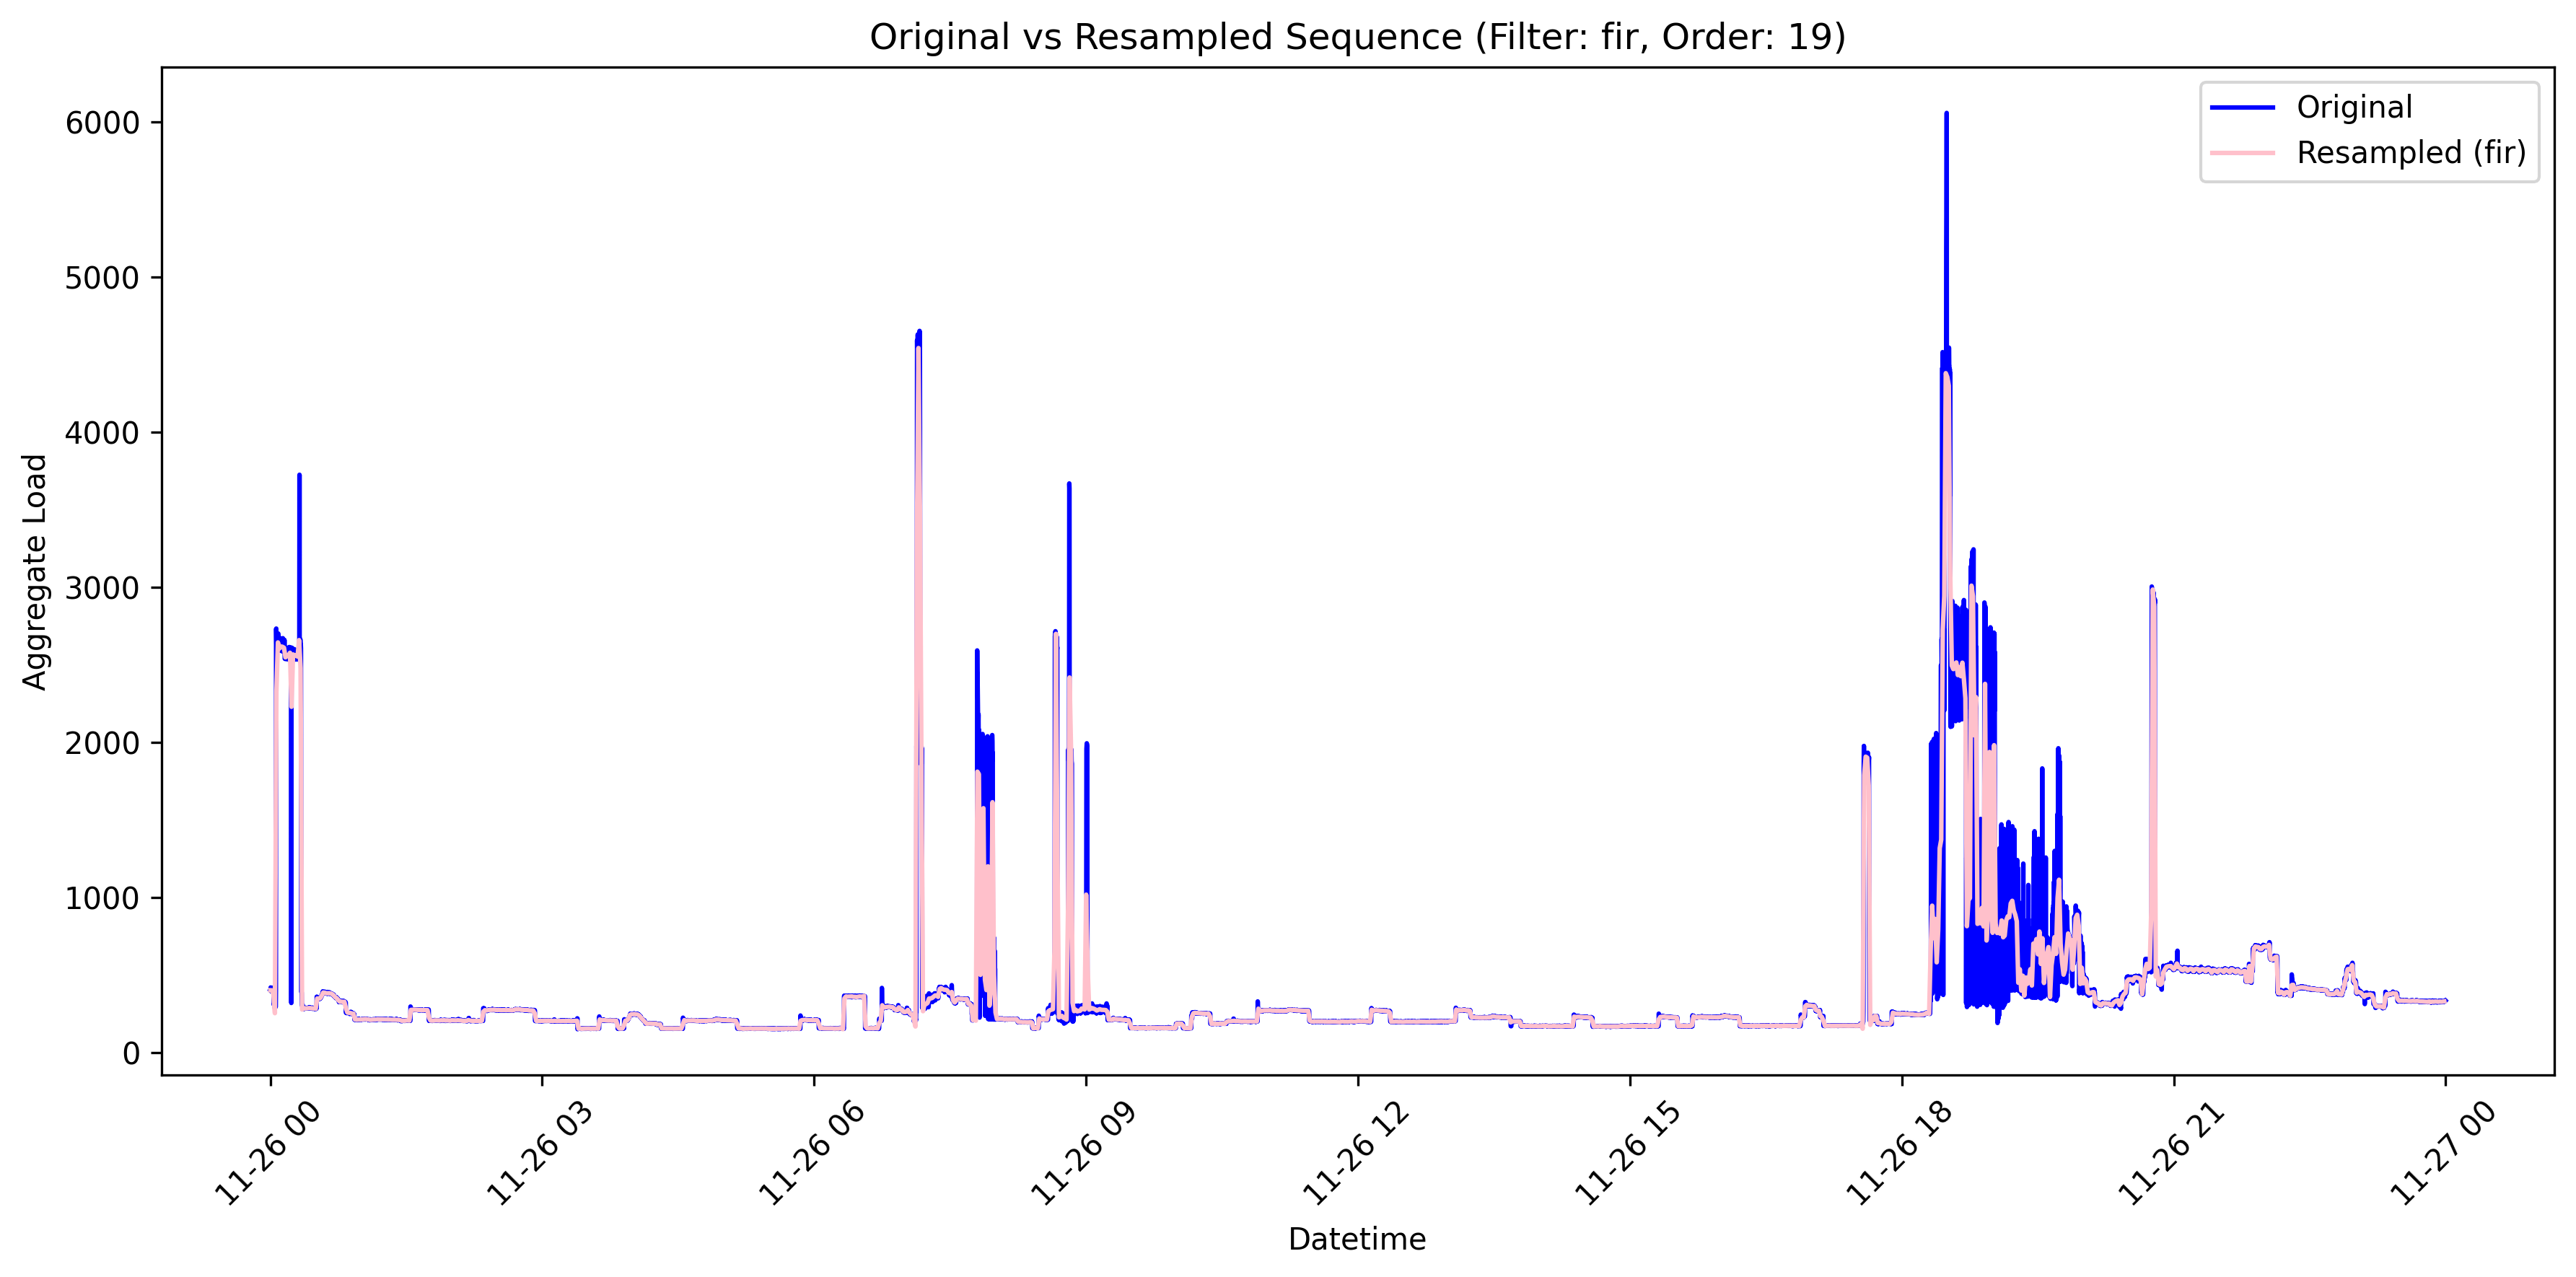

  Original points: 13887
  Downsampled points: 1440
  Compression ratio: 9.6x
  Original time range: 2013-11-26 00:00:05+00:00 to 2013-11-26 23:59:56+00:00
  Downsampled time range: 2013-11-26 00:00:05+00:00 to 2013-11-26 23:59:05+00:00

Sample 2 (Index 140):


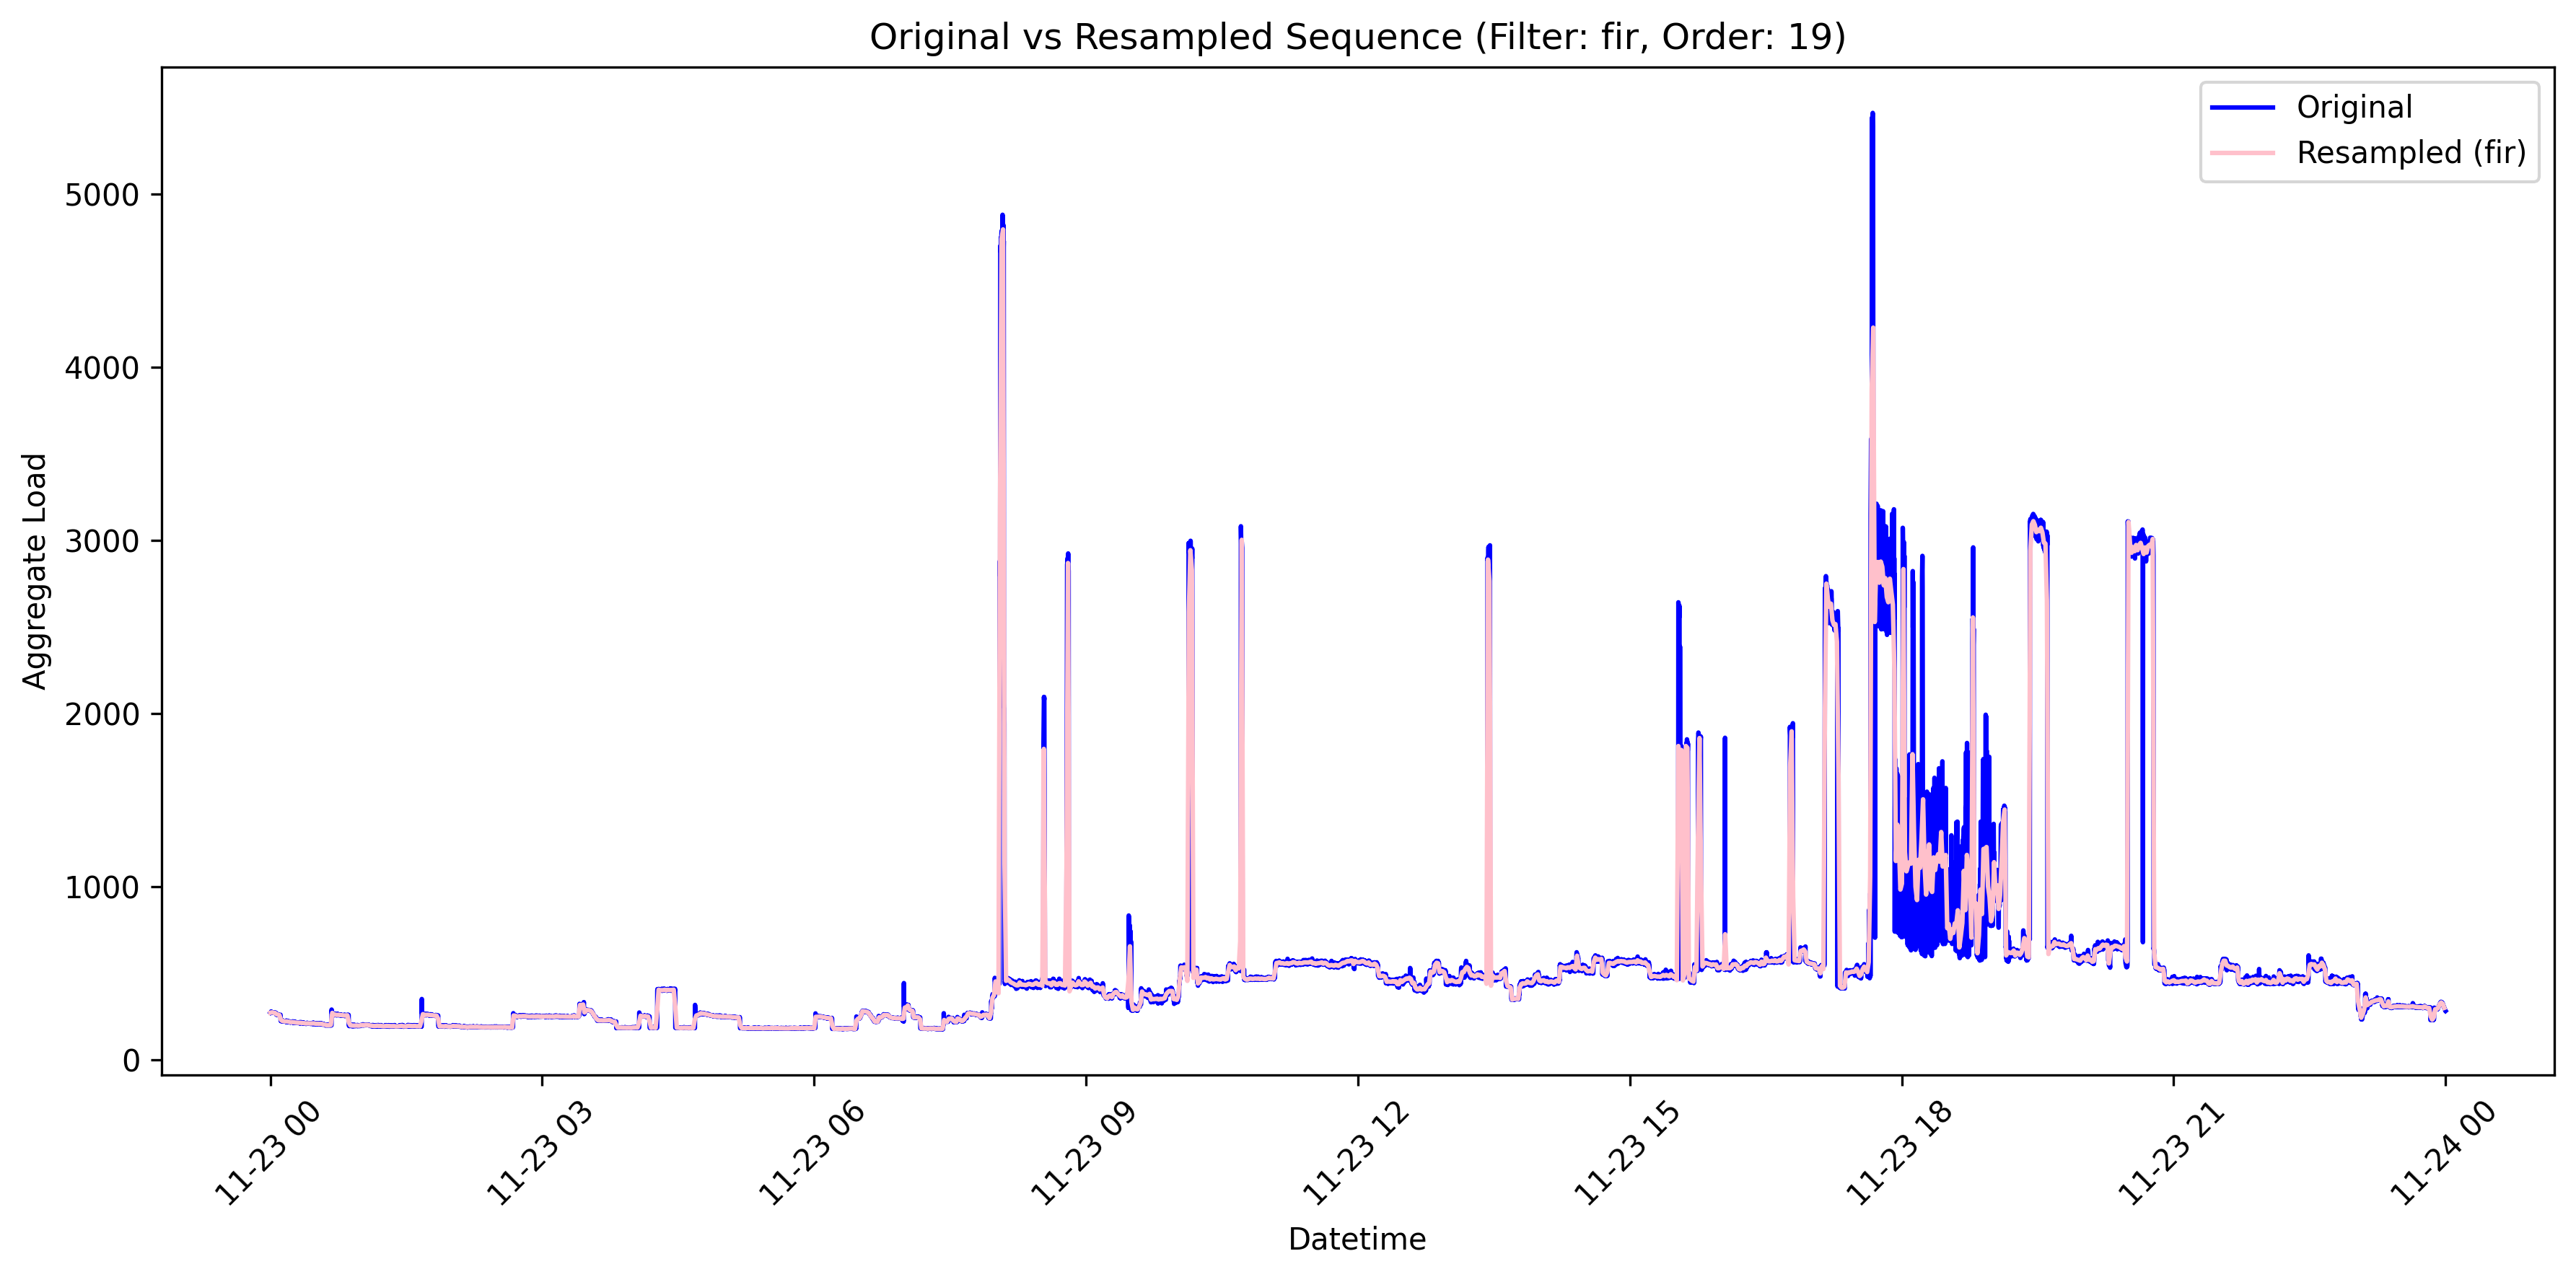

  Original points: 13604
  Downsampled points: 1440
  Compression ratio: 9.4x
  Original time range: 2013-11-23 00:00:05+00:00 to 2013-11-23 23:59:58+00:00
  Downsampled time range: 2013-11-23 00:00:05+00:00 to 2013-11-23 23:59:05+00:00

Sample 3 (Index 157):


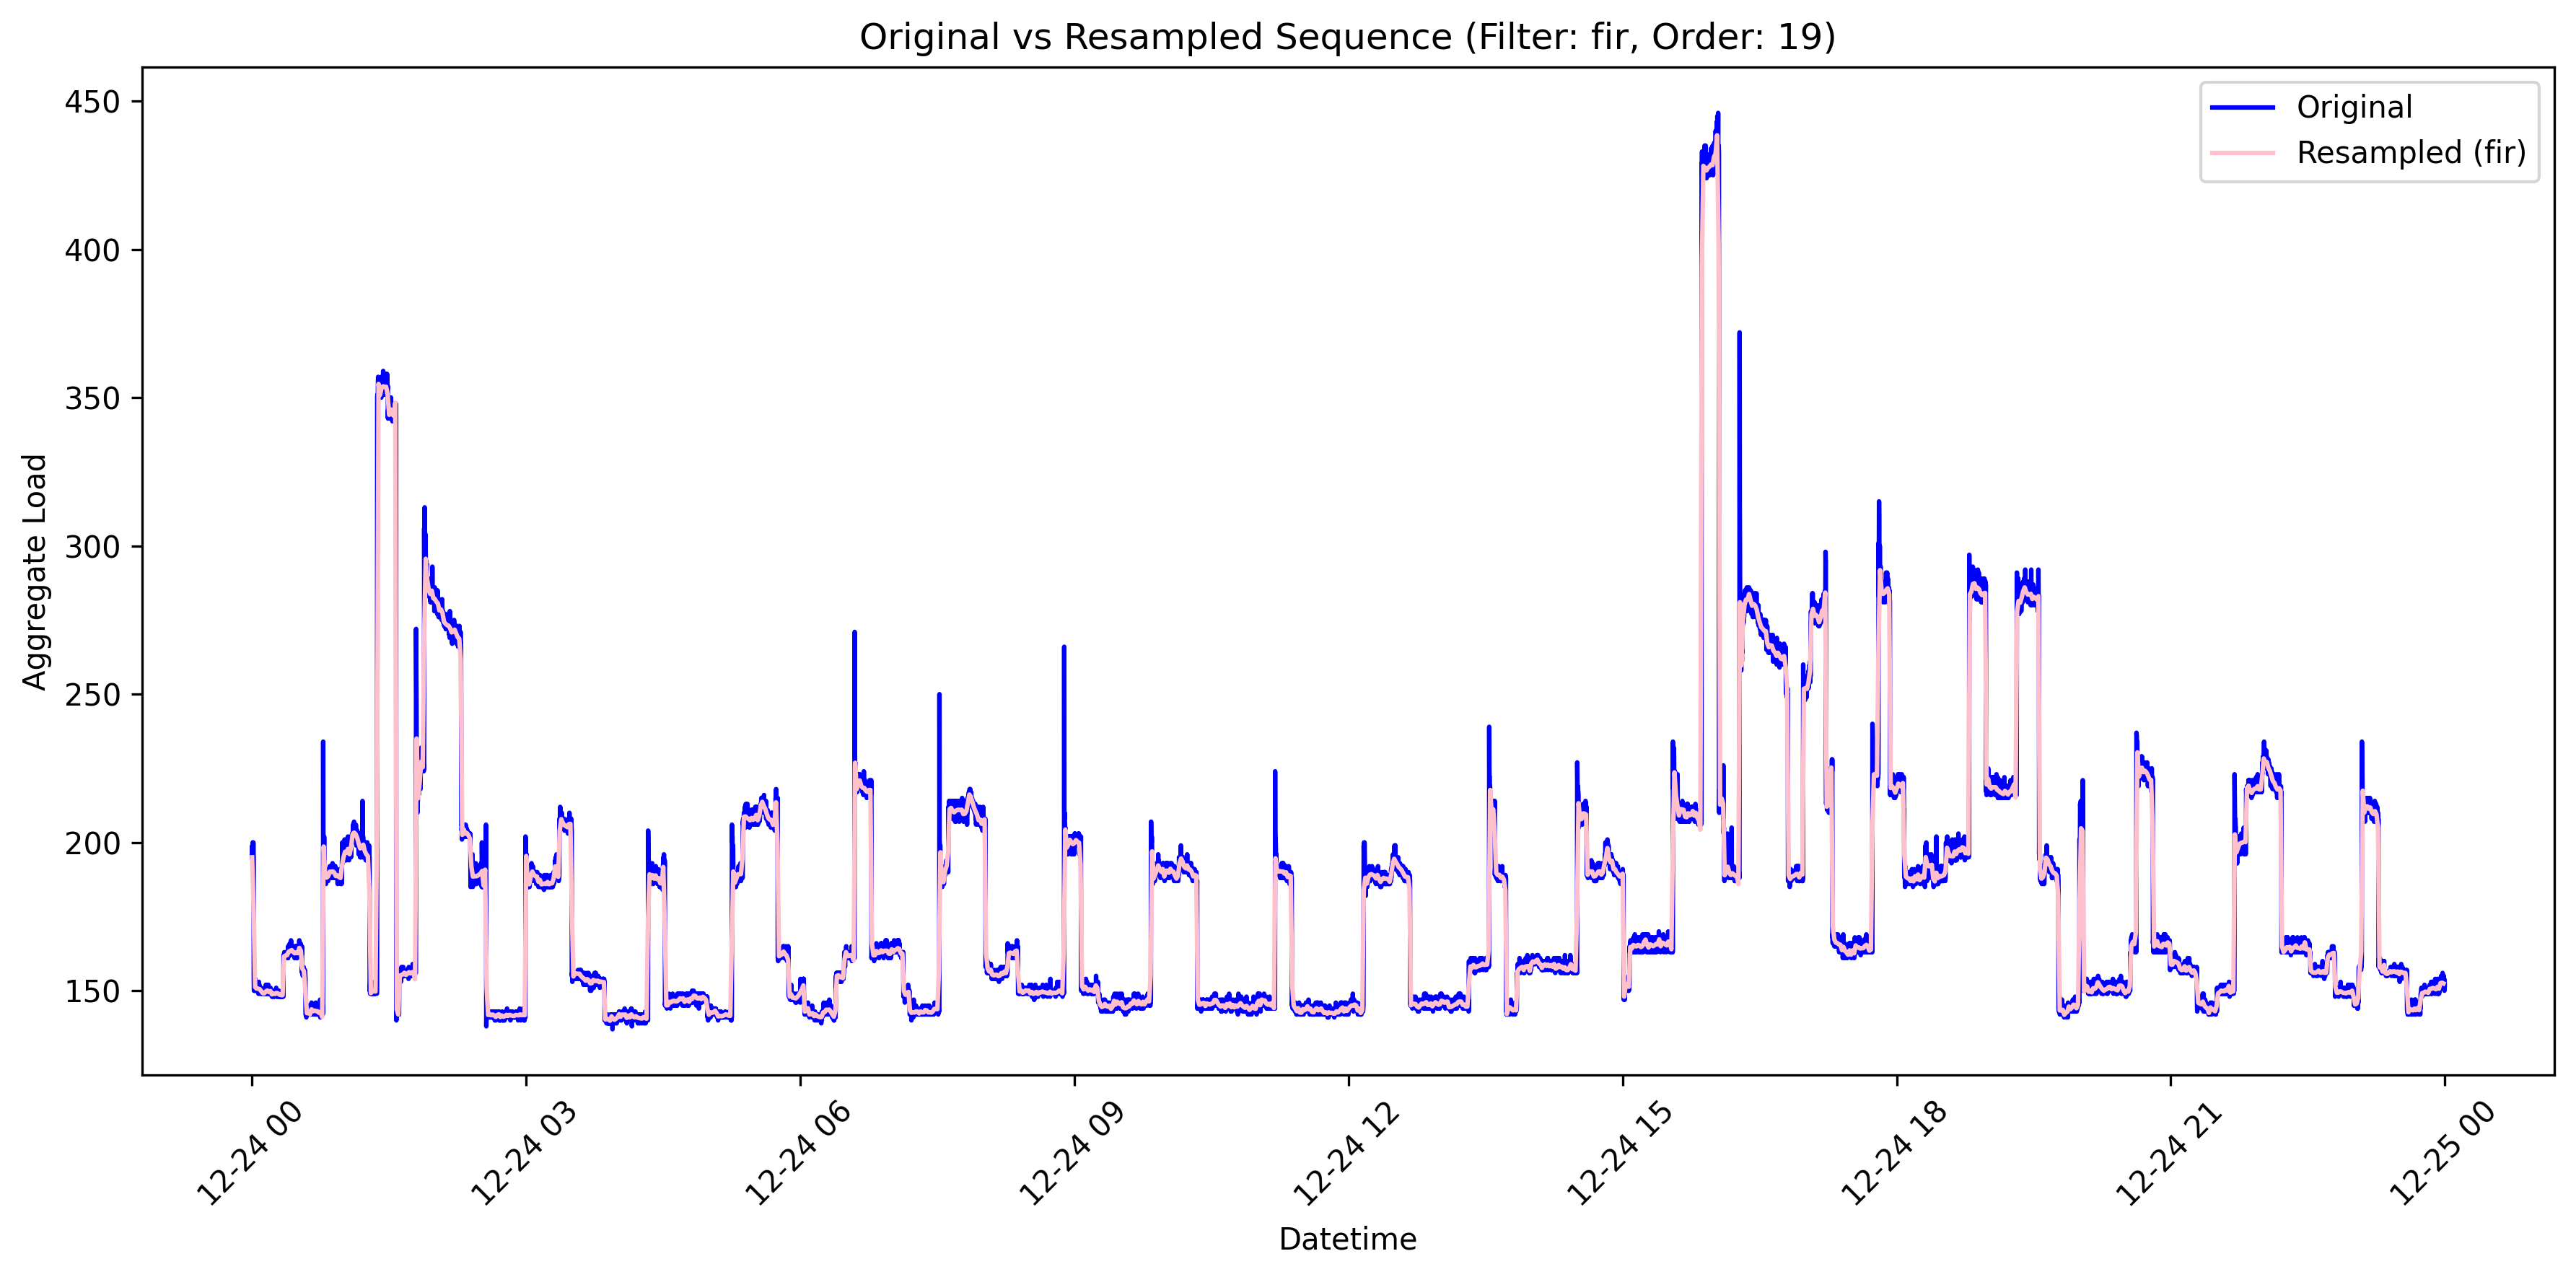

  Original points: 14298
  Downsampled points: 1440
  Compression ratio: 9.9x
  Original time range: 2013-12-24 00:00:05+00:00 to 2013-12-24 23:59:54+00:00
  Downsampled time range: 2013-12-24 00:00:05+00:00 to 2013-12-24 23:59:05+00:00

Sample 4 (Index 41):


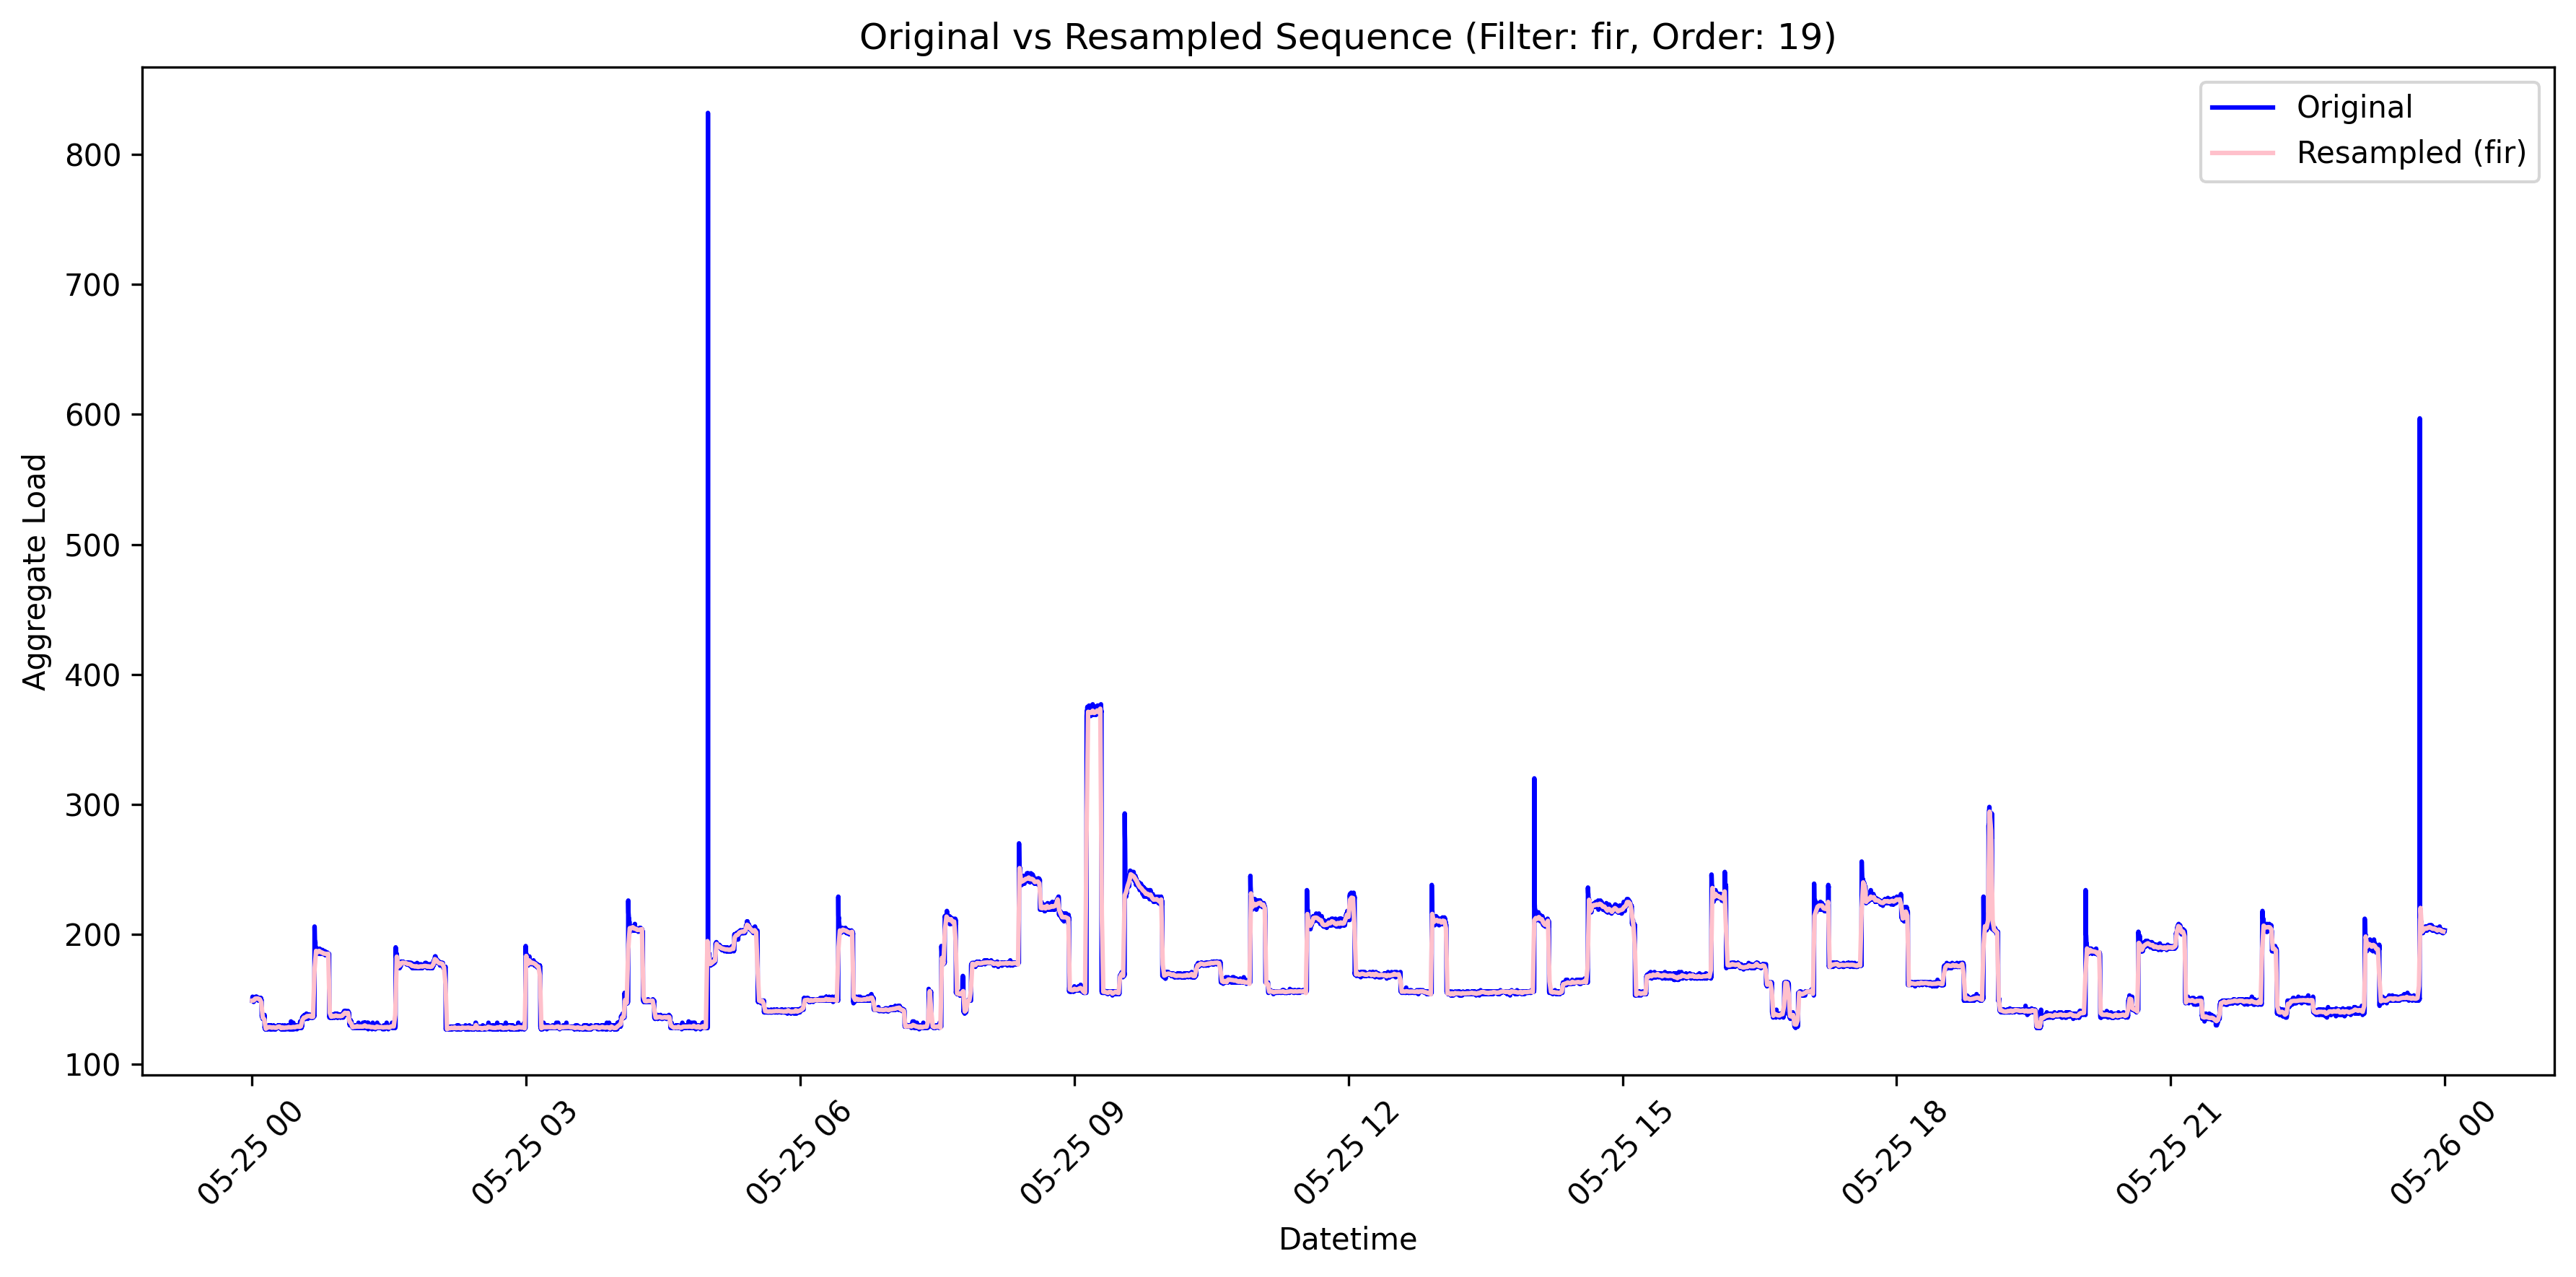

  Original points: 14239
  Downsampled points: 1440
  Compression ratio: 9.9x
  Original time range: 2013-05-25 00:00:03+00:00 to 2013-05-25 23:59:57+00:00
  Downsampled time range: 2013-05-25 00:00:03+00:00 to 2013-05-25 23:59:03+00:00

Sample 5 (Index 134):


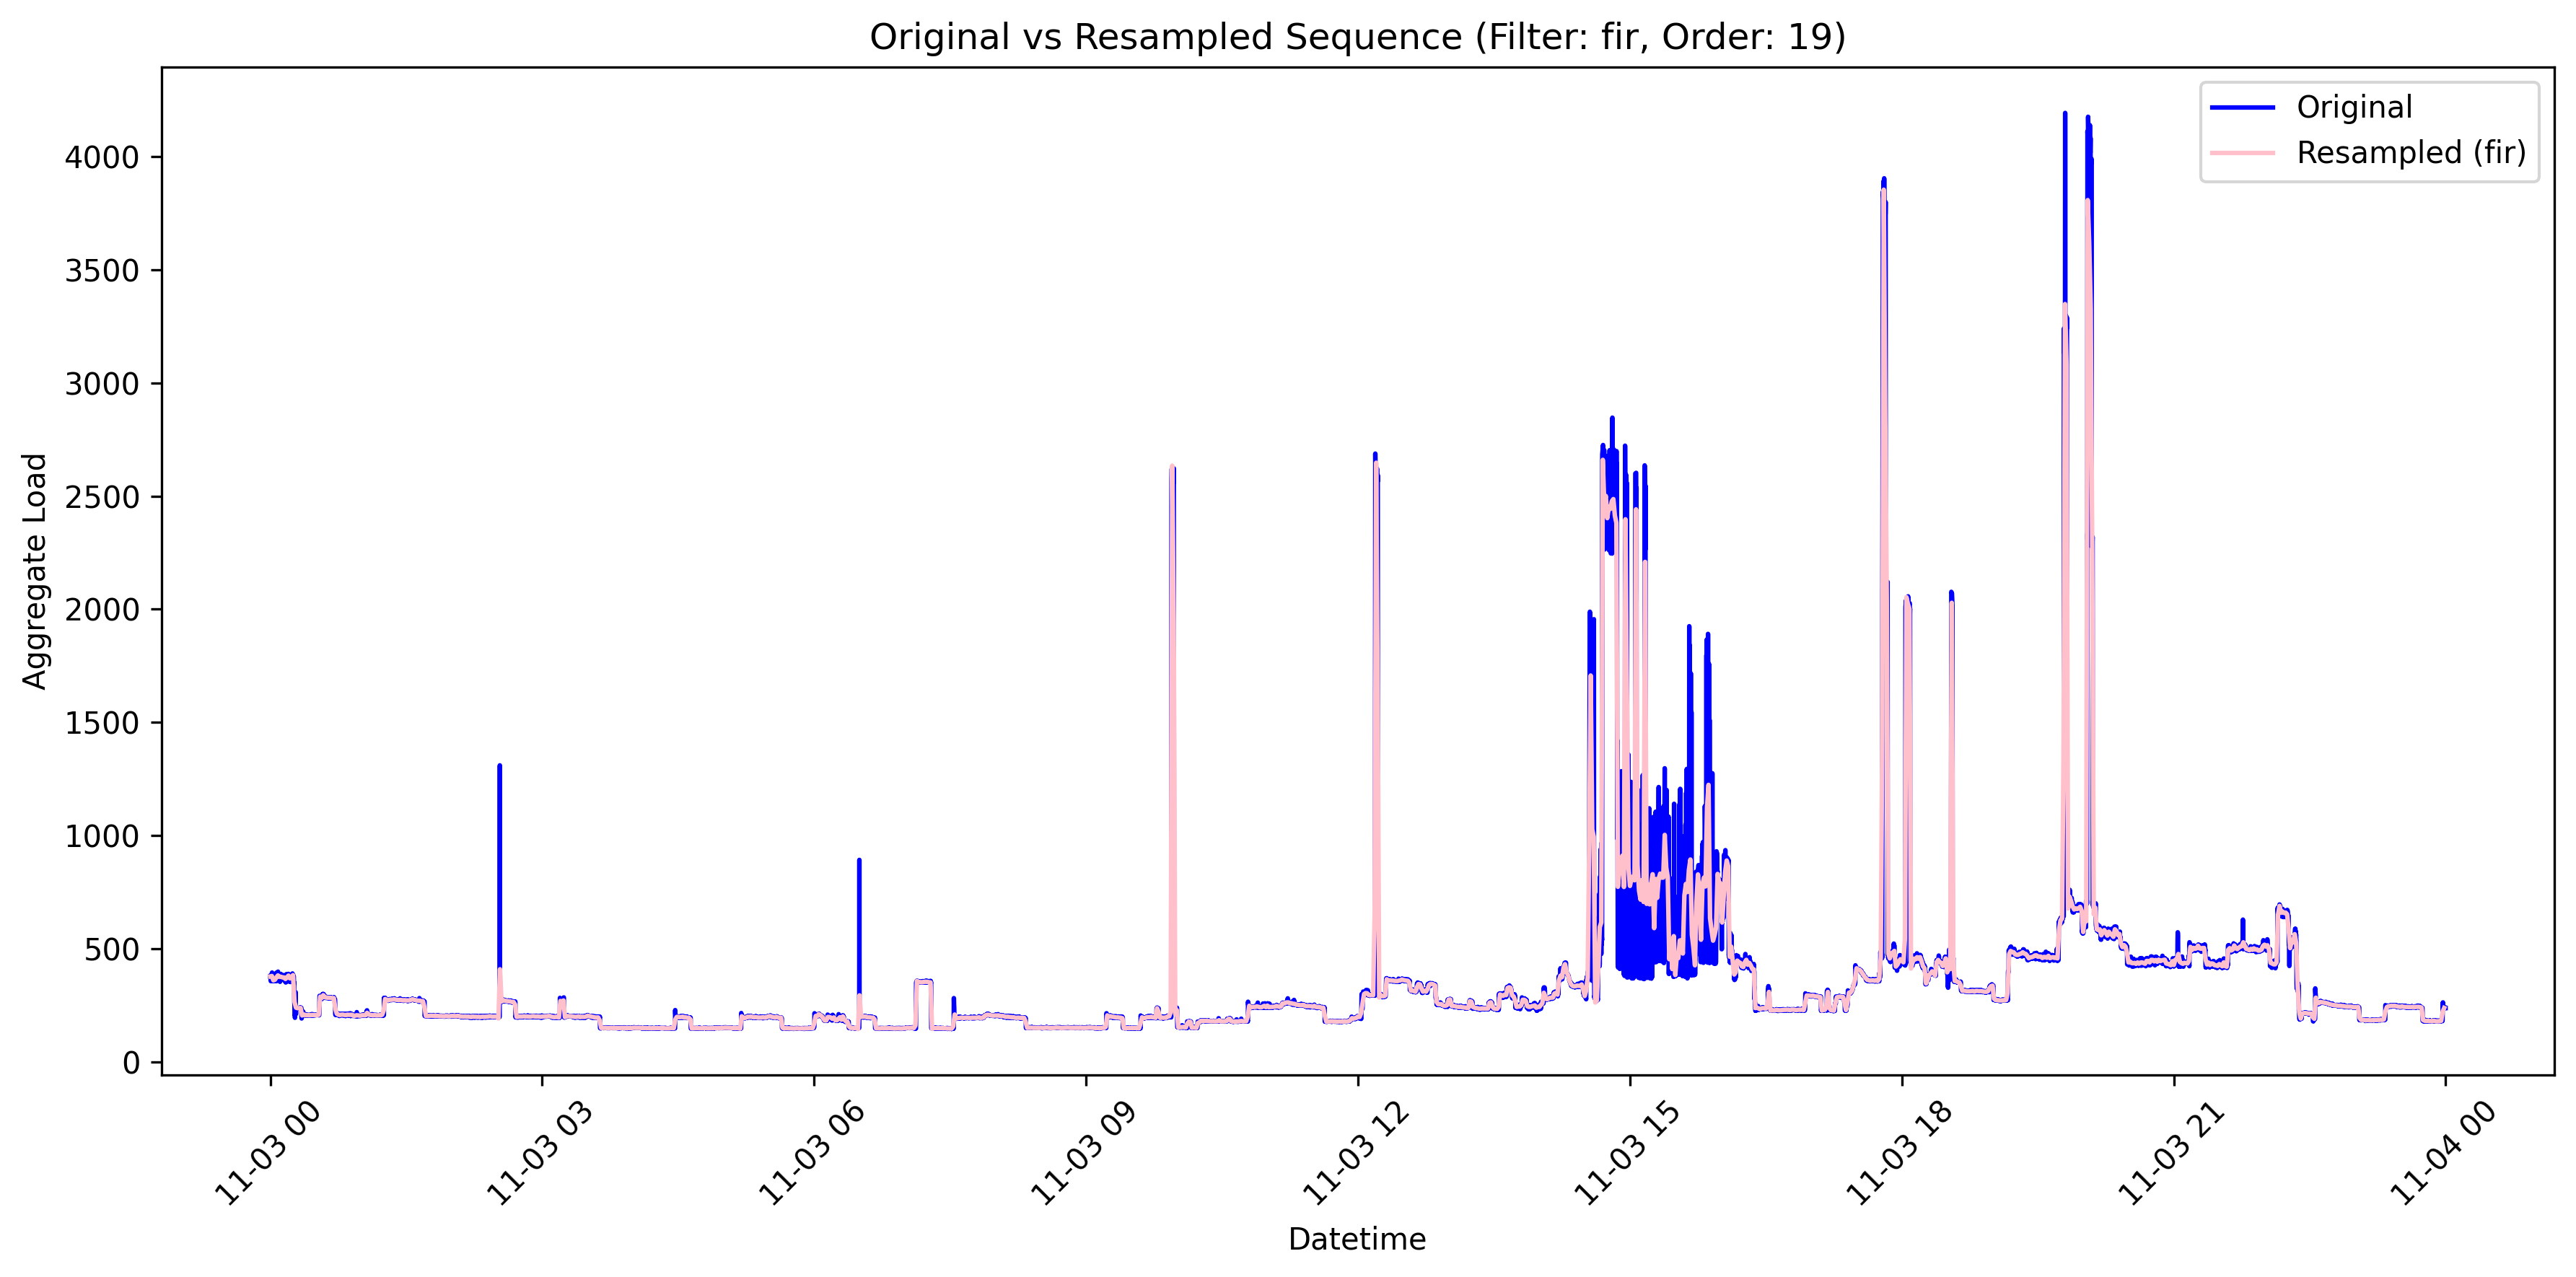

  Original points: 13808
  Downsampled points: 1440
  Compression ratio: 9.6x
  Original time range: 2013-11-03 00:00:03+00:00 to 2013-11-03 23:59:57+00:00
  Downsampled time range: 2013-11-03 00:00:03+00:00 to 2013-11-03 23:59:03+00:00


In [50]:
# Visualize aggregate load data comparison
print("=" * 60)
print("VISUALIZING AGGREGATE LOAD DATA COMPARISON")
print("=" * 60)

# Show comparison for train split
print("Train Split Aggregate Load Comparison:")
for i, idx in enumerate(sample_indices['train'][:5]):  # Show first 5 samples
    print(f"\nSample {i+1} (Index {idx}):")
    original = daily_sequences_train[idx]
    downsampled = downsampled_train[idx]
    
    if not original.empty and not downsampled.empty:
        plot_sequences_2(original, downsampled, filter_type, filter_order)
        
        # Print some stats
        print(f"  Original points: {len(original)}")
        print(f"  Downsampled points: {len(downsampled)}")
        print(f"  Compression ratio: {len(original)/len(downsampled):.1f}x")
        print(f"  Original time range: {original['datetime'].iloc[0]} to {original['datetime'].iloc[-1]}")
        print(f"  Downsampled time range: {downsampled['datetime'].iloc[0]} to {downsampled['datetime'].iloc[-1]}")
    else:
        print(f"  Skipping empty sequence")

In [40]:
def plot_sequences_appliance(appliance_name, original, resampled, filter_type, filter_order):
    """Plot original and resampled sequences with filter type and order"""
    plt.figure(figsize=(12, 6), dpi=300)
    sns.lineplot(x='datetime', y=f'{appliance_name}', data=original, label='Original', color='blue')
    sns.lineplot(x='datetime', y=f'{appliance_name}', data=resampled, label=f'Resampled ({filter_type})', color='pink')
    plt.title(f'Original vs Resampled Sequence (Filter: {filter_type}, Order: {filter_order})')
    plt.xlabel('Datetime')
    plt.ylabel('Aggregate Load')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [41]:
# Sample some appliance signatures for visualization
selected_appliances = ['microwave', 'kettle', 'washing_machine', 'dishwasher']

selected_ranges = {'train': {}, 'val': {}, 'test': {}}

# for each selected appliance, we randomly sample 5 sequences from the train split
for appl in selected_appliances:
    ranges = ranges_train[appl]
    sampled_indices = np.random.choice(len(ranges), size=min(5, len(ranges)), replace=False)
    selected_ranges['train'][appl] = sampled_indices

# for each selected appliance, we randomly sample 5 sequences from the validation split
for appl in selected_appliances:
    ranges = ranges_val[appl]
    sampled_indices = np.random.choice(len(ranges), size=min(5, len(ranges)), replace=False)
    selected_ranges['val'][appl] = sampled_indices

# for each selected appliance, we randomly sample 5 sequences from the test split
for appl in selected_appliances:
    ranges = ranges_test[appl]
    sampled_indices = np.random.choice(len(ranges), size=min(5, len(ranges)), replace=False)
    selected_ranges['test'][appl] = sampled_indices

print(f"\nSelected appliances for visualization: {selected_appliances}")
print(f"Sampled indices for each split:")
for split_name, appliances in selected_ranges.items():
    print(f"  {split_name}:")
    for appl, indices in appliances.items():
        print(f"    {appl}: {list(indices)}")


Selected appliances for visualization: ['microwave', 'kettle', 'washing_machine', 'dishwasher']
Sampled indices for each split:
  train:
    microwave: [4, 0, 20, 17, 16]
    kettle: [36, 16, 20, 33, 3]
    washing_machine: [10, 4, 11, 1, 13]
    dishwasher: [2, 1, 4, 6, 3]
  val:
    microwave: [18, 13, 7, 3, 2]
    kettle: [3, 13, 1, 11, 4]
    washing_machine: [0, 4, 3, 5, 1]
    dishwasher: [0]
  test:
    microwave: [10, 18, 15, 17, 13]
    kettle: [14, 2, 10, 0, 21]
    washing_machine: [4, 1, 3, 6, 0]
    dishwasher: [0, 2, 1]


VISUALIZING APPLIANCE SIGNATURE DATA COMPARISON

MICROWAVE Signature Comparison:


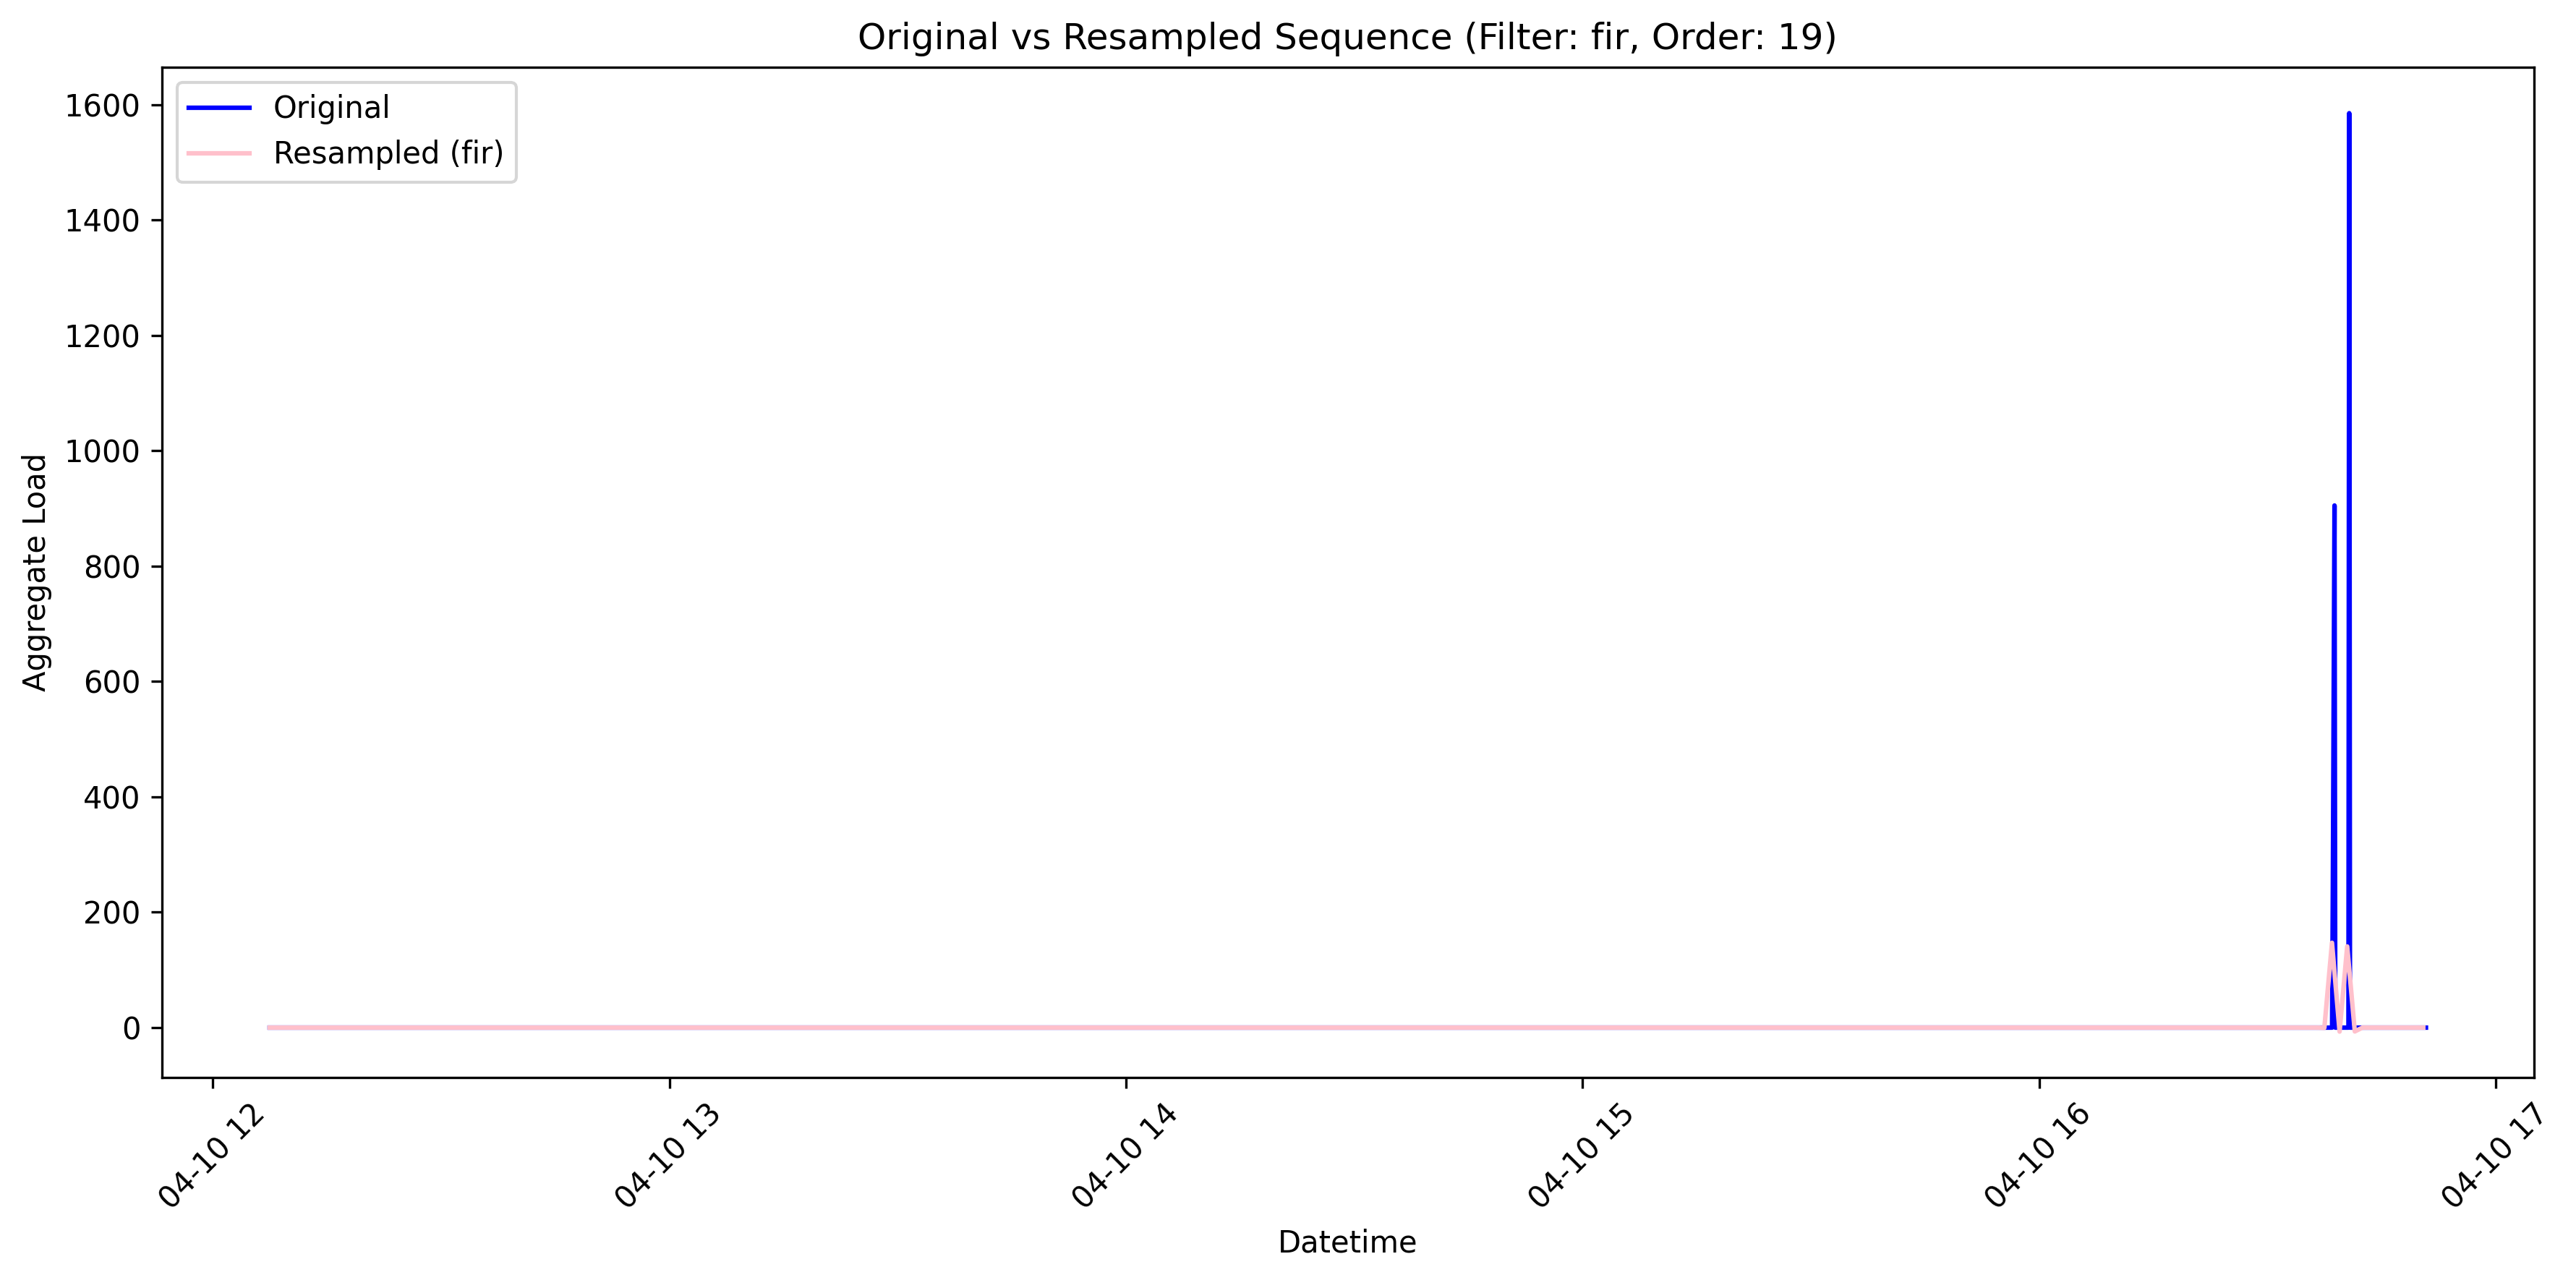

    Original points: 224
    Downsampled points: 284
    Compression ratio: 0.8x
    Original time range: 2013-04-10 12:07:28 to 2013-04-10 16:50:49
    Downsampled time range: 2013-04-10 12:07:28 to 2013-04-10 16:50:28


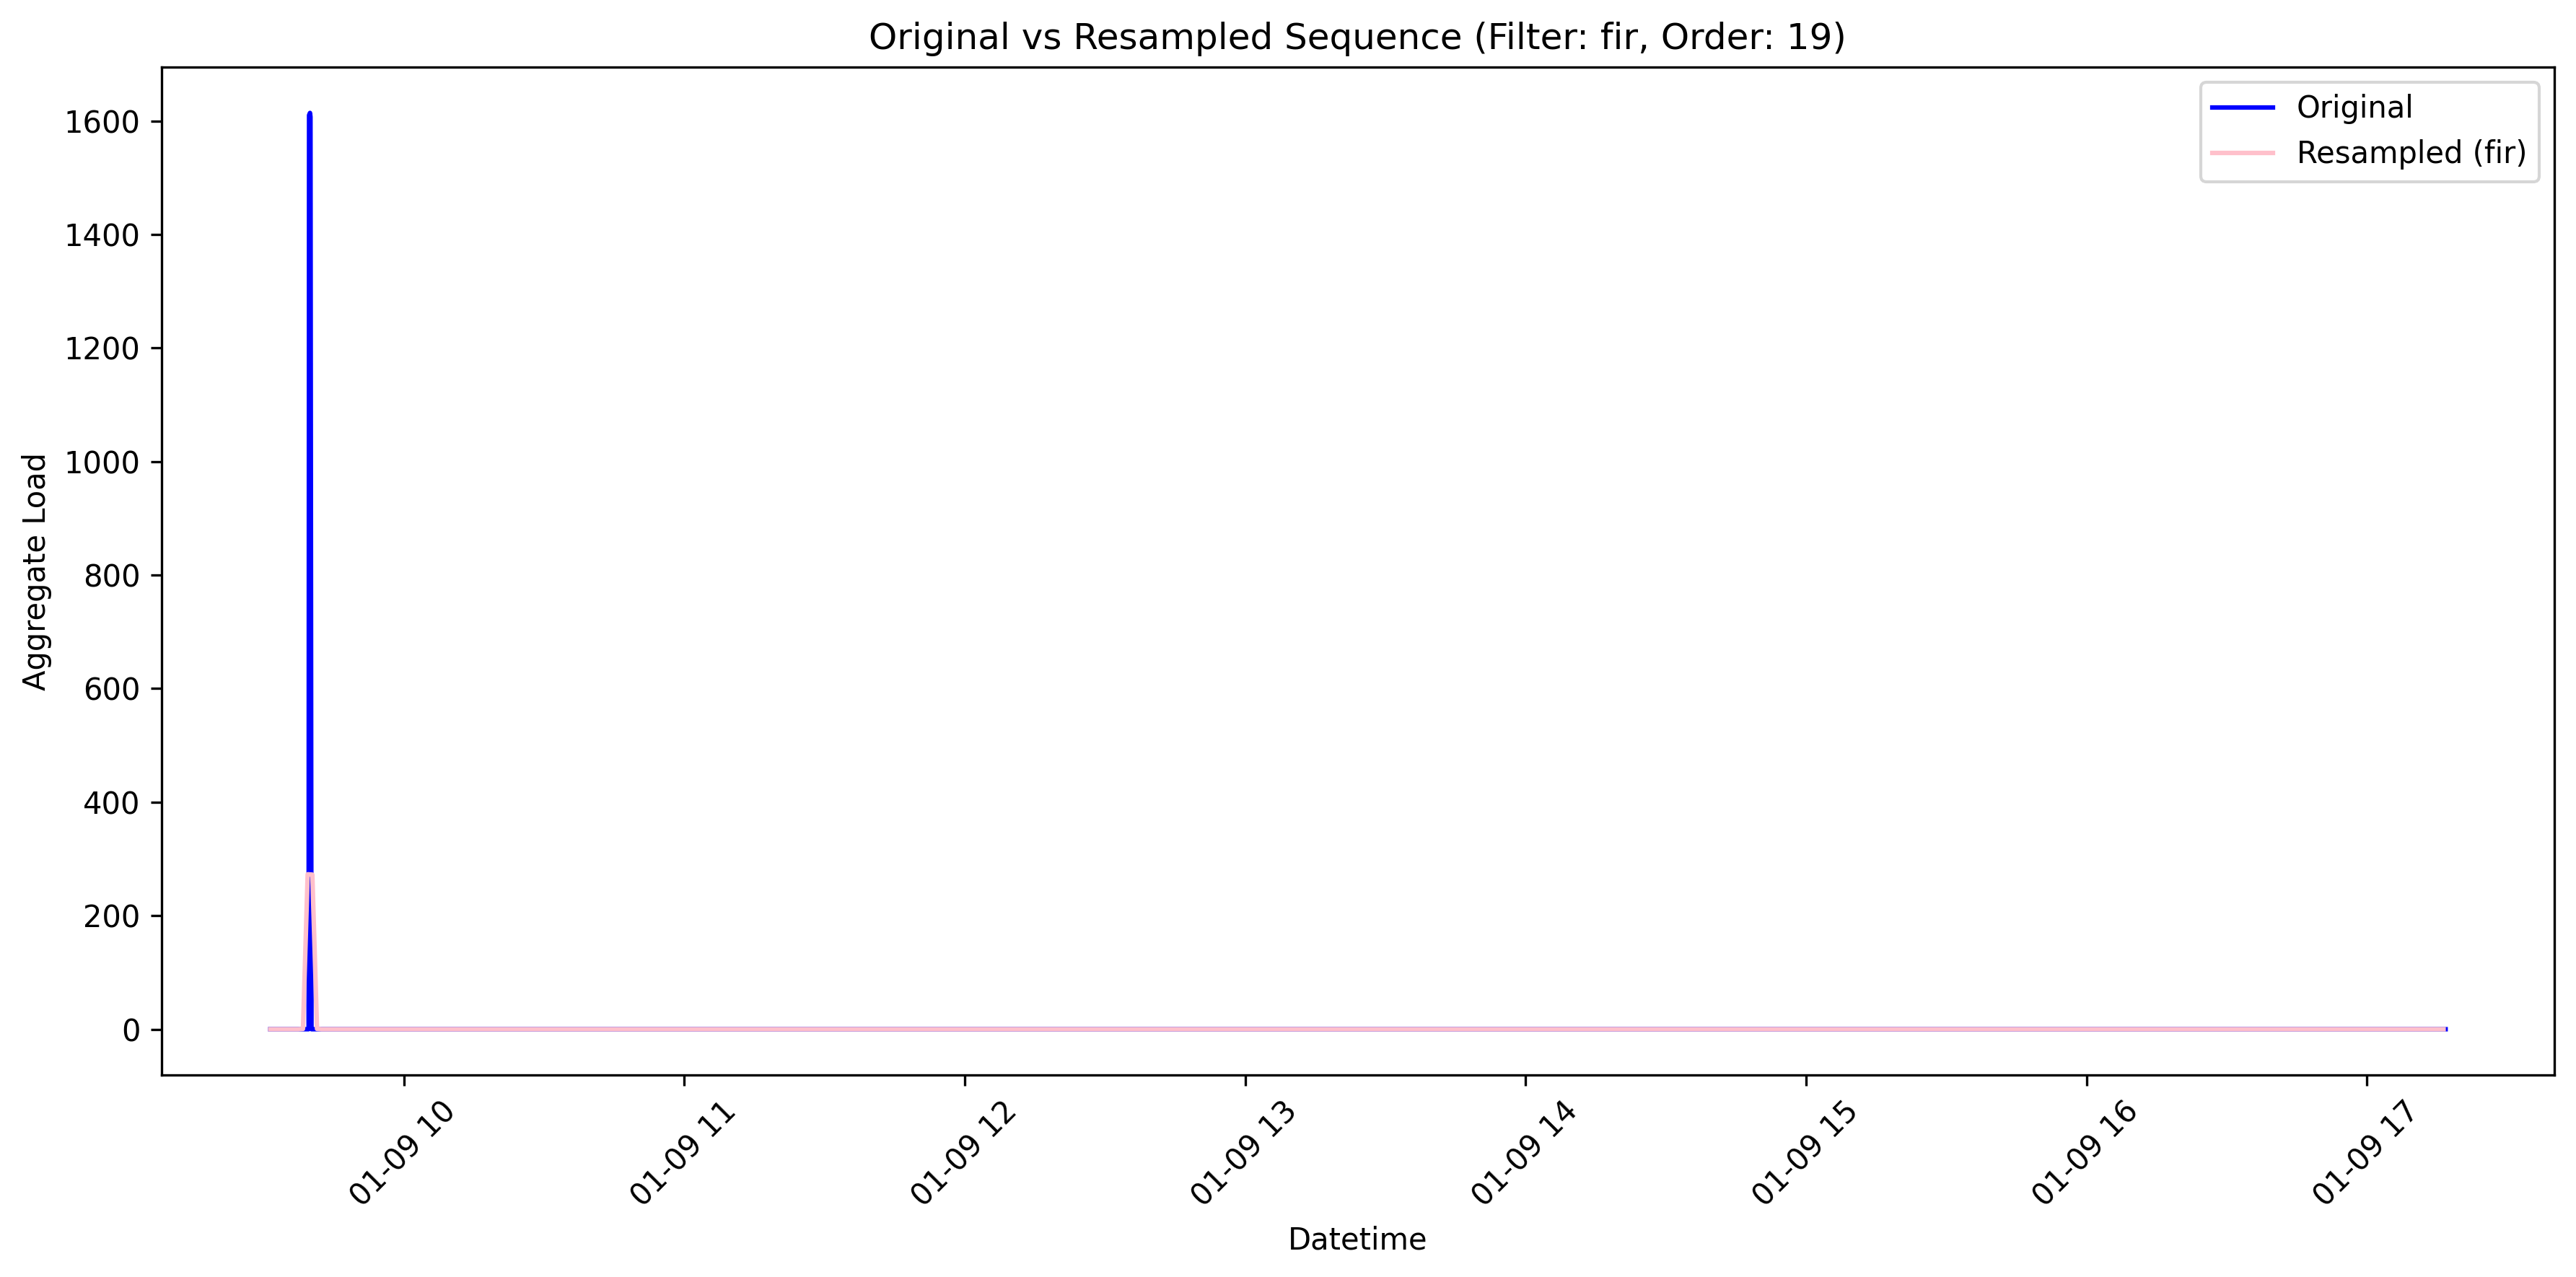

    Original points: 238
    Downsampled points: 466
    Compression ratio: 0.5x
    Original time range: 2013-01-09 09:31:24 to 2013-01-09 17:16:50
    Downsampled time range: 2013-01-09 09:31:24 to 2013-01-09 17:16:24


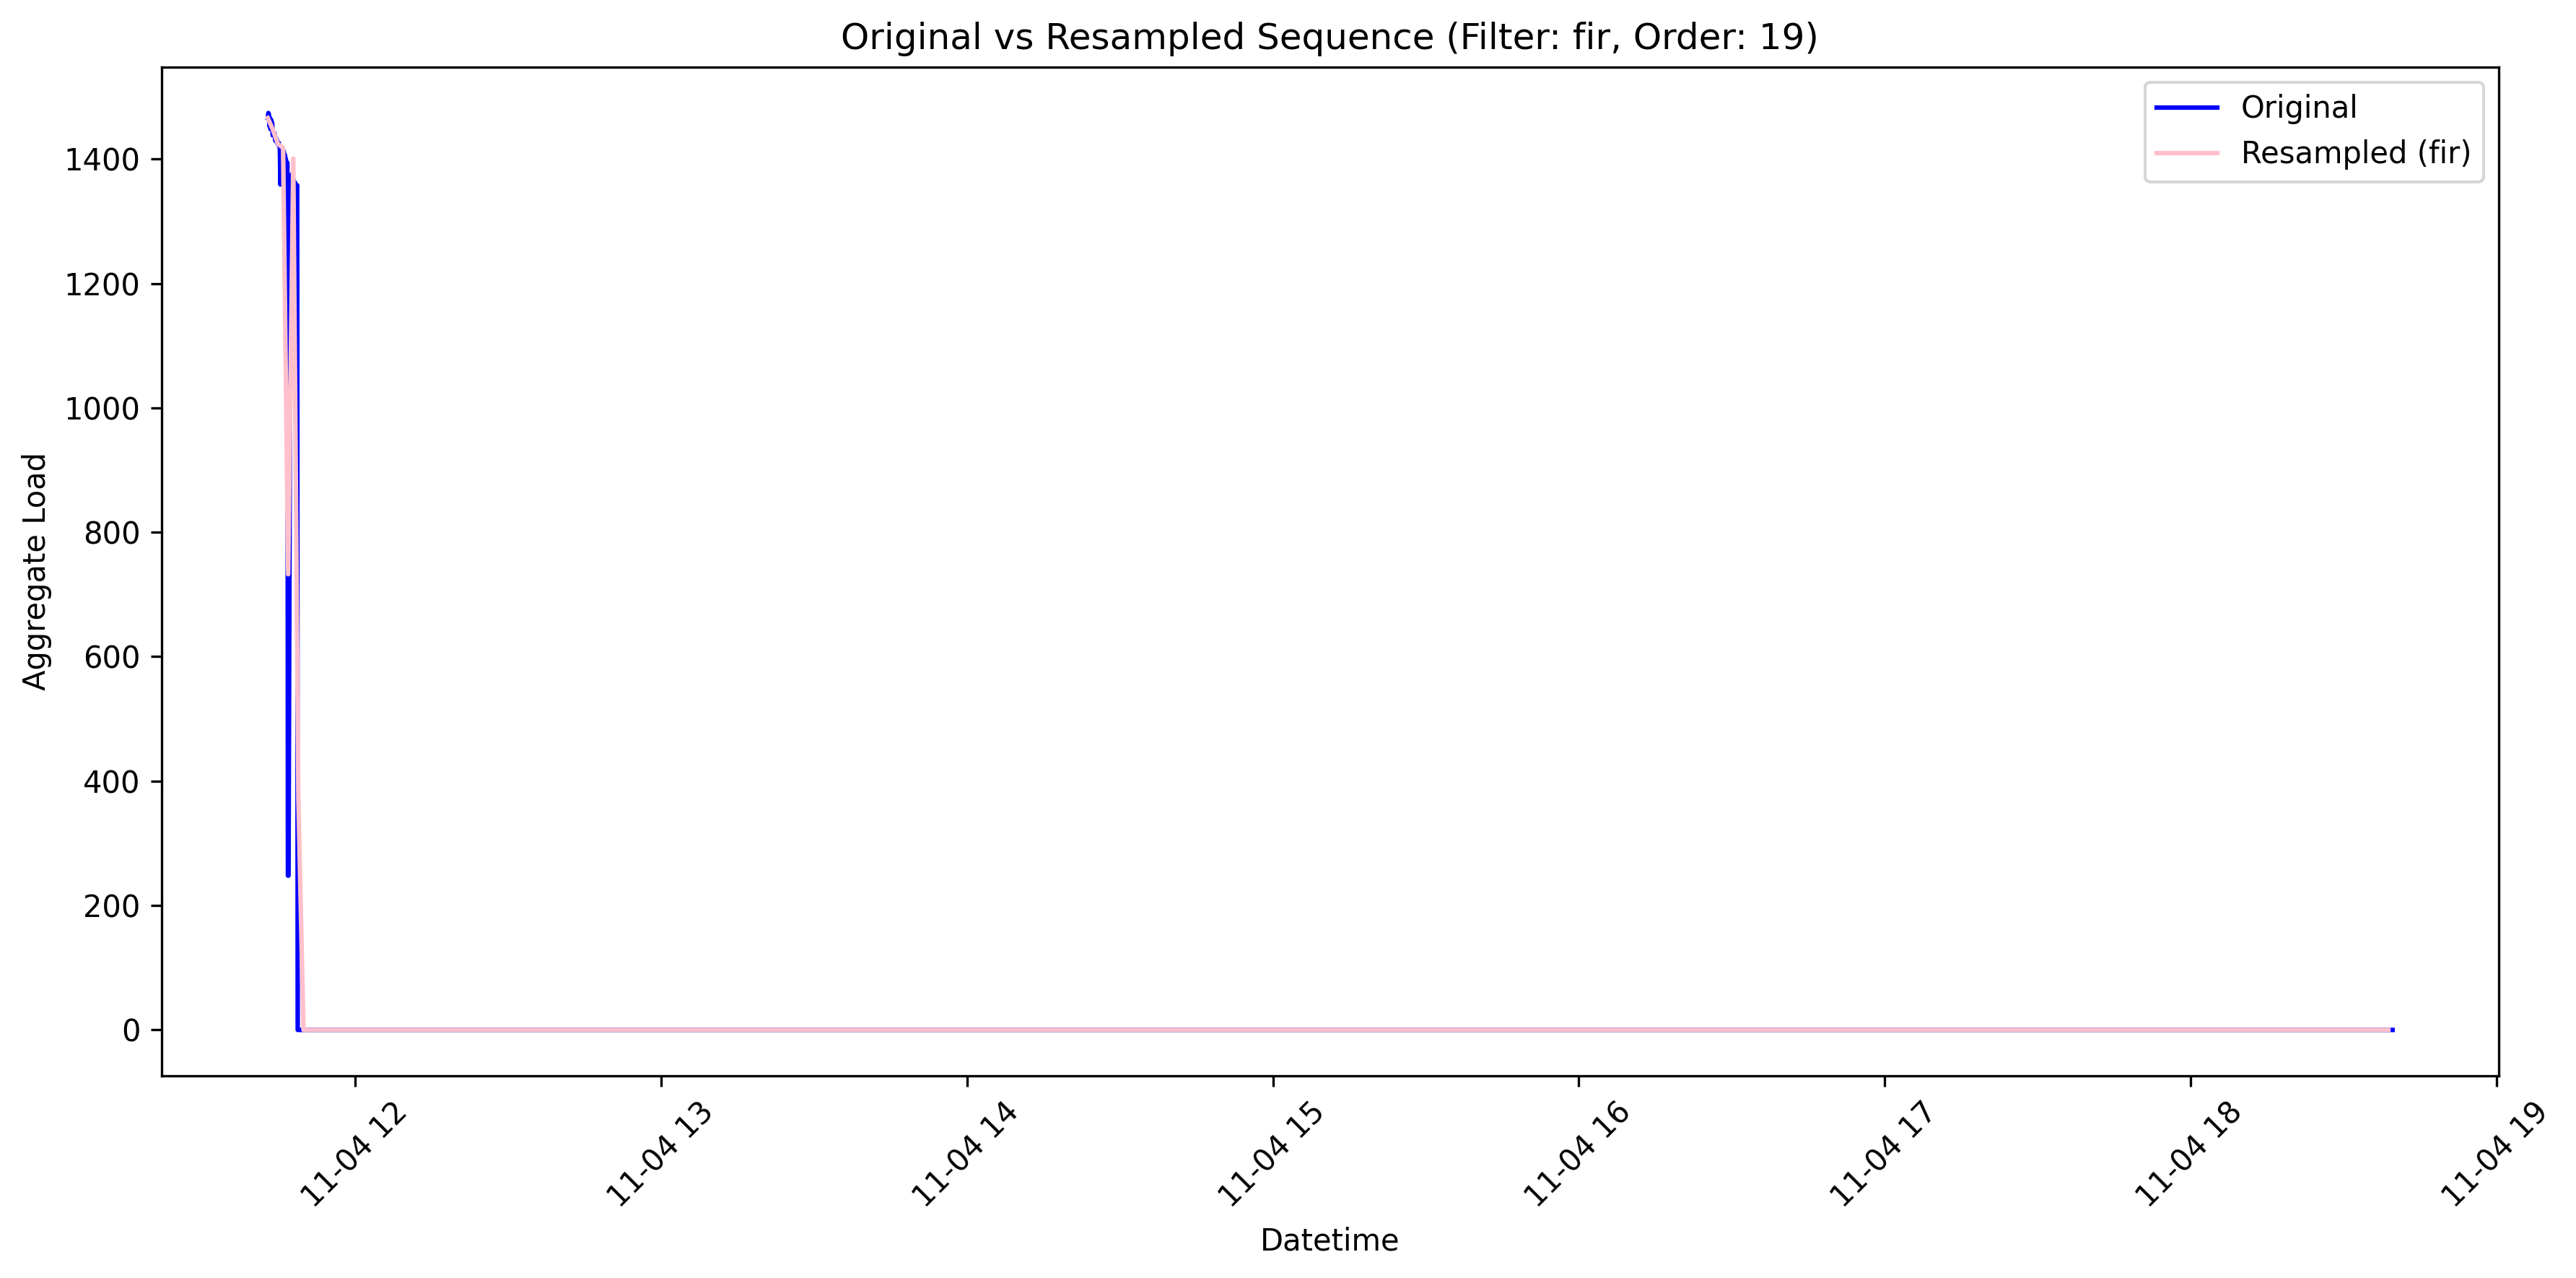

    Original points: 204
    Downsampled points: 417
    Compression ratio: 0.5x
    Original time range: 2013-11-04 11:42:50 to 2013-11-04 18:39:39
    Downsampled time range: 2013-11-04 11:42:50 to 2013-11-04 18:38:50


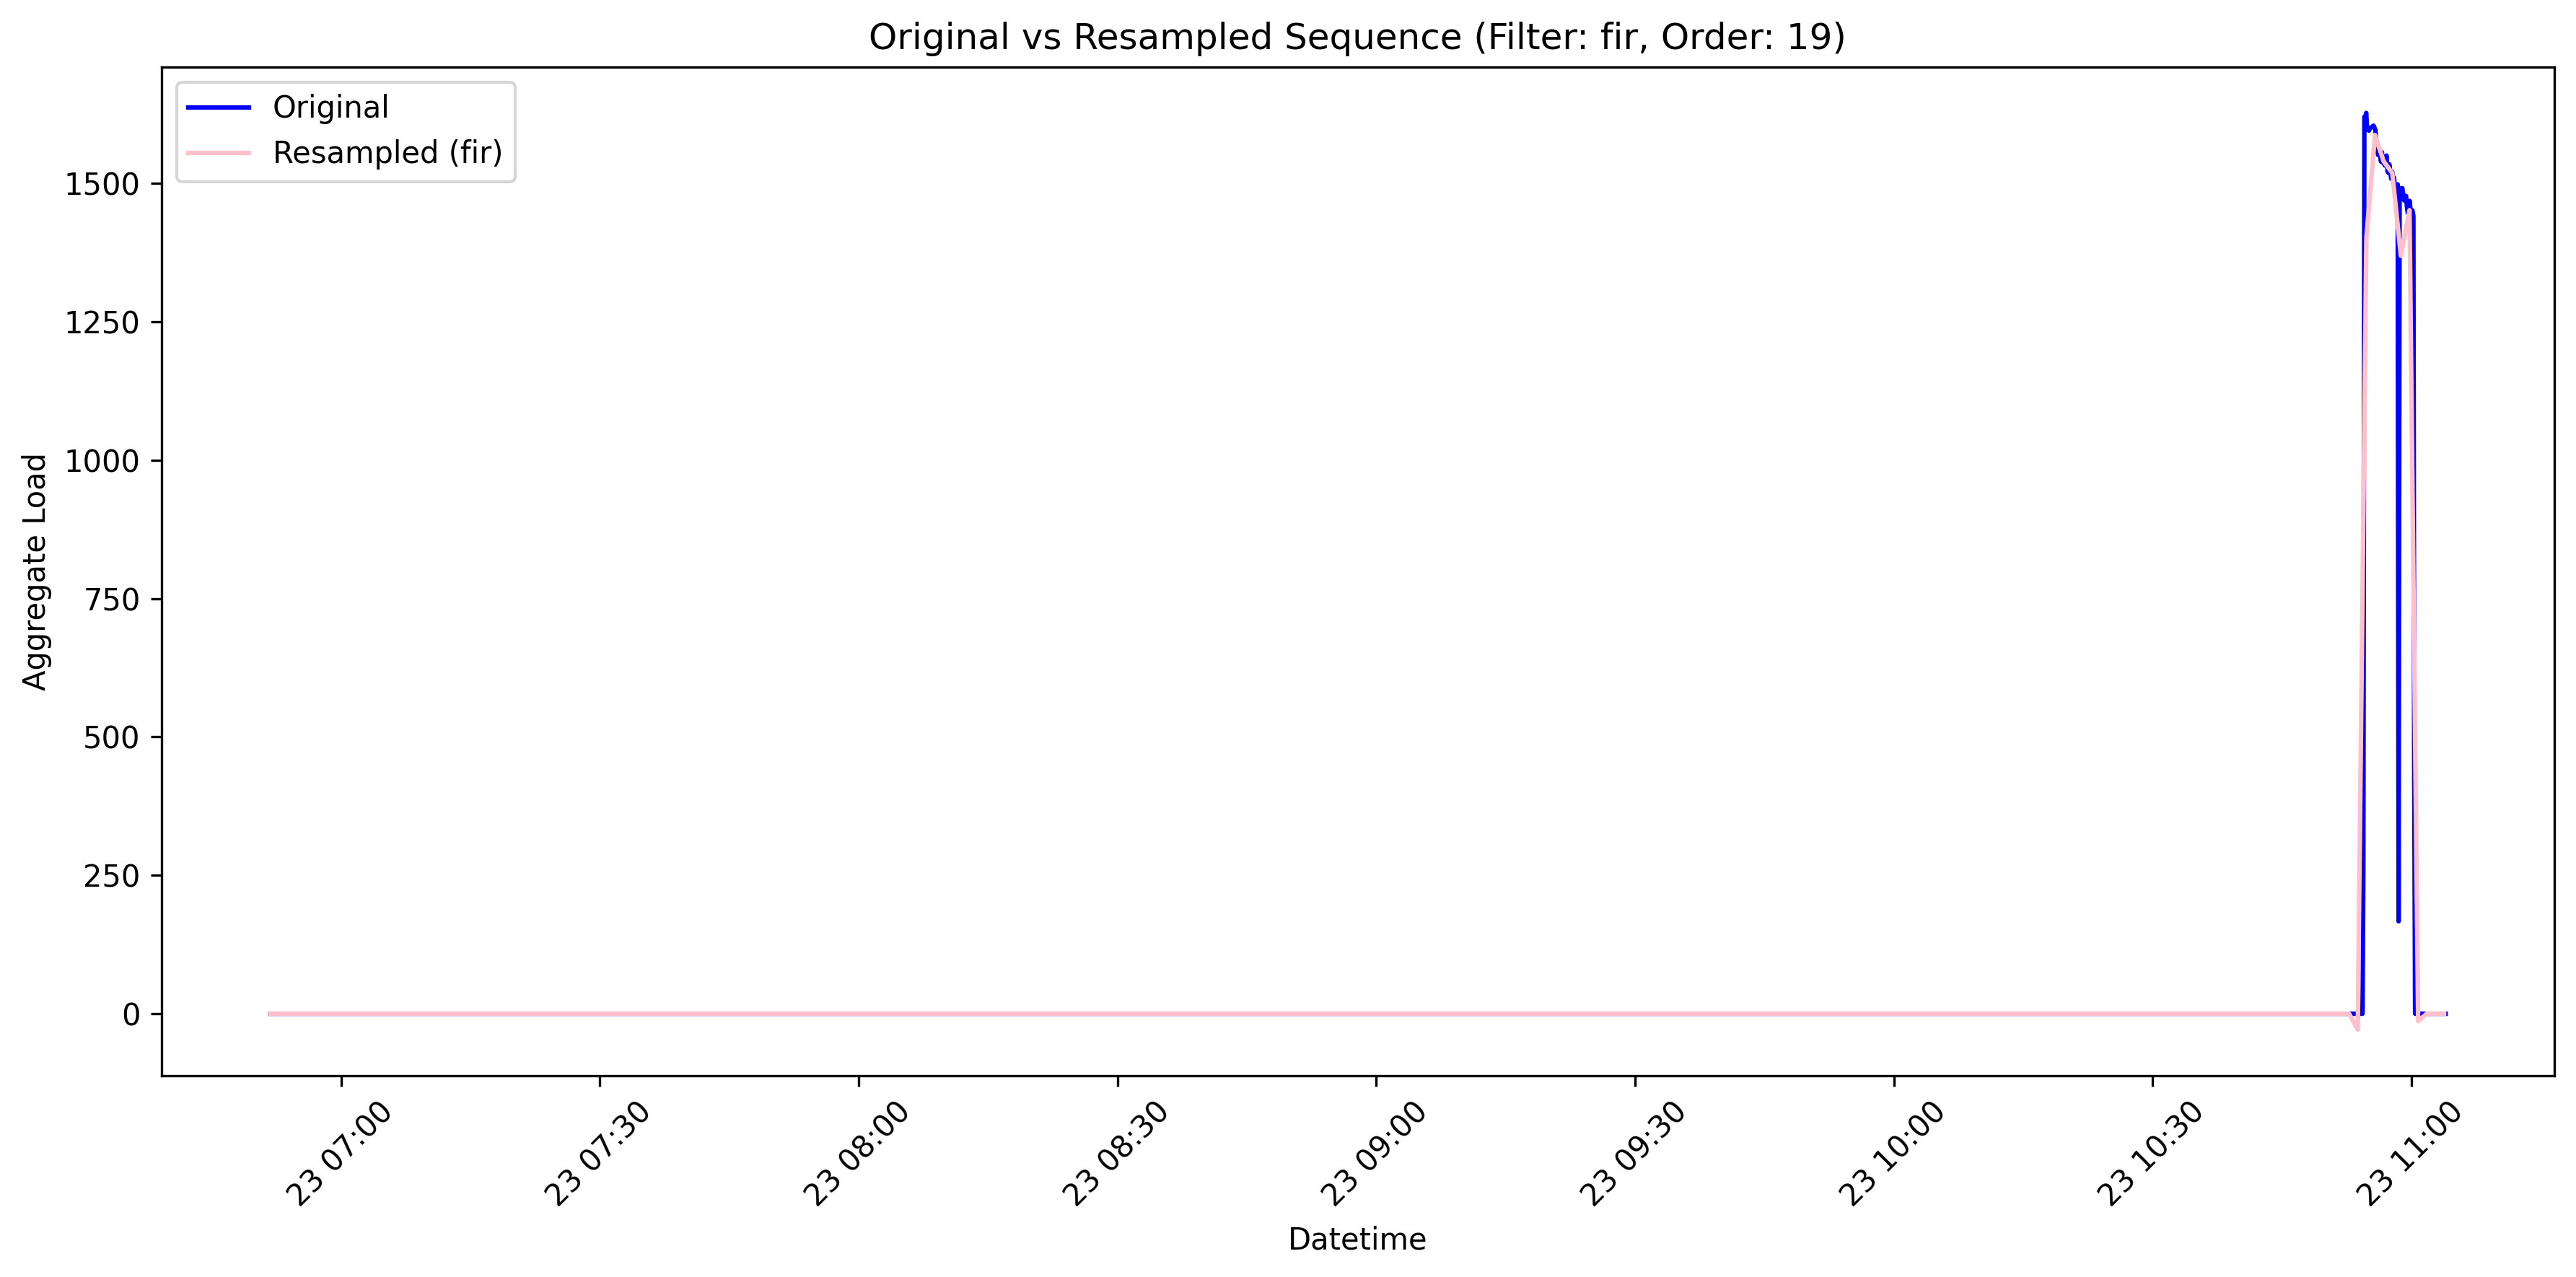

    Original points: 208
    Downsampled points: 253
    Compression ratio: 0.8x
    Original time range: 2013-10-23 06:51:47 to 2013-10-23 11:03:58
    Downsampled time range: 2013-10-23 06:51:47 to 2013-10-23 11:03:47


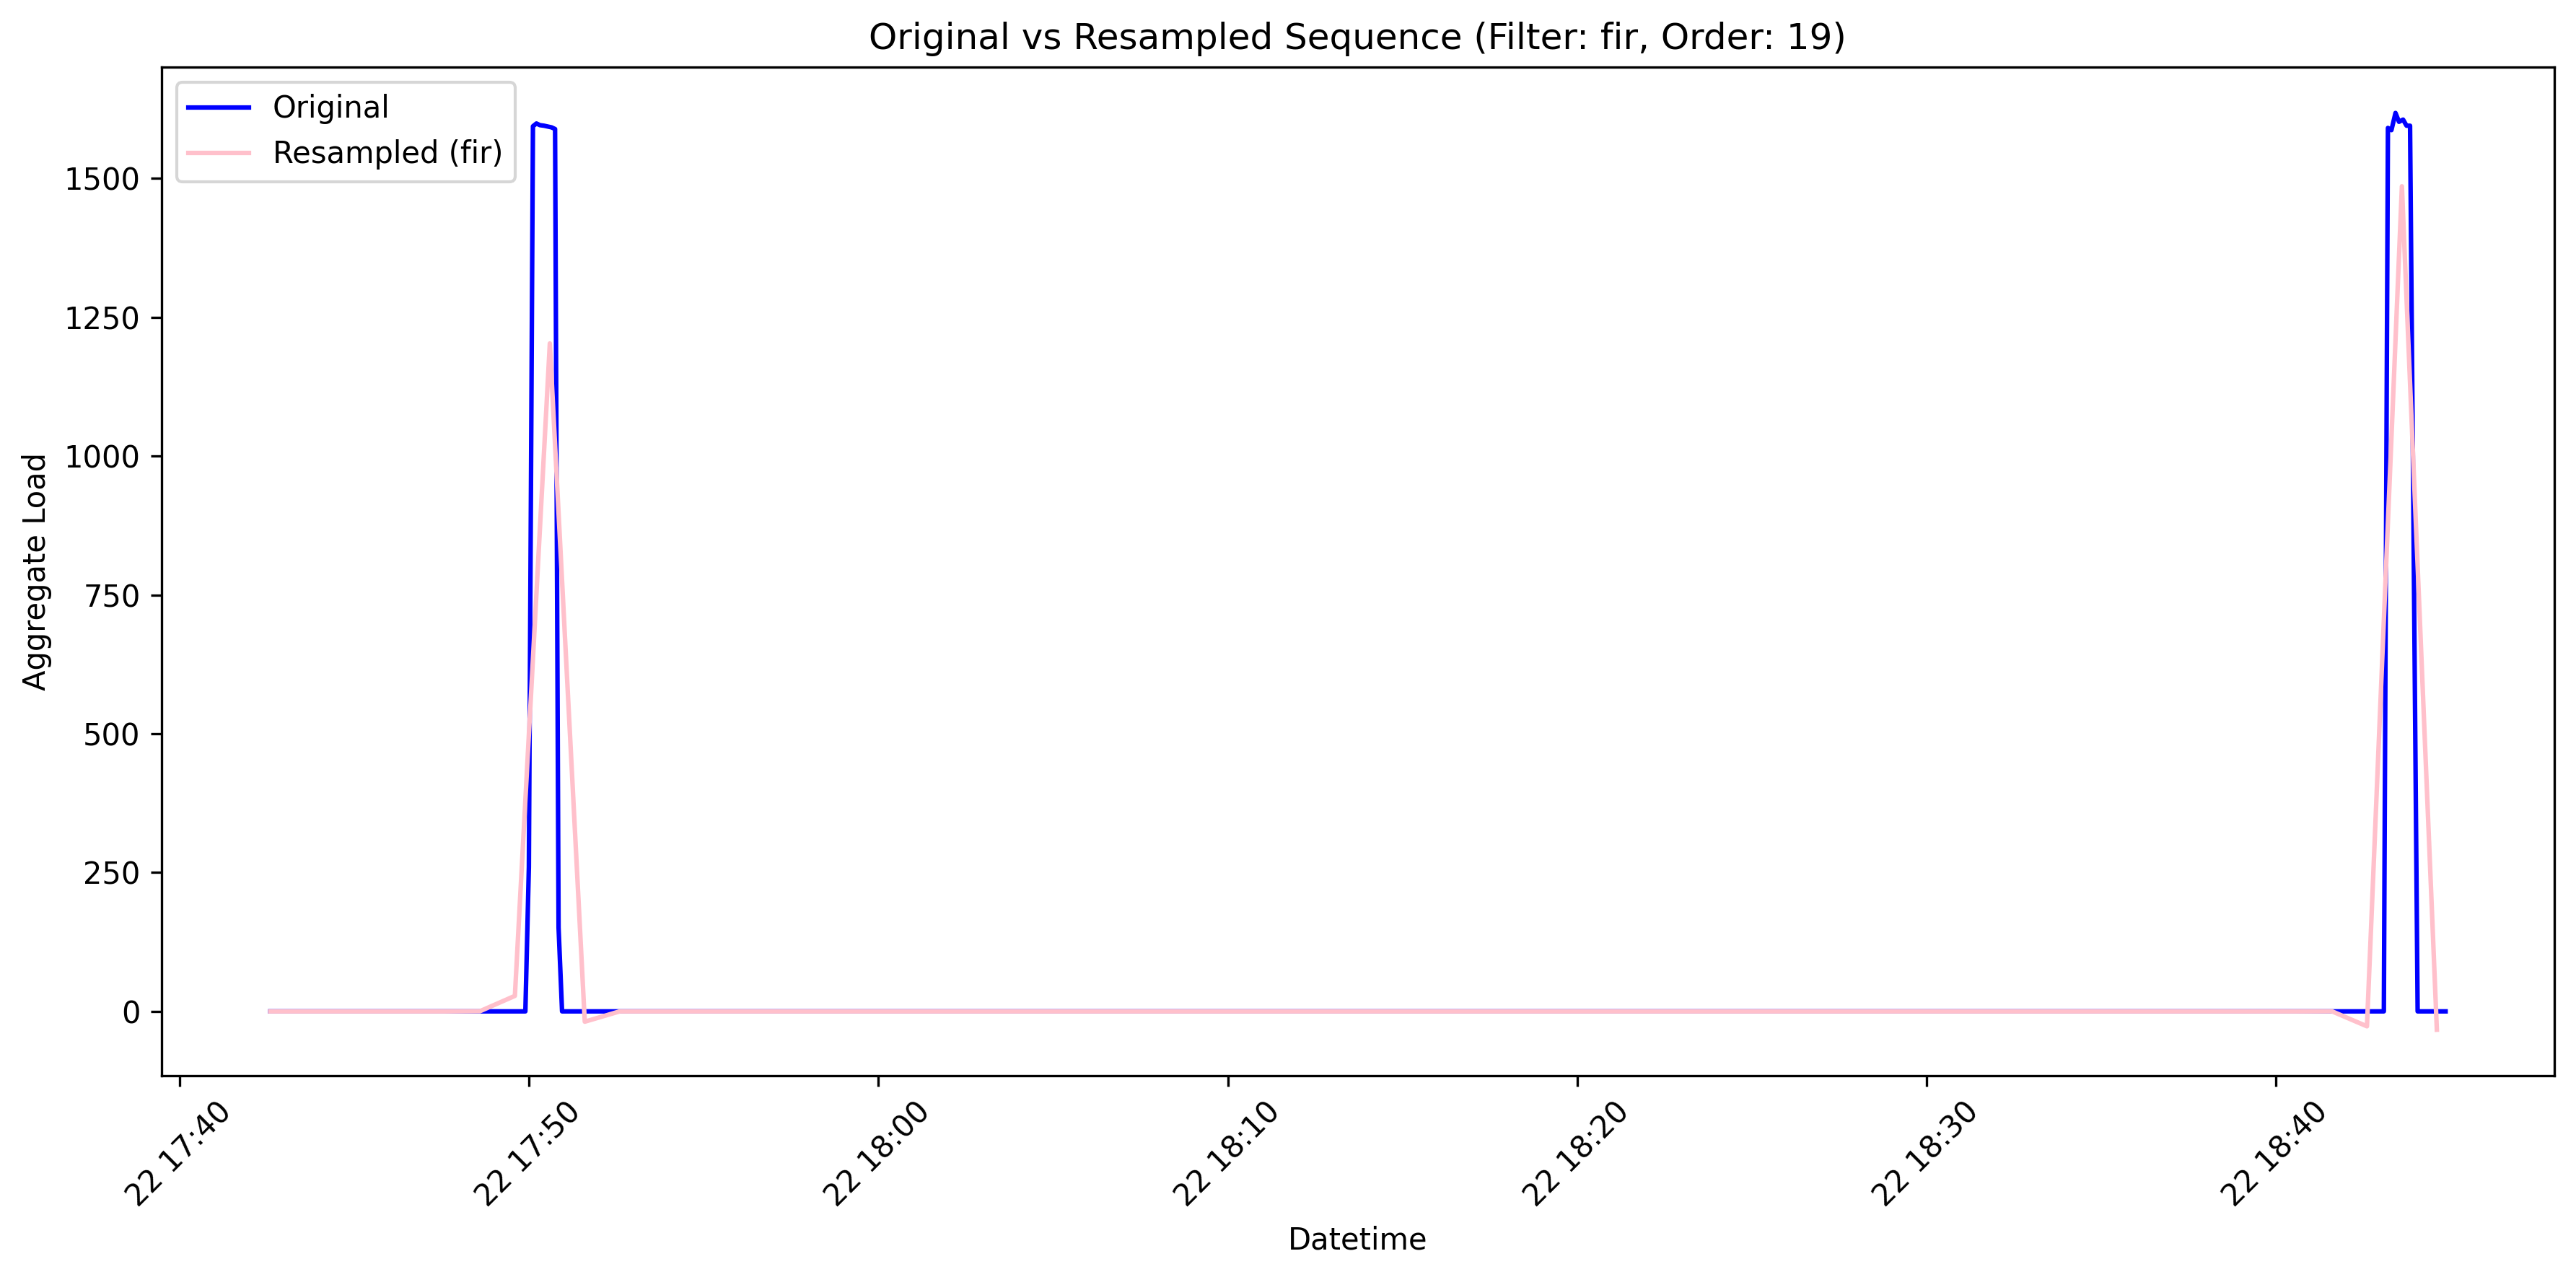

    Original points: 295
    Downsampled points: 63
    Compression ratio: 4.7x
    Original time range: 2013-10-22 17:42:36 to 2013-10-22 18:44:51
    Downsampled time range: 2013-10-22 17:42:36 to 2013-10-22 18:44:36

KETTLE Signature Comparison:


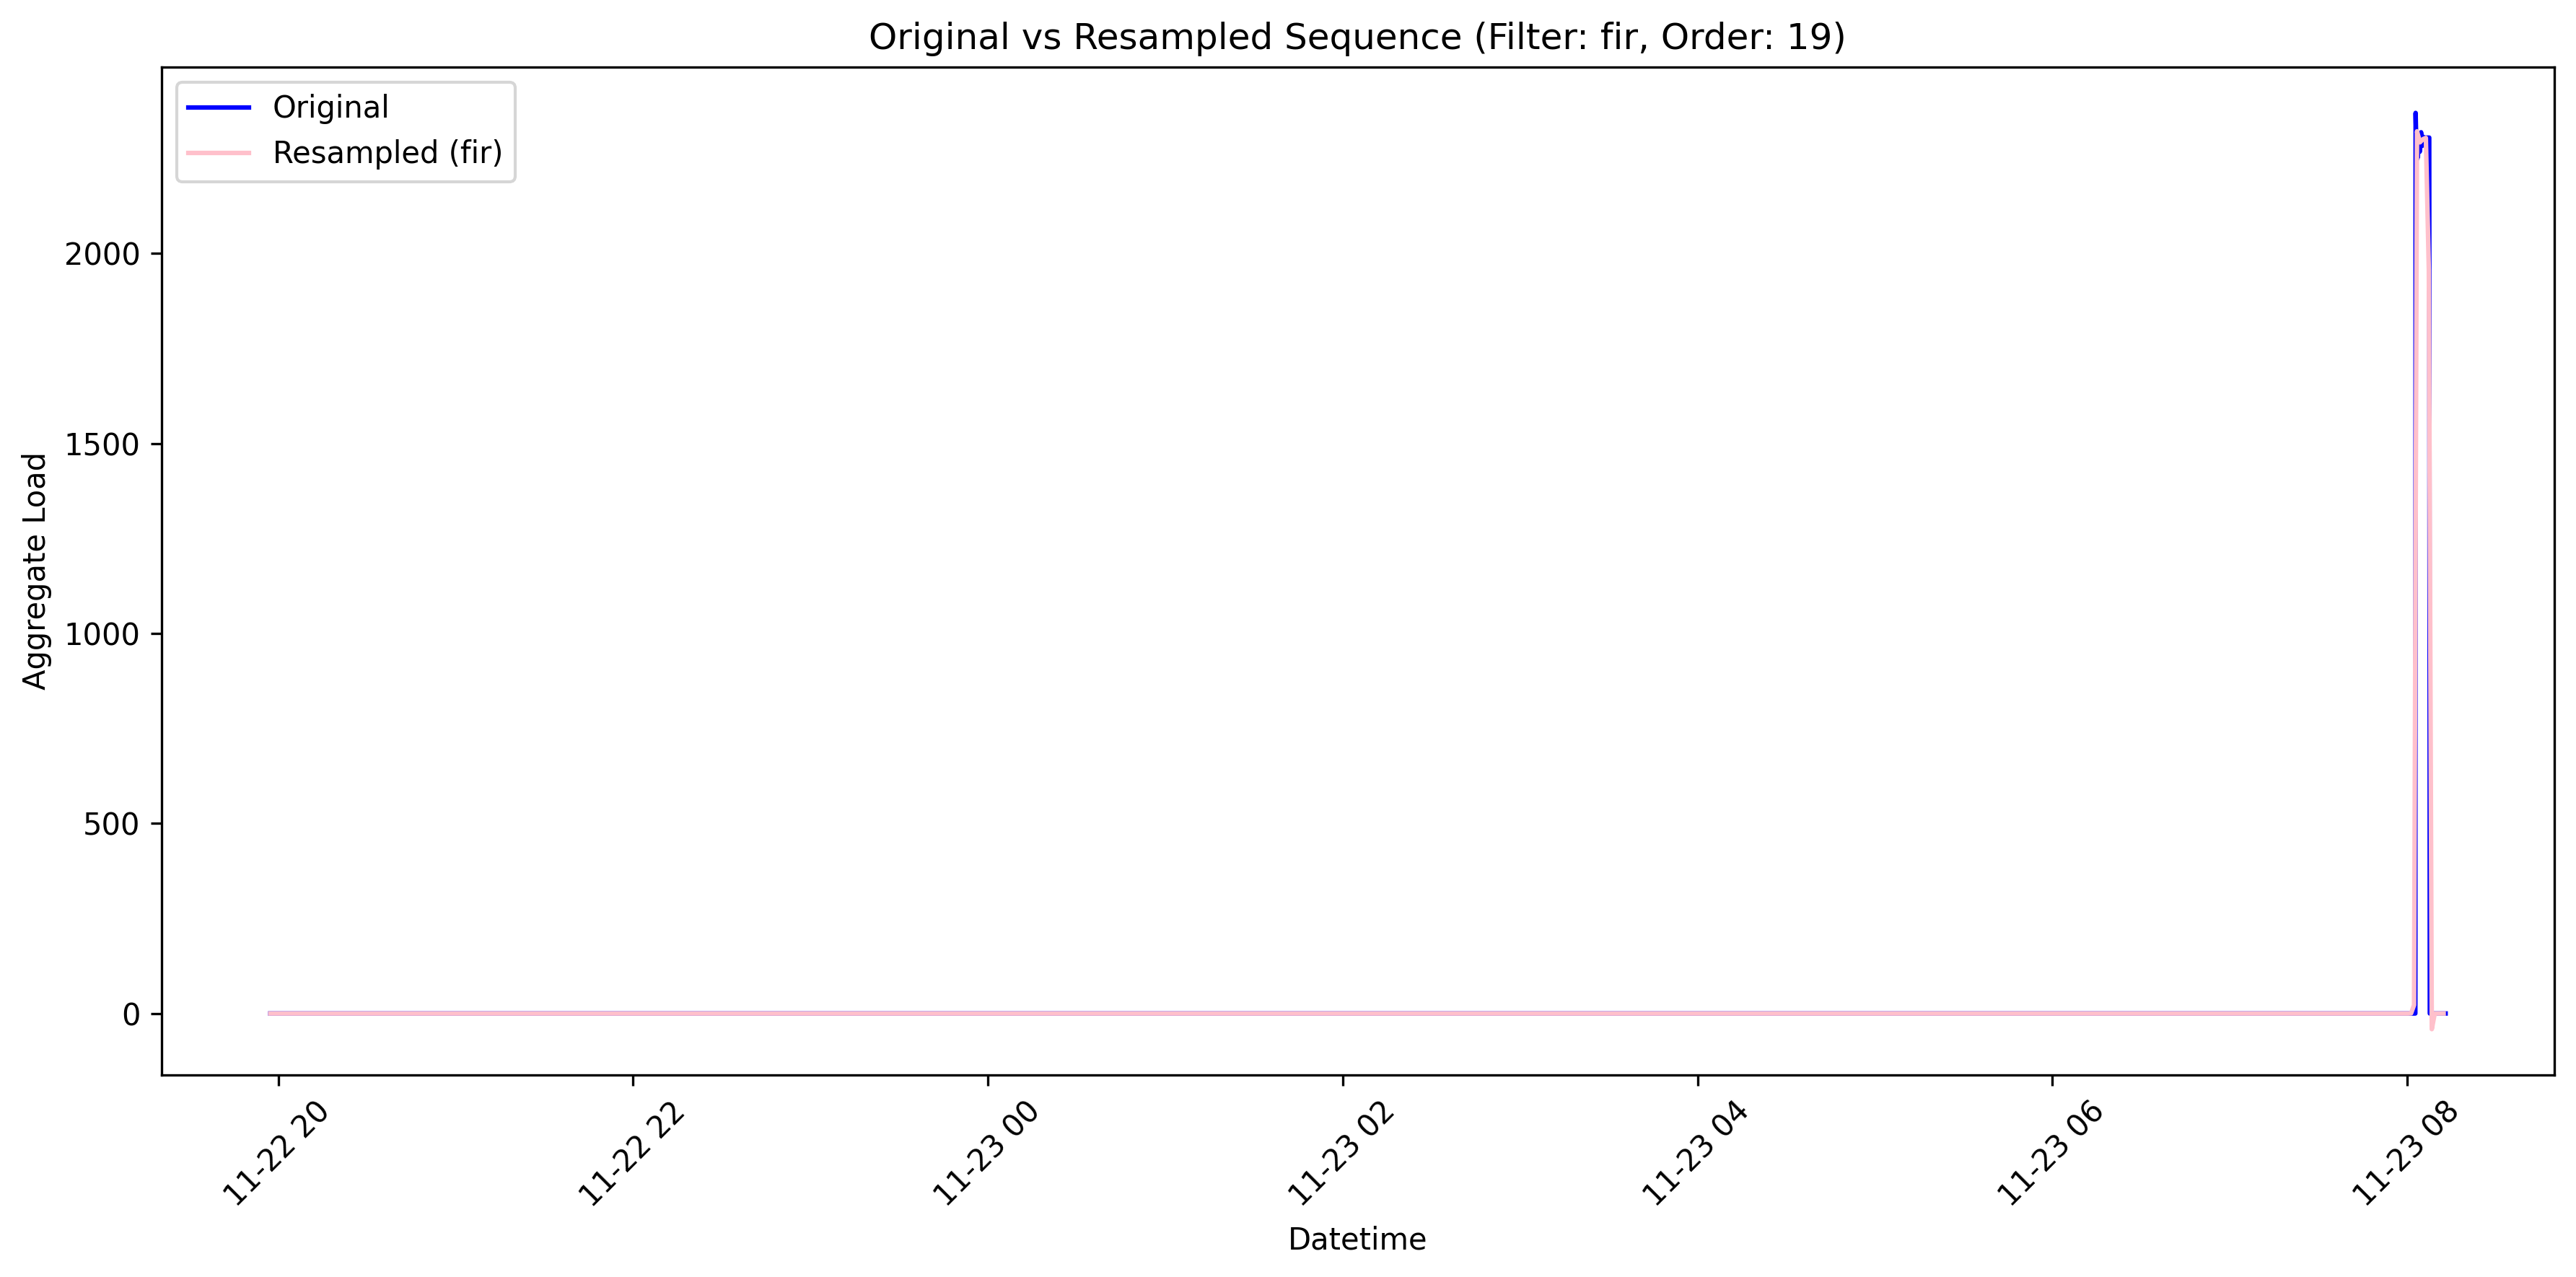

    Original points: 211
    Downsampled points: 736
    Compression ratio: 0.3x
    Original time range: 2013-11-22 19:57:17 to 2013-11-23 08:12:57
    Downsampled time range: 2013-11-22 19:57:17 to 2013-11-23 08:12:17


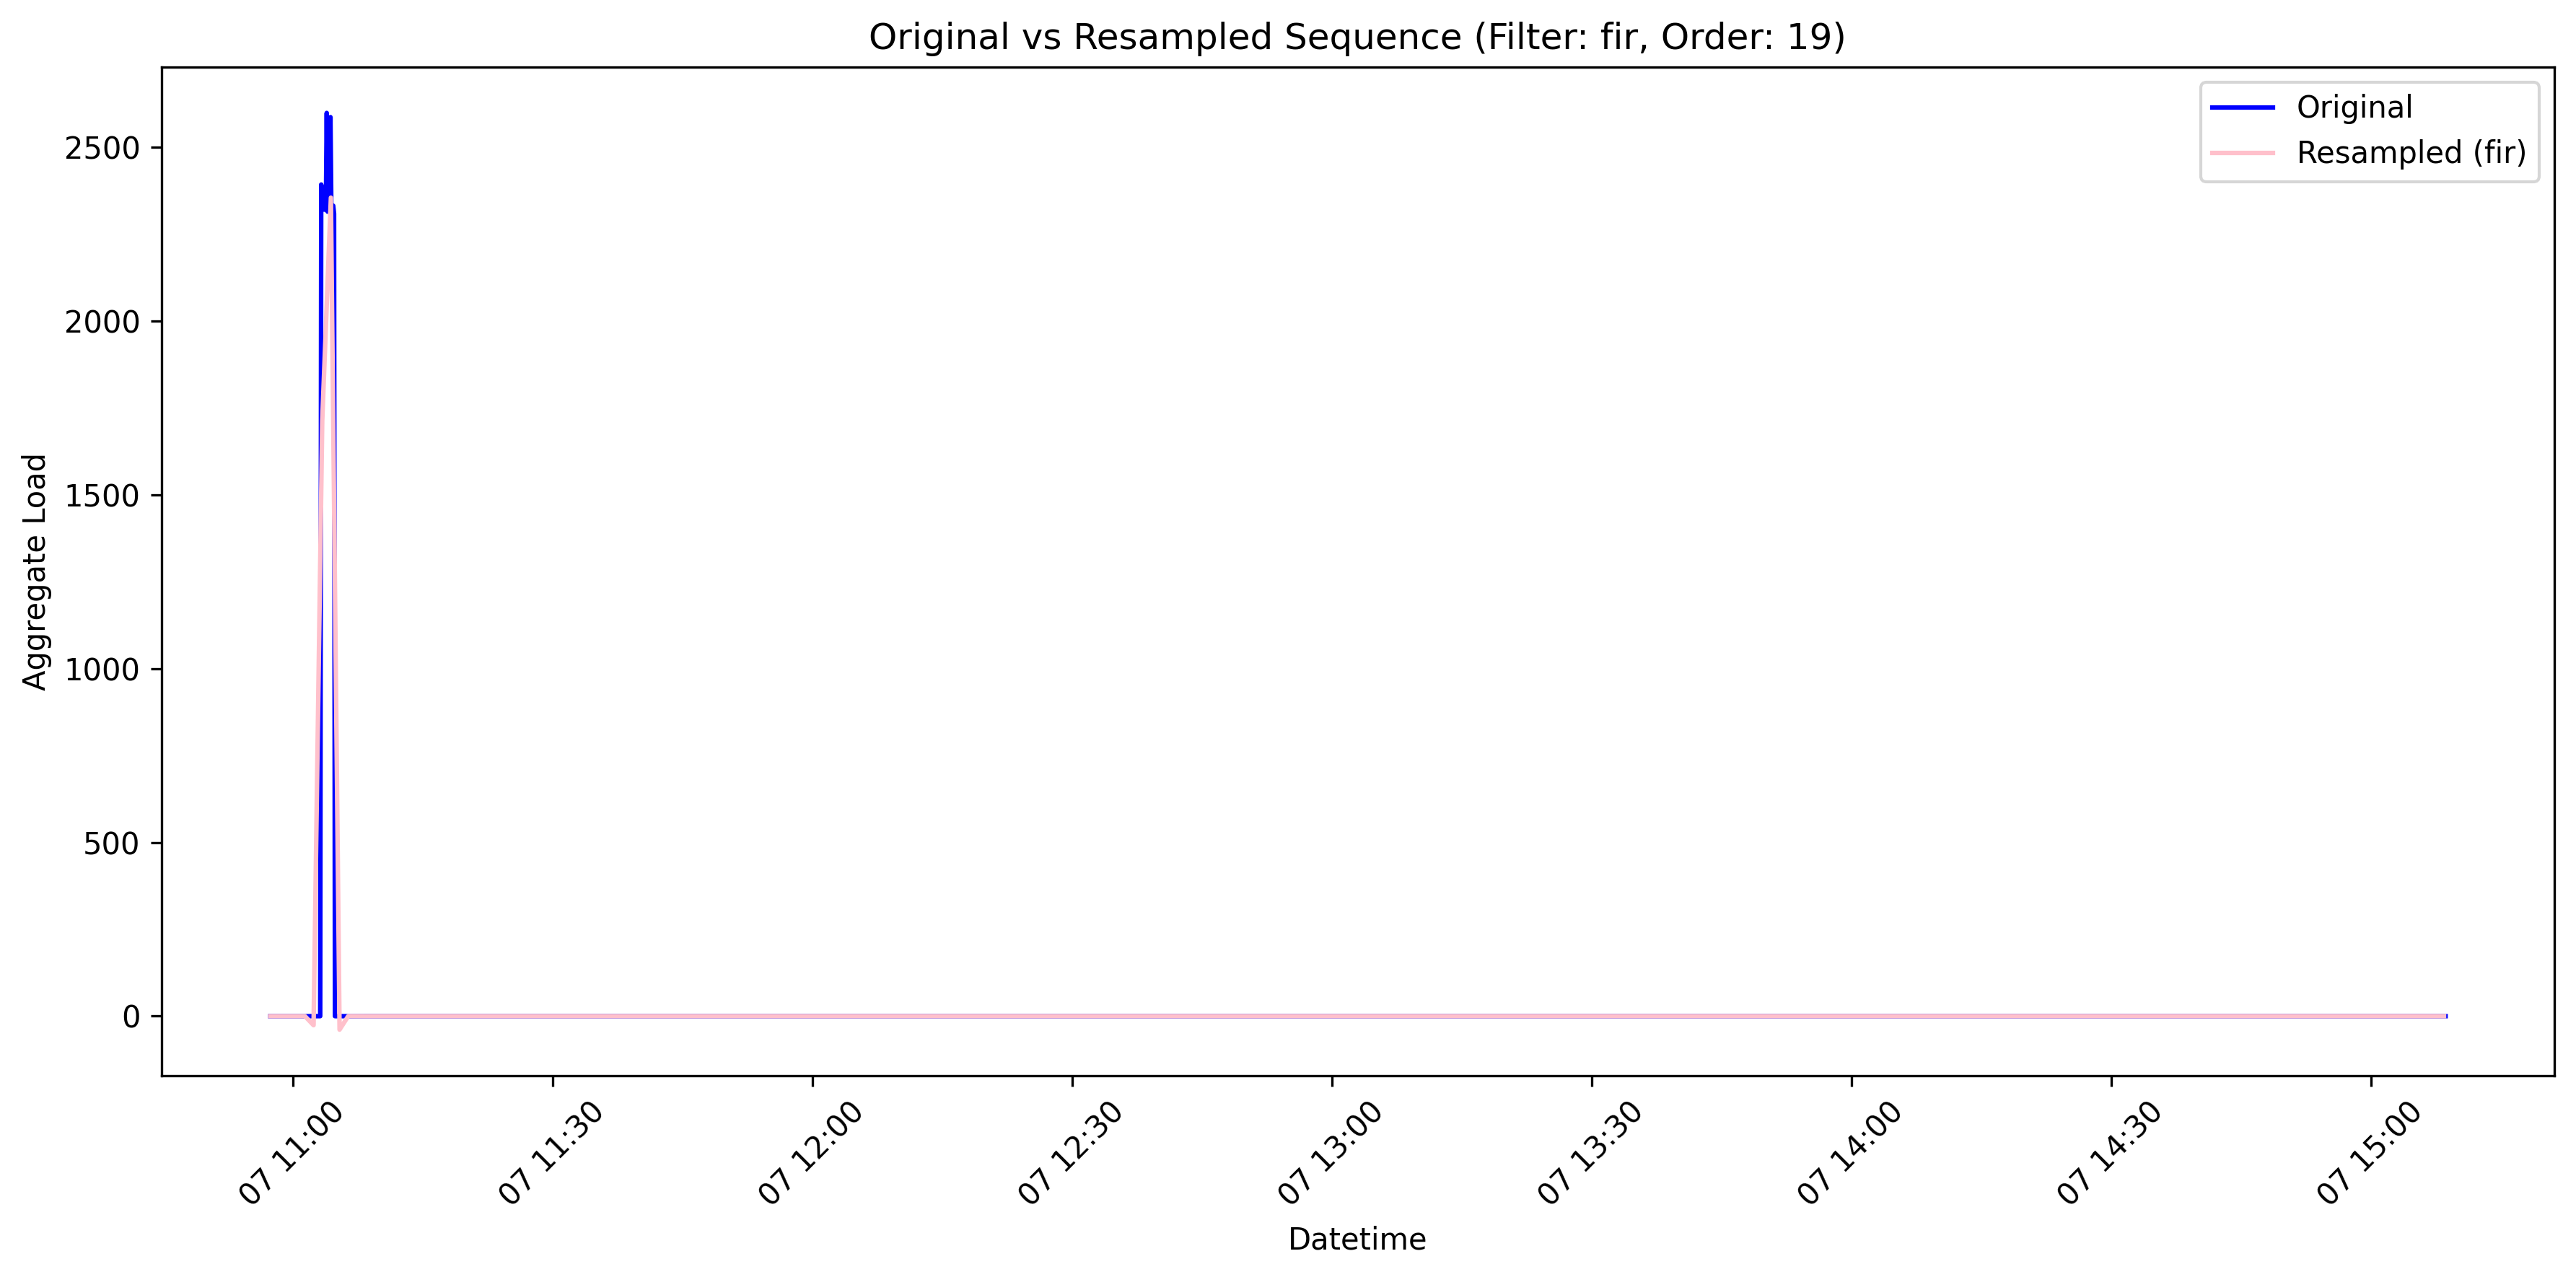

    Original points: 232
    Downsampled points: 252
    Compression ratio: 0.9x
    Original time range: 2013-06-07 10:57:23 to 2013-06-07 15:08:34
    Downsampled time range: 2013-06-07 10:57:23 to 2013-06-07 15:08:23


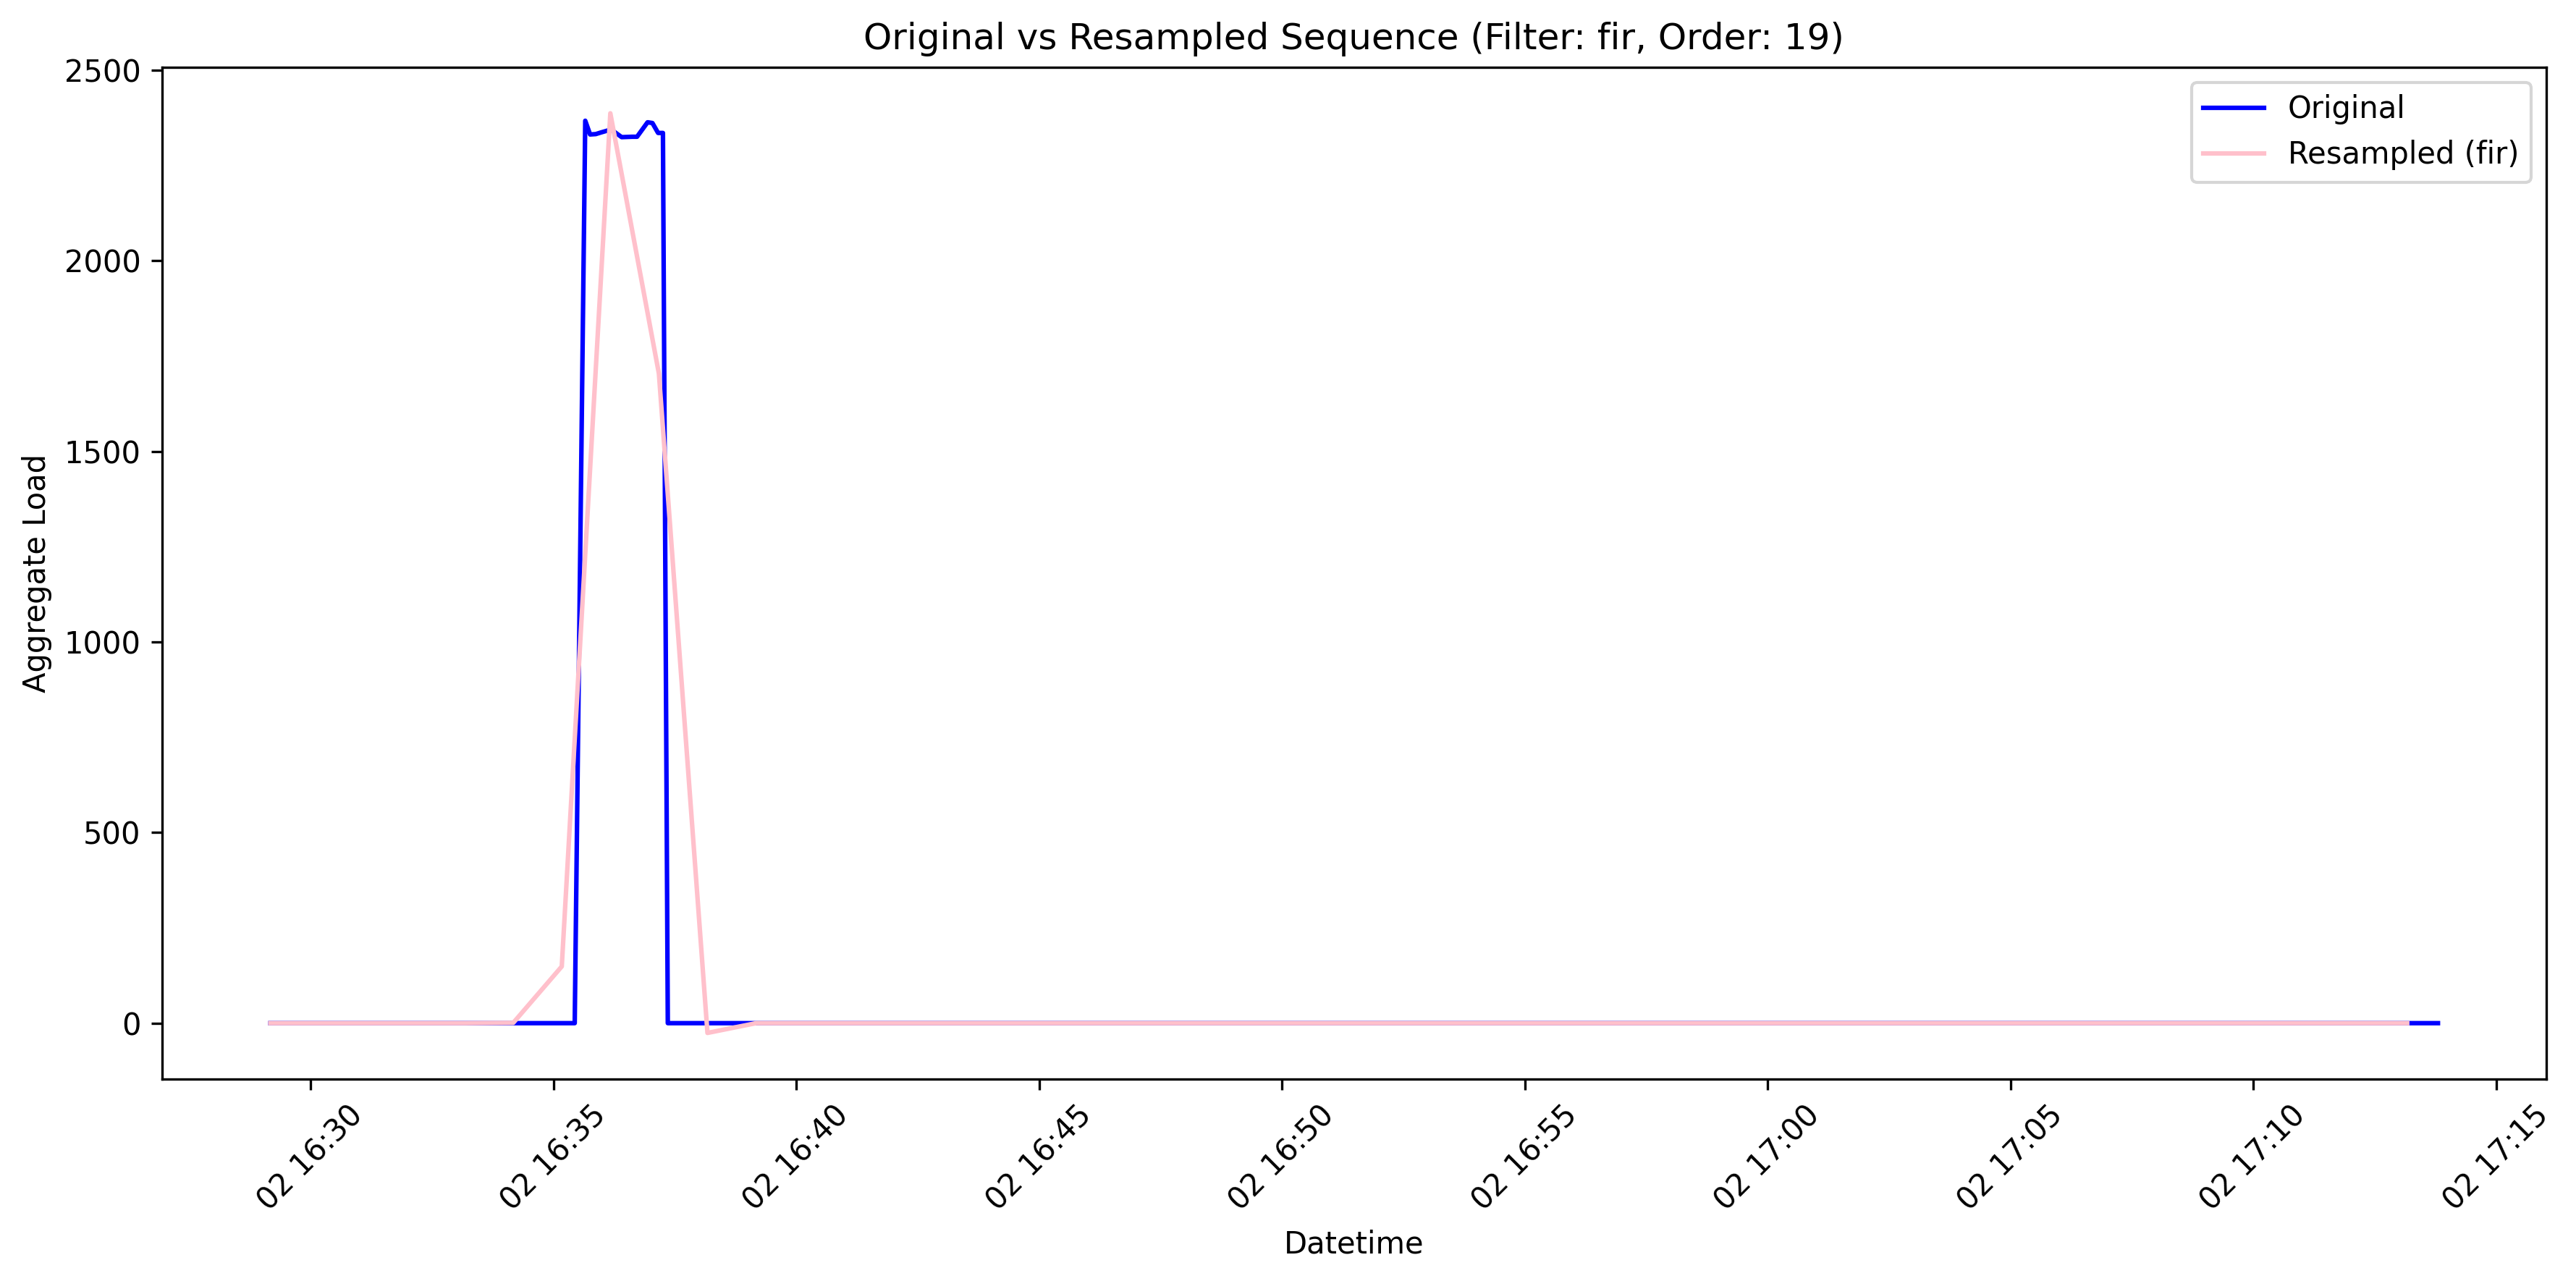

    Original points: 214
    Downsampled points: 45
    Compression ratio: 4.8x
    Original time range: 2013-08-02 16:29:10 to 2013-08-02 17:13:48
    Downsampled time range: 2013-08-02 16:29:10 to 2013-08-02 17:13:10


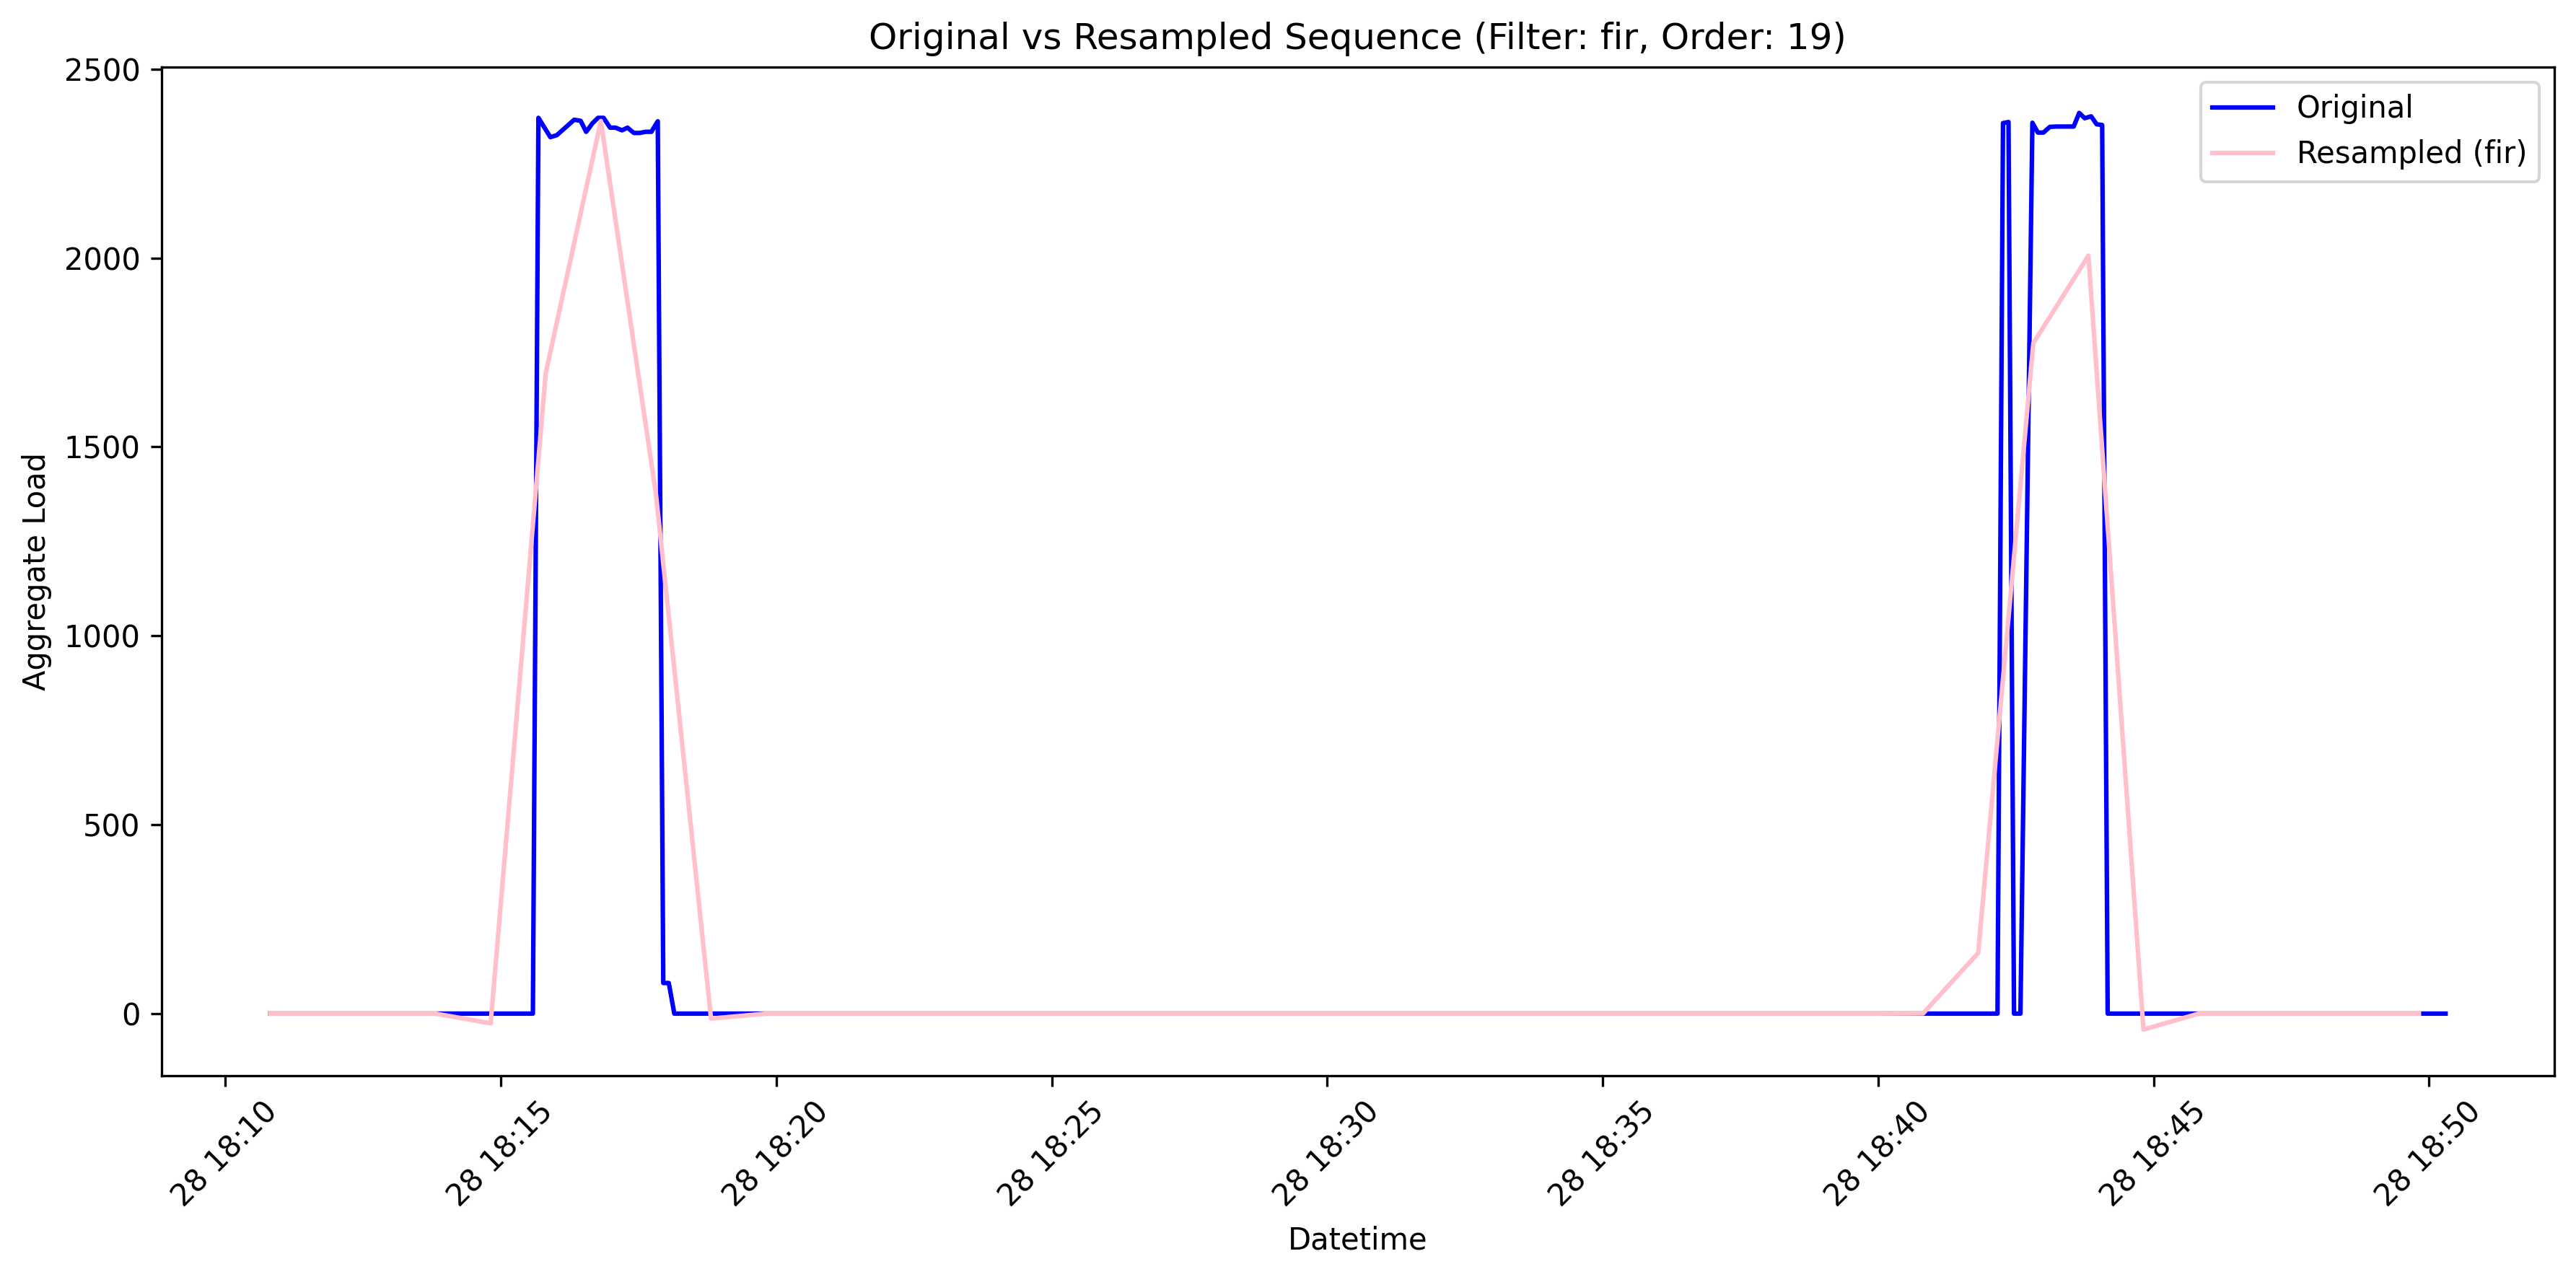

    Original points: 338
    Downsampled points: 40
    Compression ratio: 8.4x
    Original time range: 2013-10-28 18:10:49 to 2013-10-28 18:50:18
    Downsampled time range: 2013-10-28 18:10:49 to 2013-10-28 18:49:49


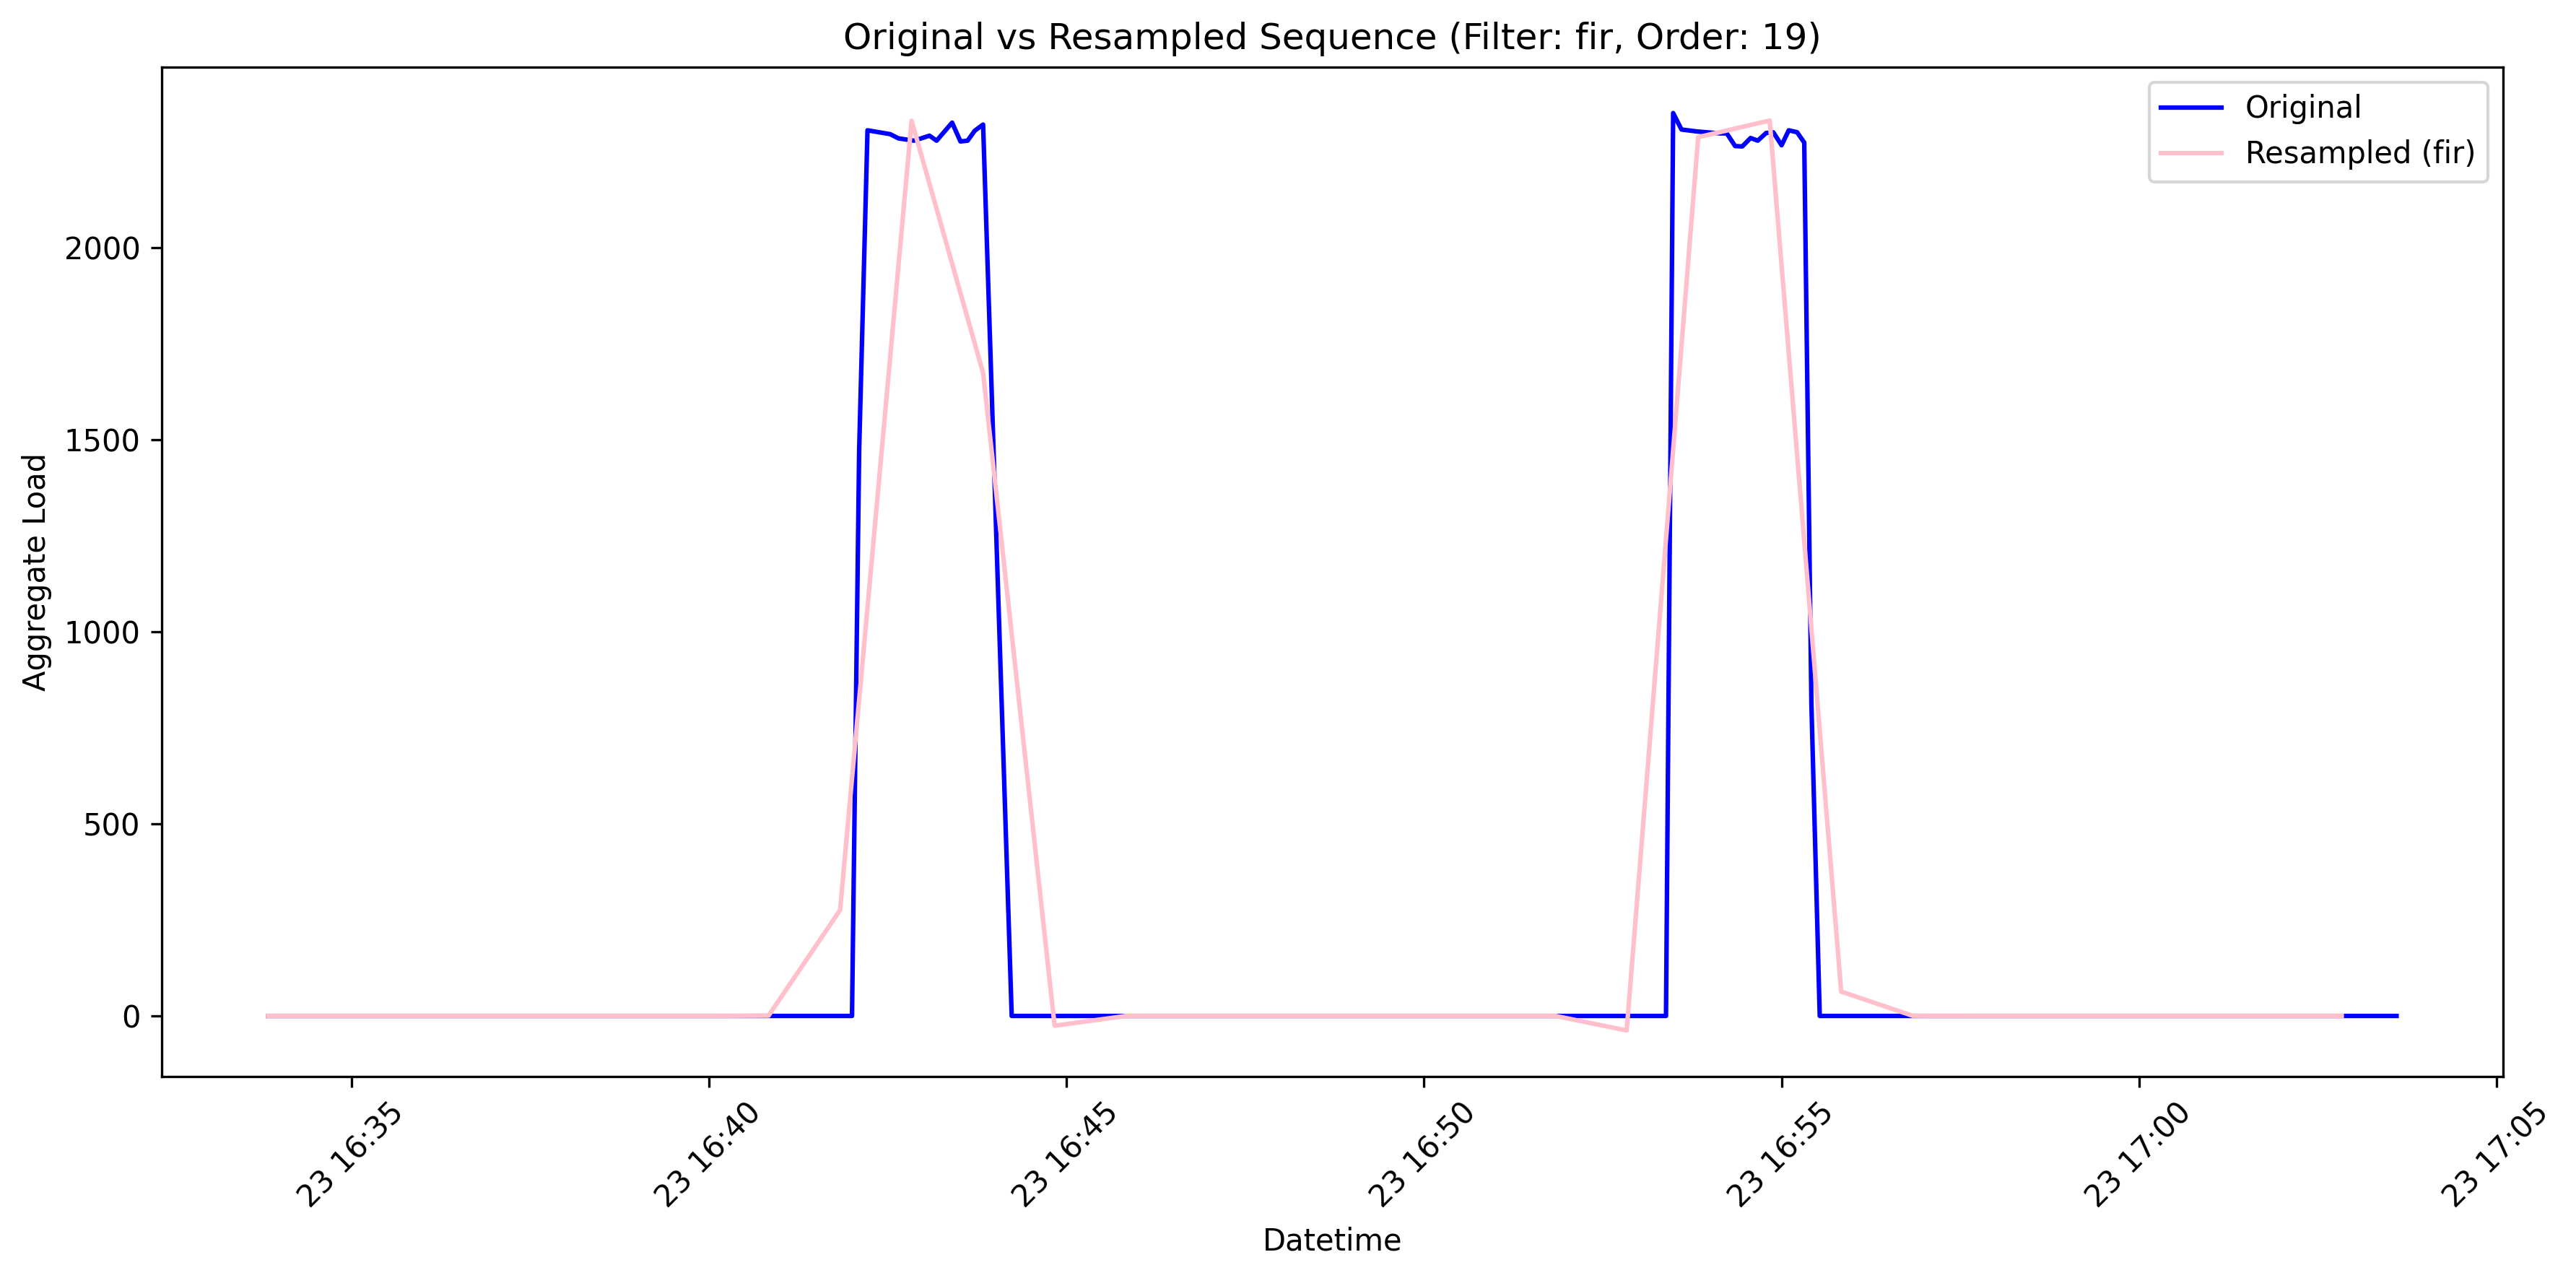

    Original points: 277
    Downsampled points: 30
    Compression ratio: 9.2x
    Original time range: 2013-03-23 16:33:50 to 2013-03-23 17:03:36
    Downsampled time range: 2013-03-23 16:33:50 to 2013-03-23 17:02:50

WASHING_MACHINE Signature Comparison:


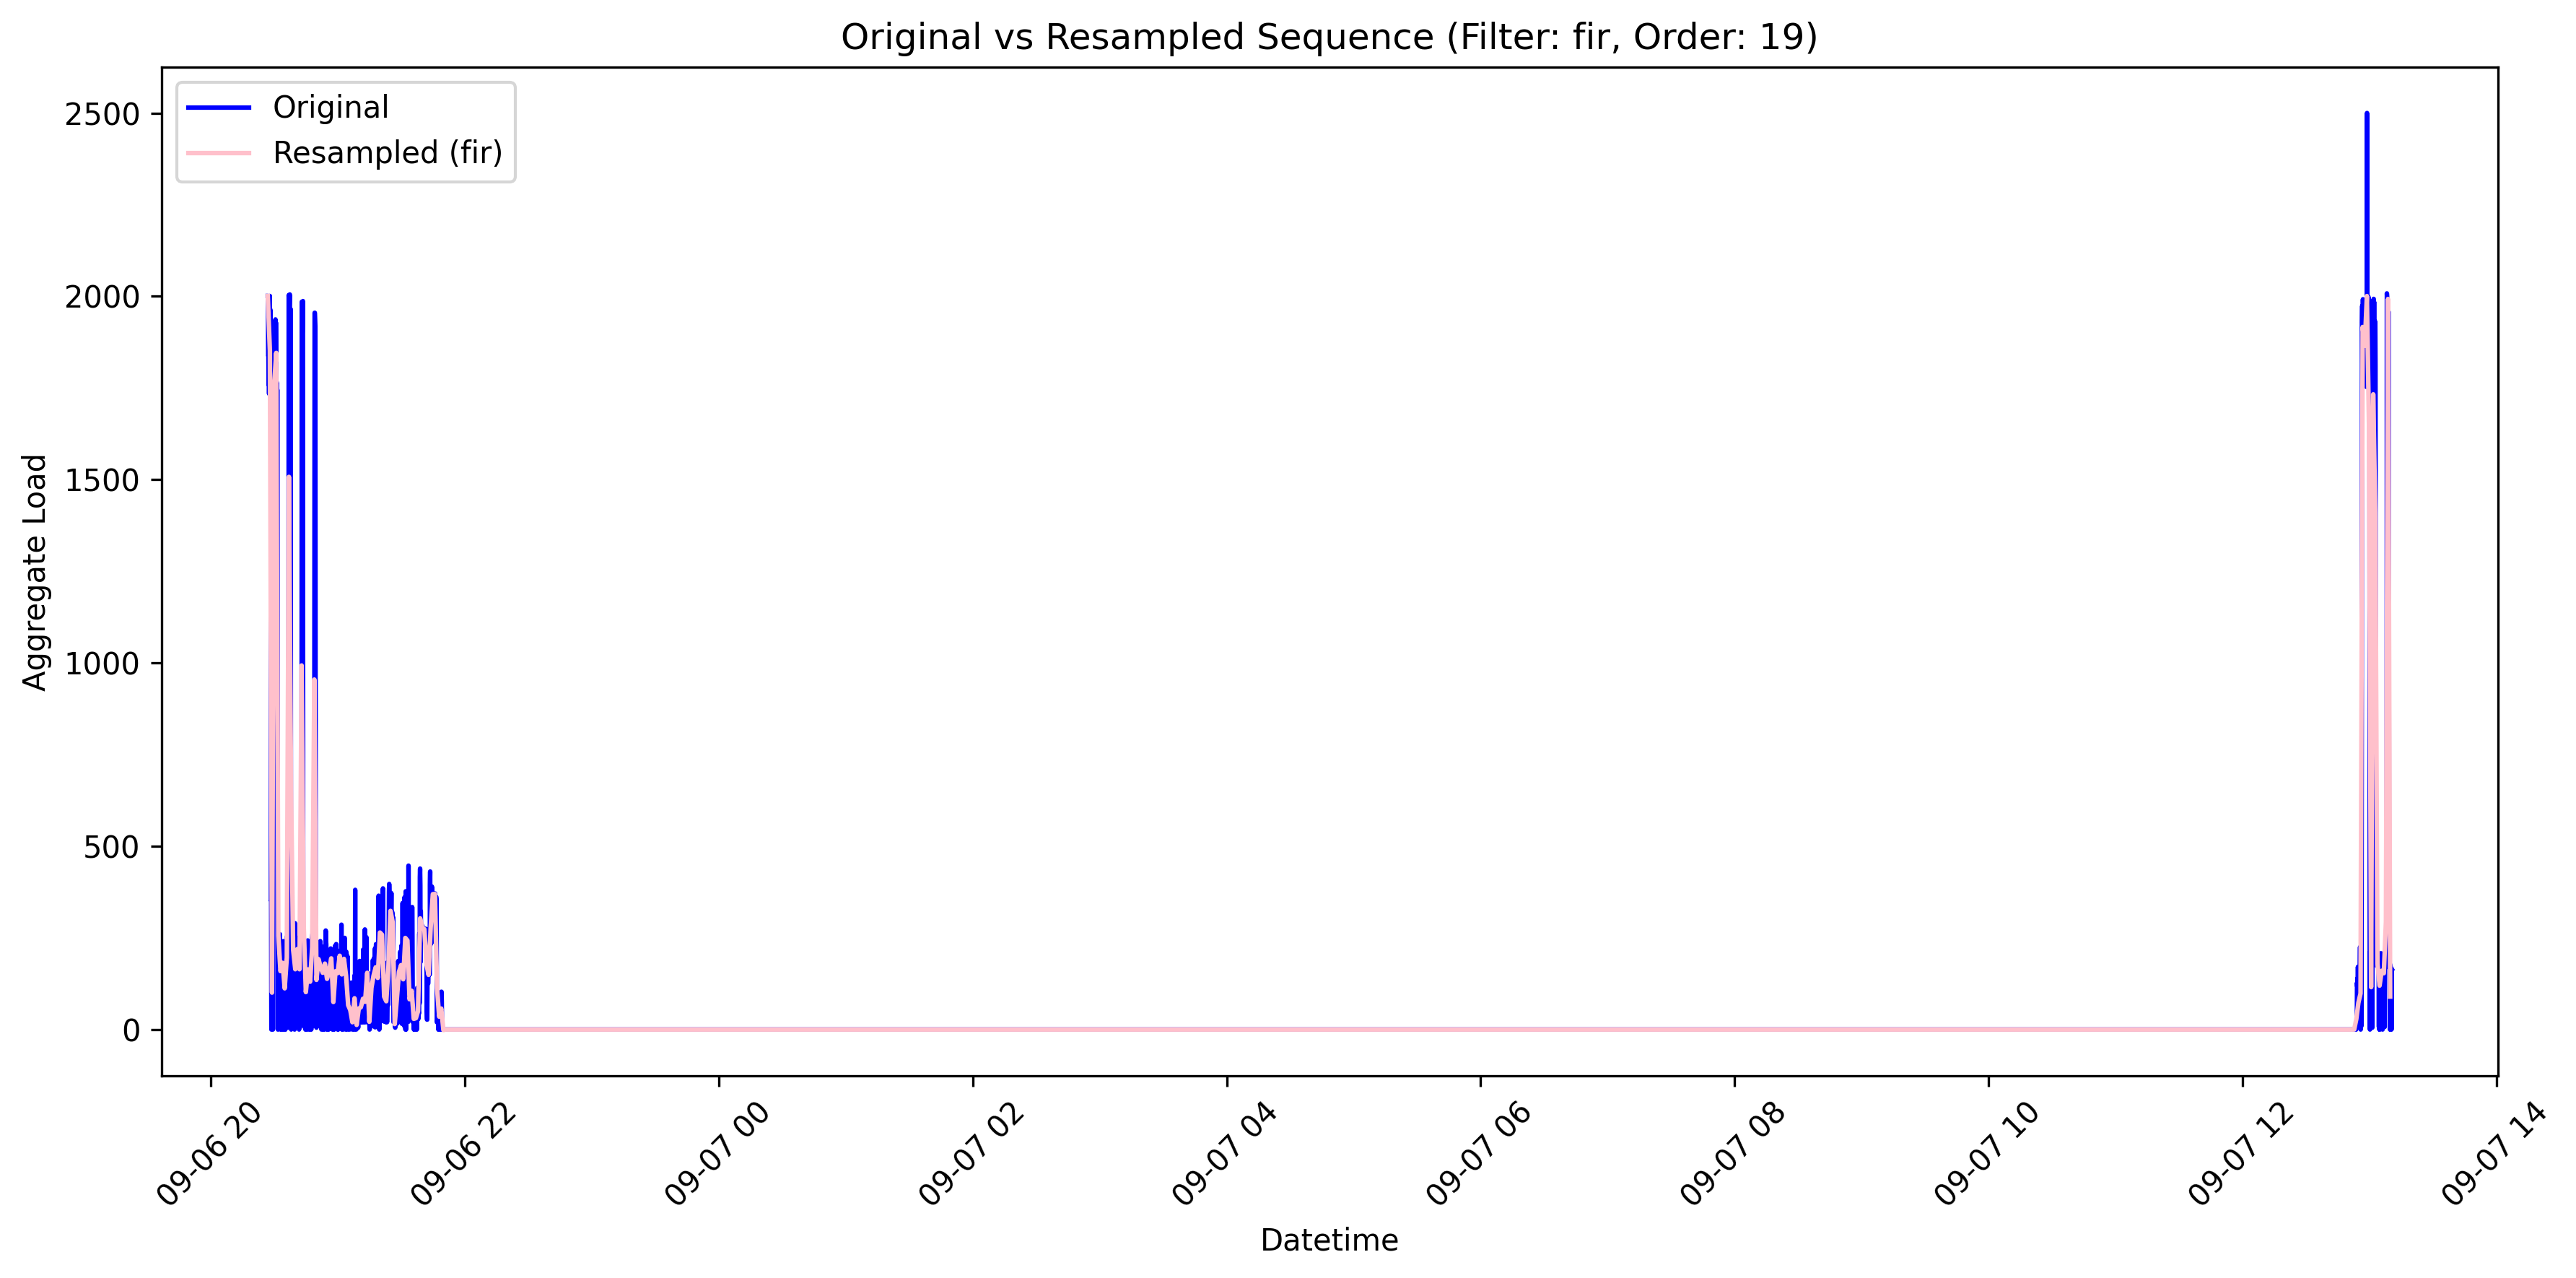

    Original points: 1090
    Downsampled points: 1004
    Compression ratio: 1.1x
    Original time range: 2013-09-06 20:26:48 to 2013-09-07 13:10:39
    Downsampled time range: 2013-09-06 20:26:48 to 2013-09-07 13:09:48


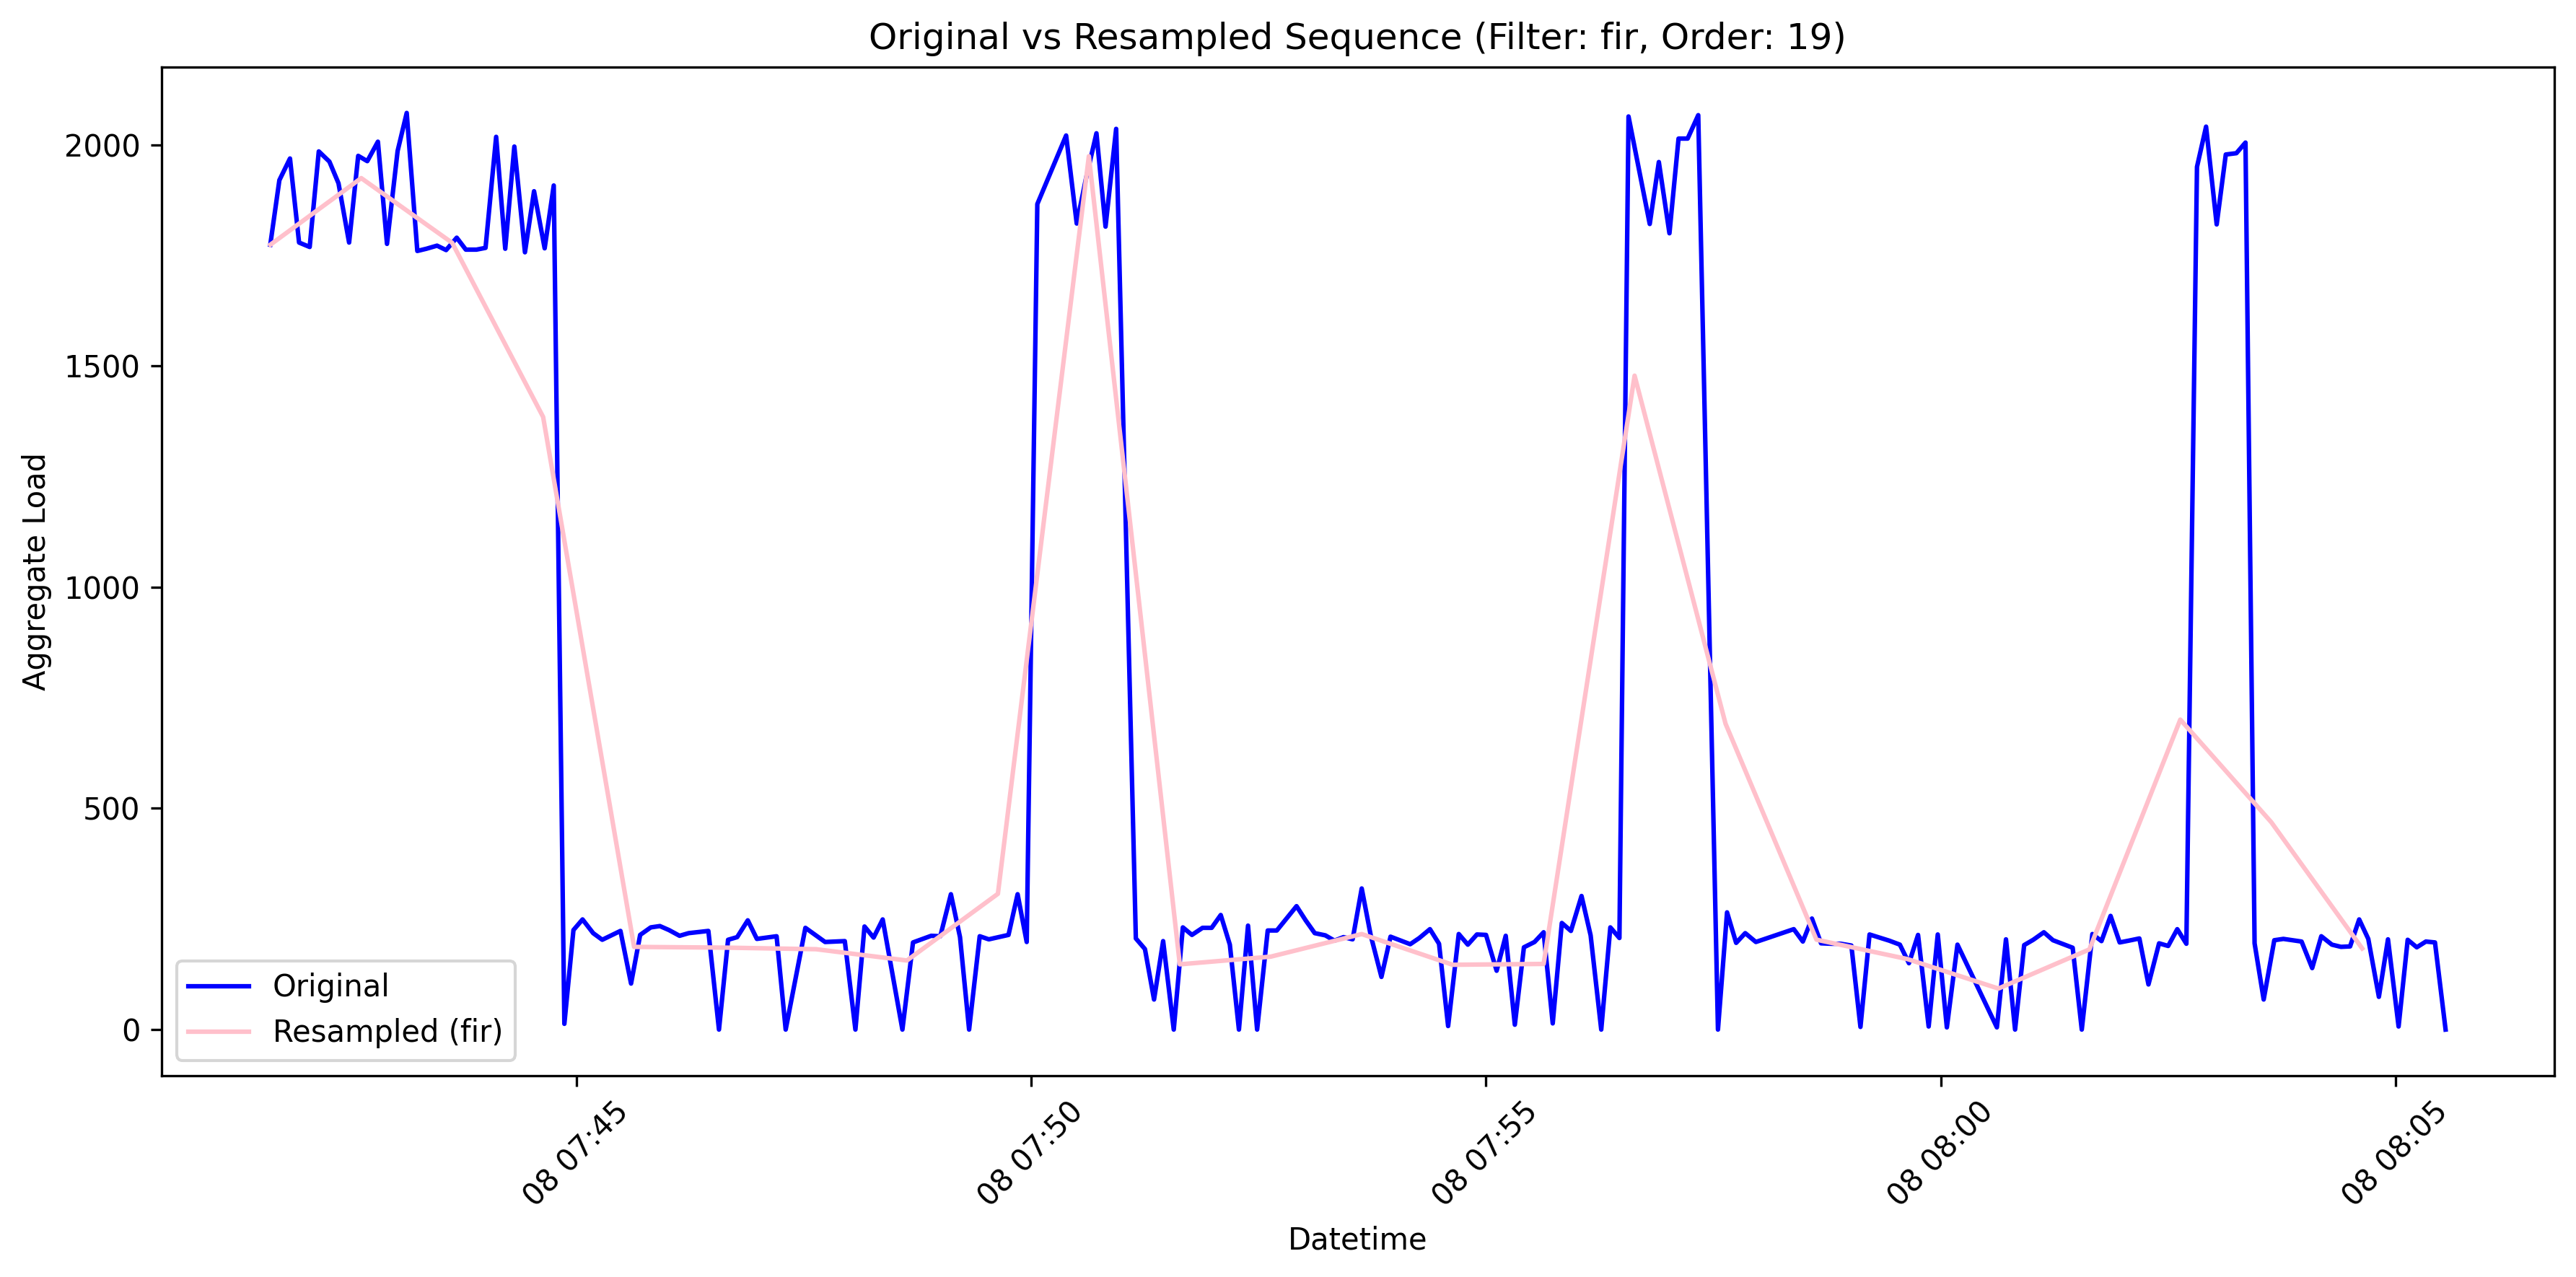

    Original points: 202
    Downsampled points: 24
    Compression ratio: 8.4x
    Original time range: 2013-04-08 07:41:38 to 2013-04-08 08:05:33
    Downsampled time range: 2013-04-08 07:41:38 to 2013-04-08 08:04:38


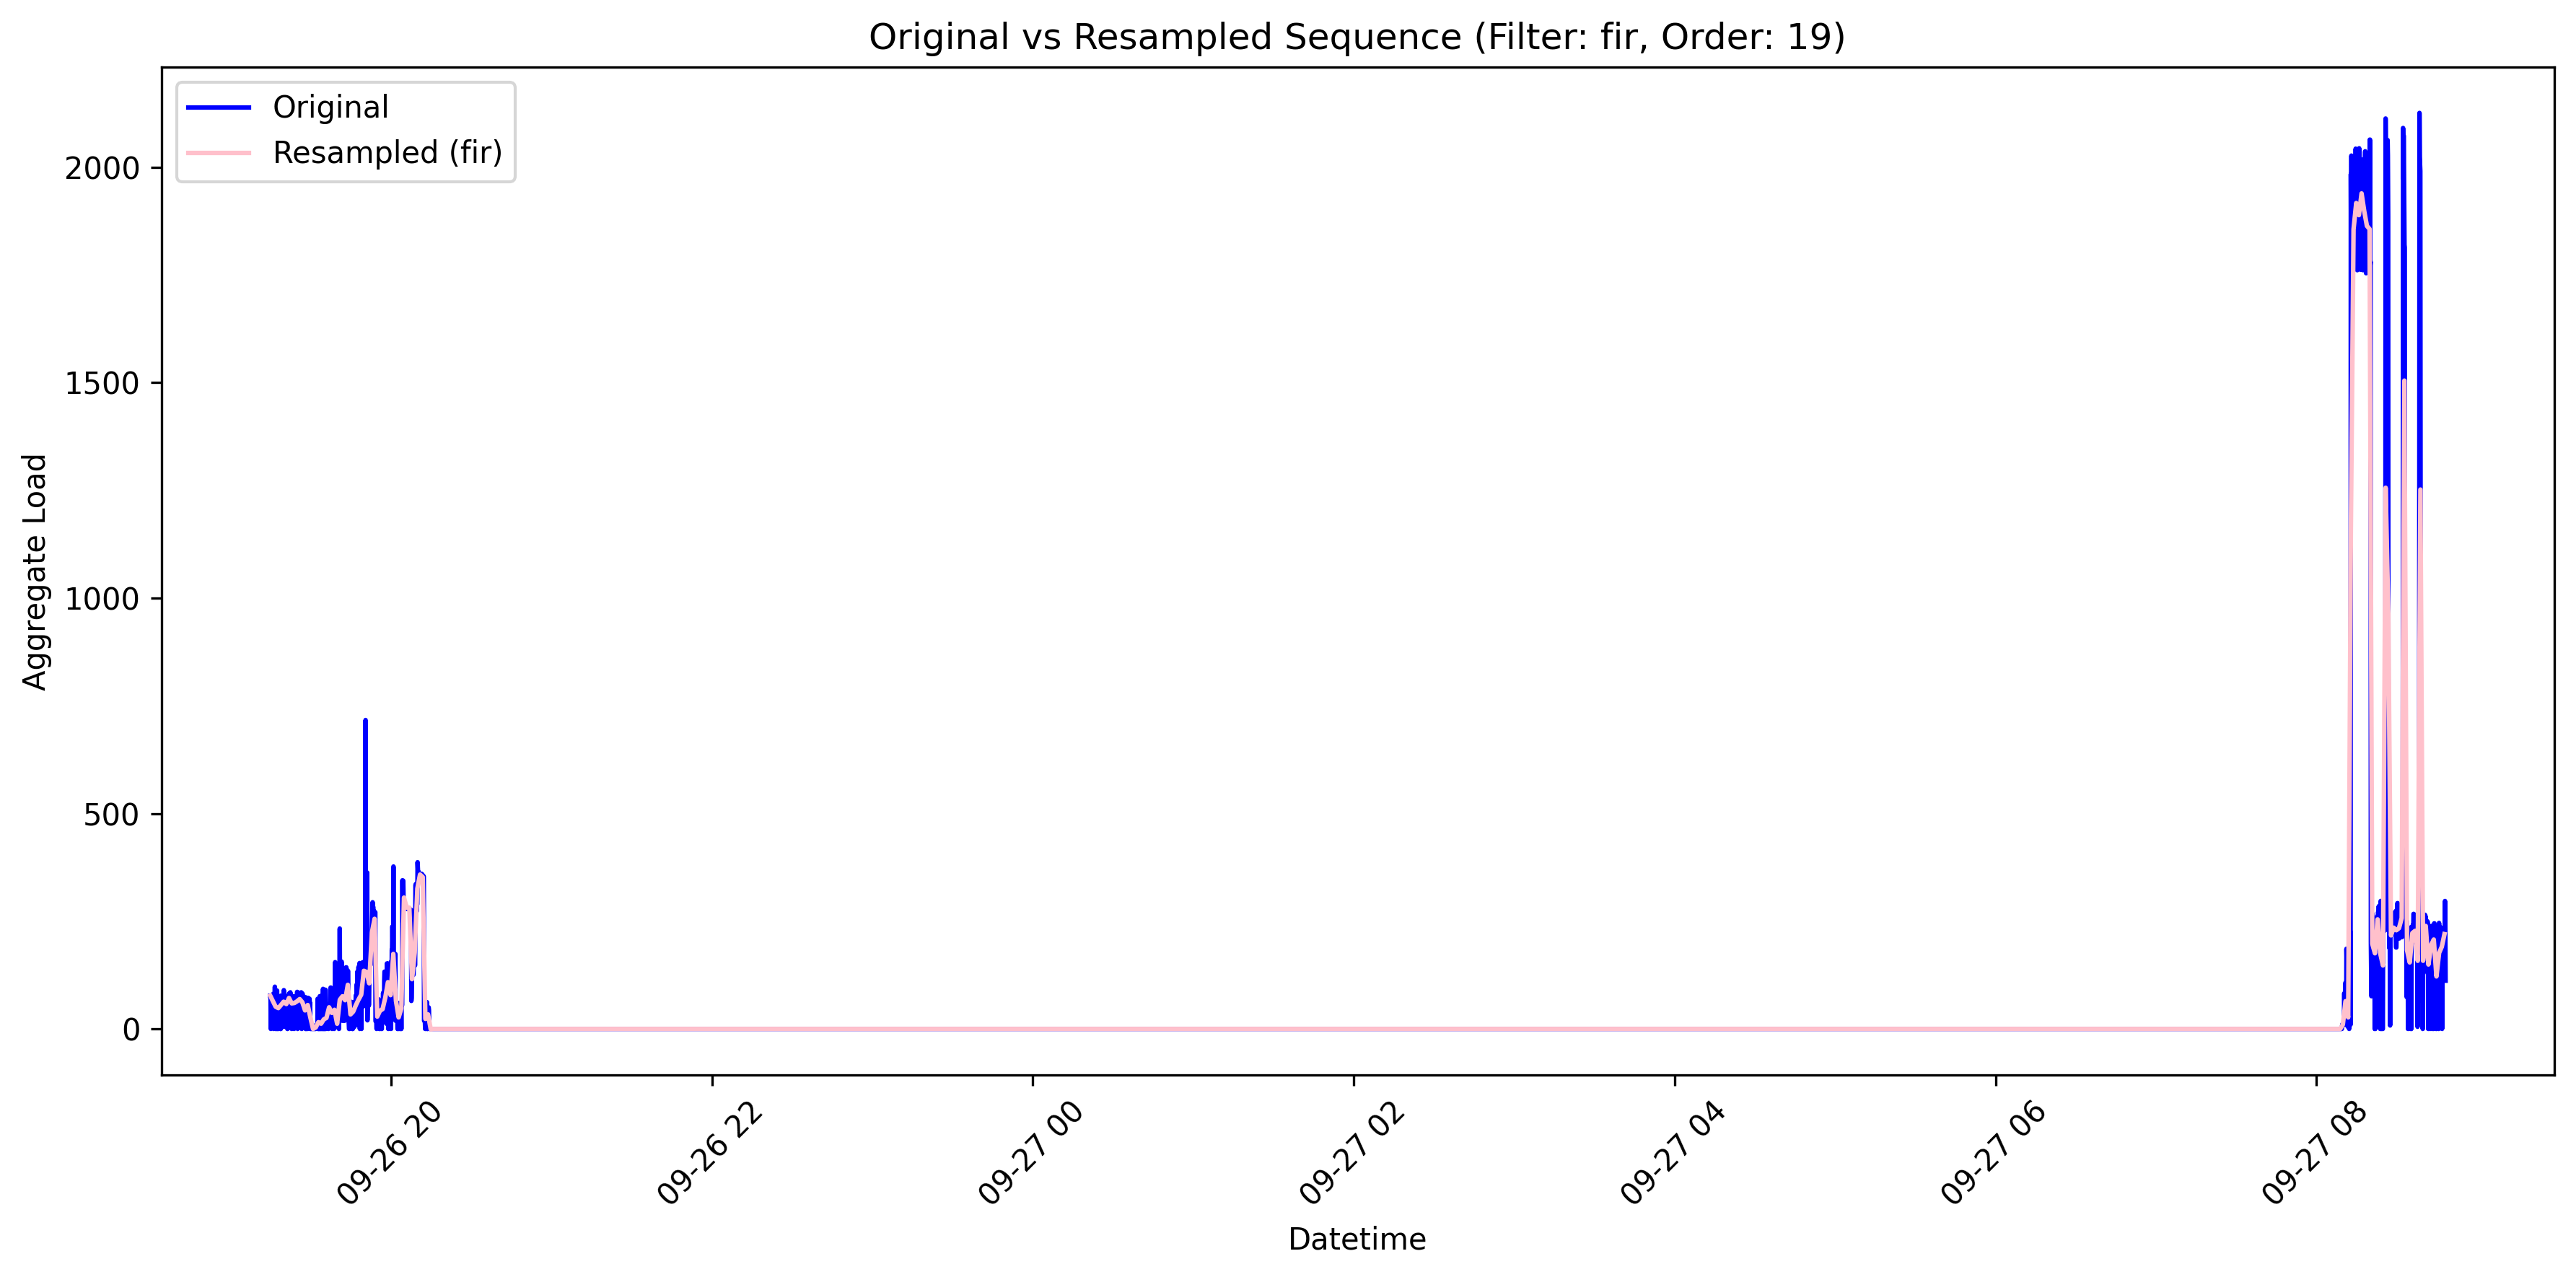

    Original points: 1134
    Downsampled points: 814
    Compression ratio: 1.4x
    Original time range: 2013-09-26 19:14:52 to 2013-09-27 08:48:17
    Downsampled time range: 2013-09-26 19:14:52 to 2013-09-27 08:47:52


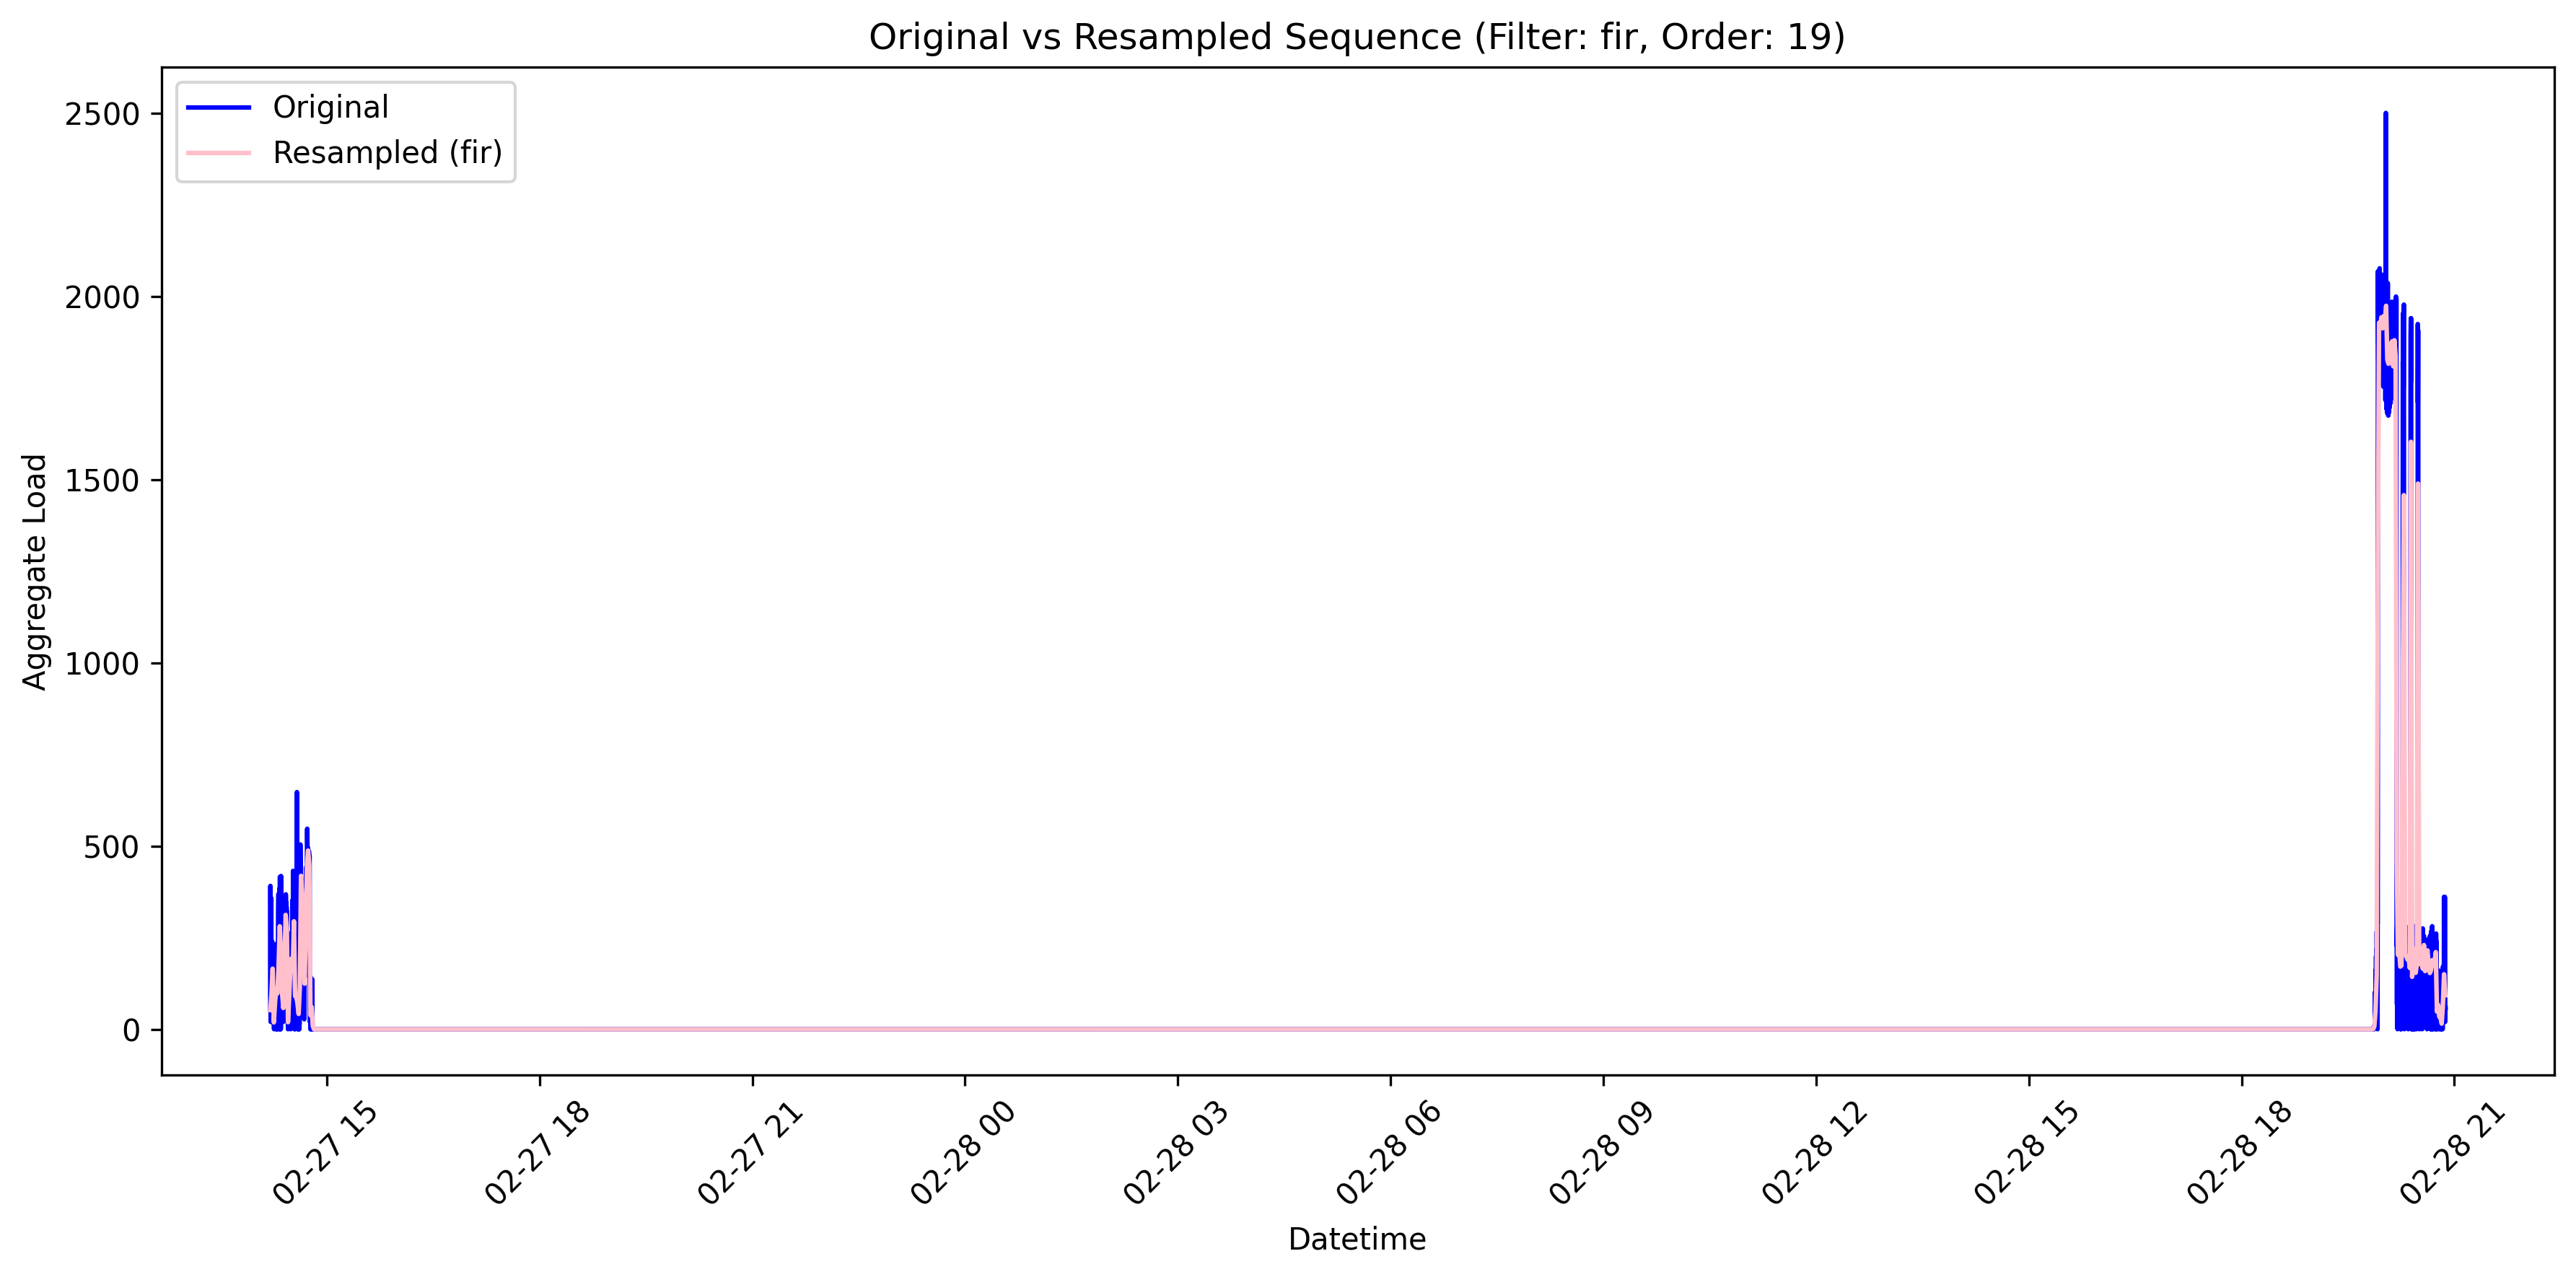

    Original points: 1061
    Downsampled points: 1841
    Compression ratio: 0.6x
    Original time range: 2013-02-27 14:12:15 to 2013-02-28 20:52:33
    Downsampled time range: 2013-02-27 14:12:15 to 2013-02-28 20:52:15


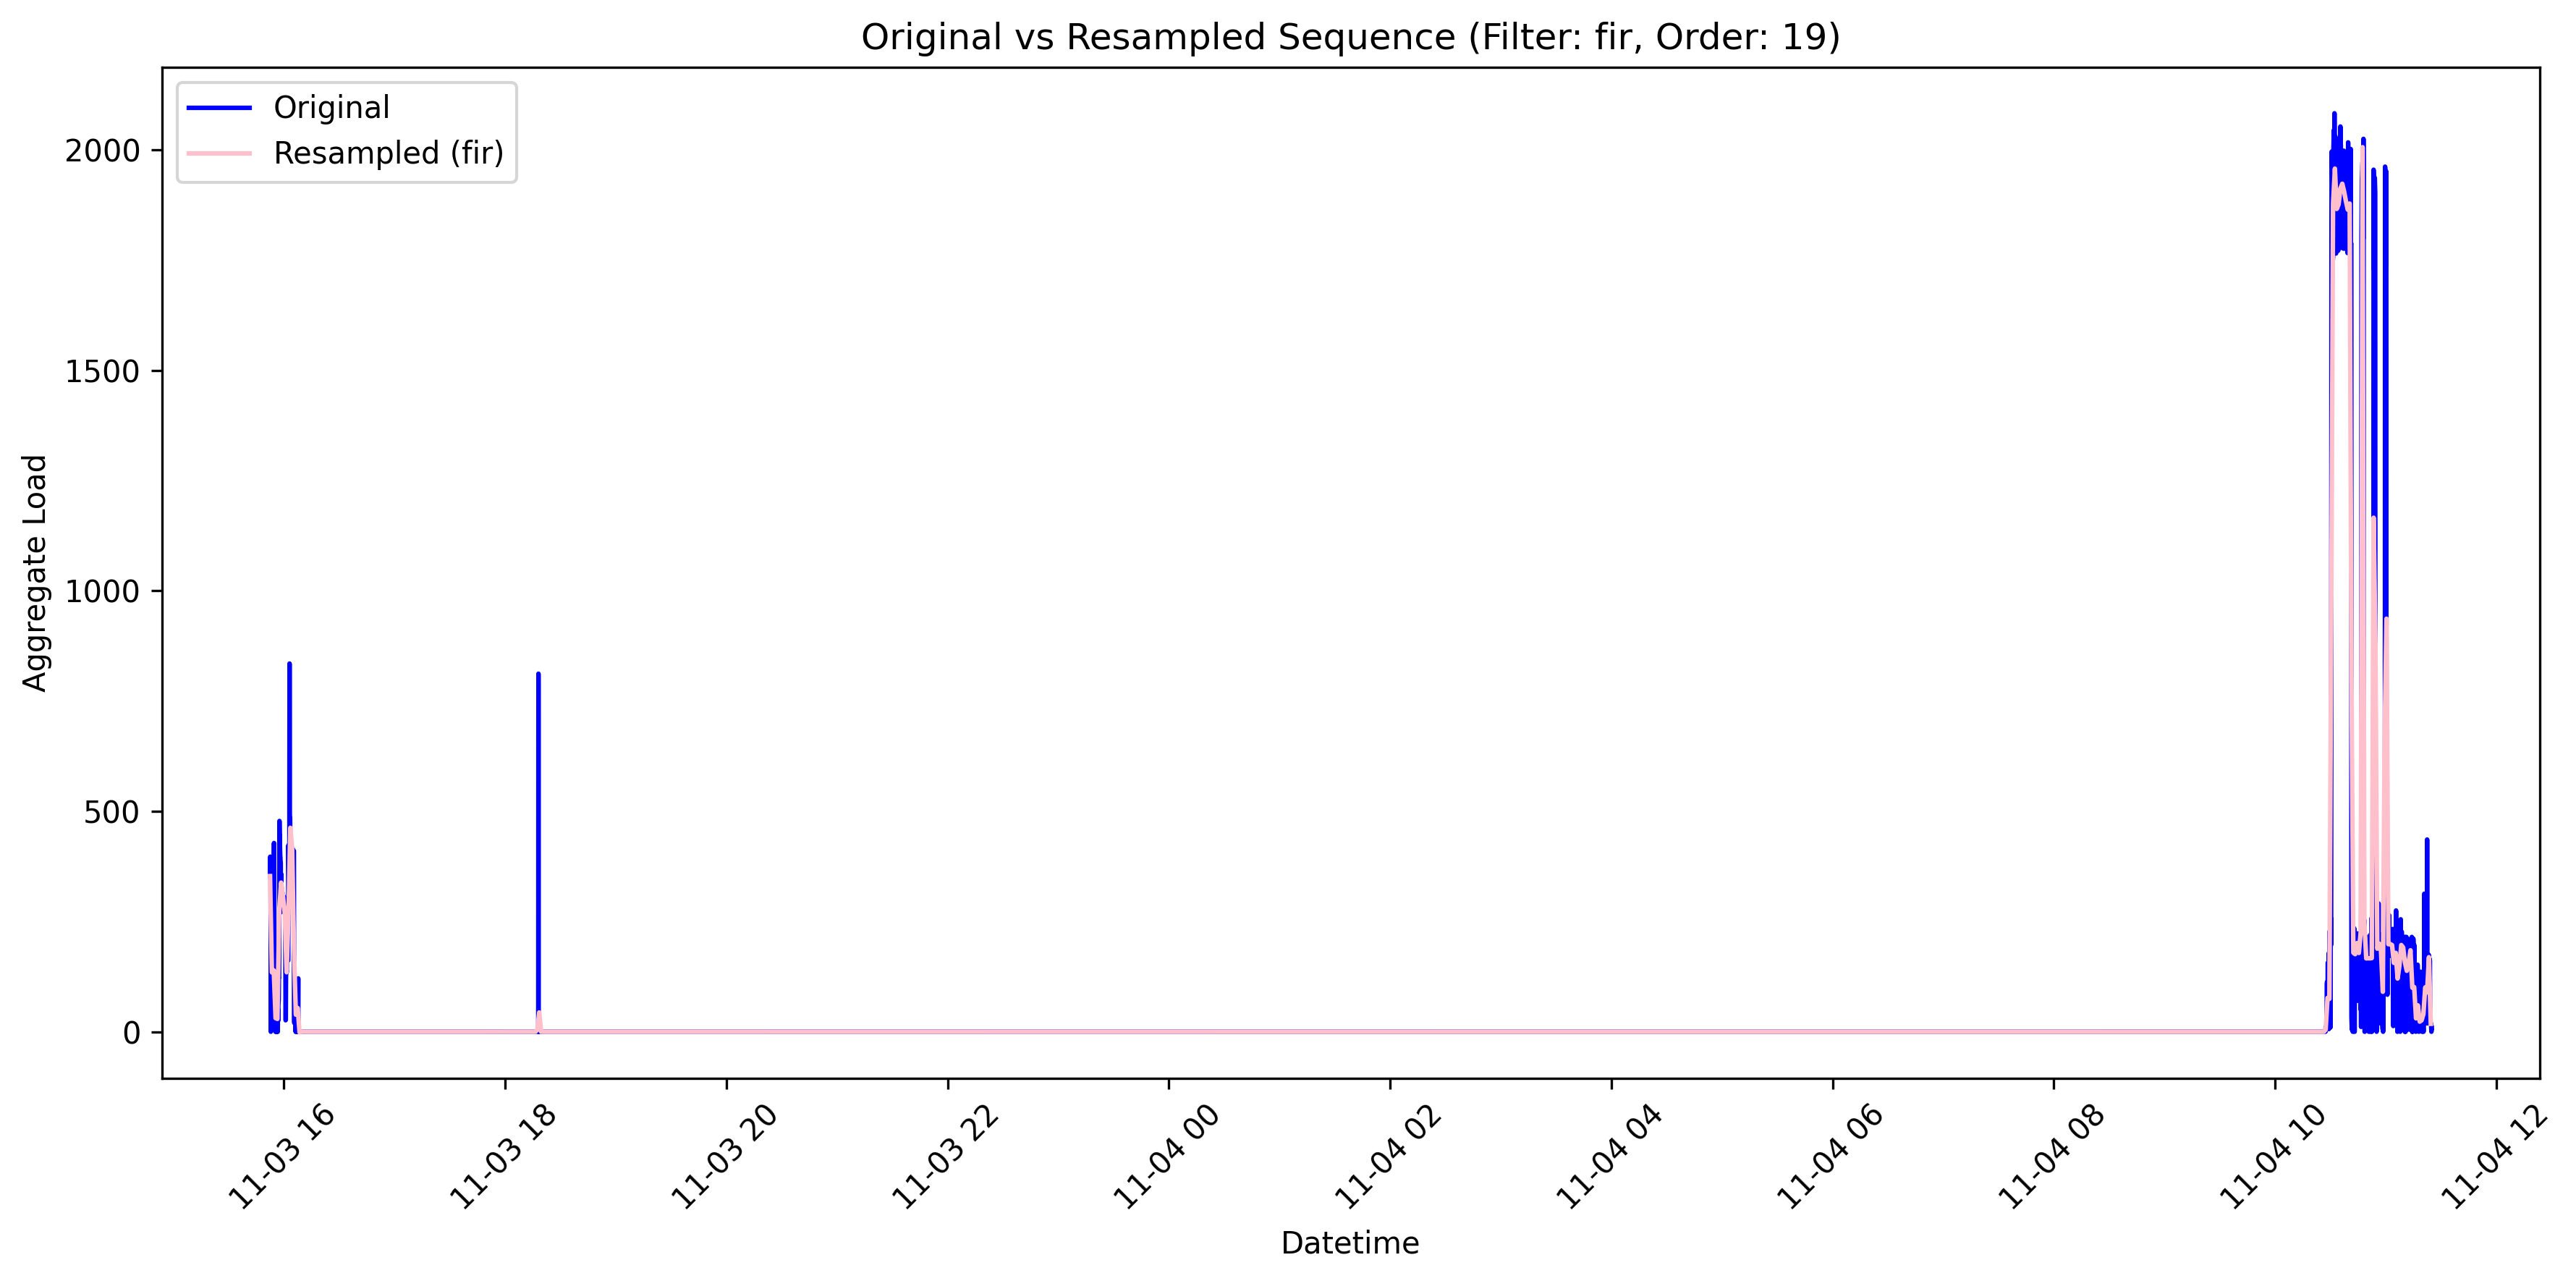

    Original points: 1069
    Downsampled points: 1173
    Compression ratio: 0.9x
    Original time range: 2013-11-03 15:52:26 to 2013-11-04 11:24:59
    Downsampled time range: 2013-11-03 15:52:26 to 2013-11-04 11:24:26

DISHWASHER Signature Comparison:


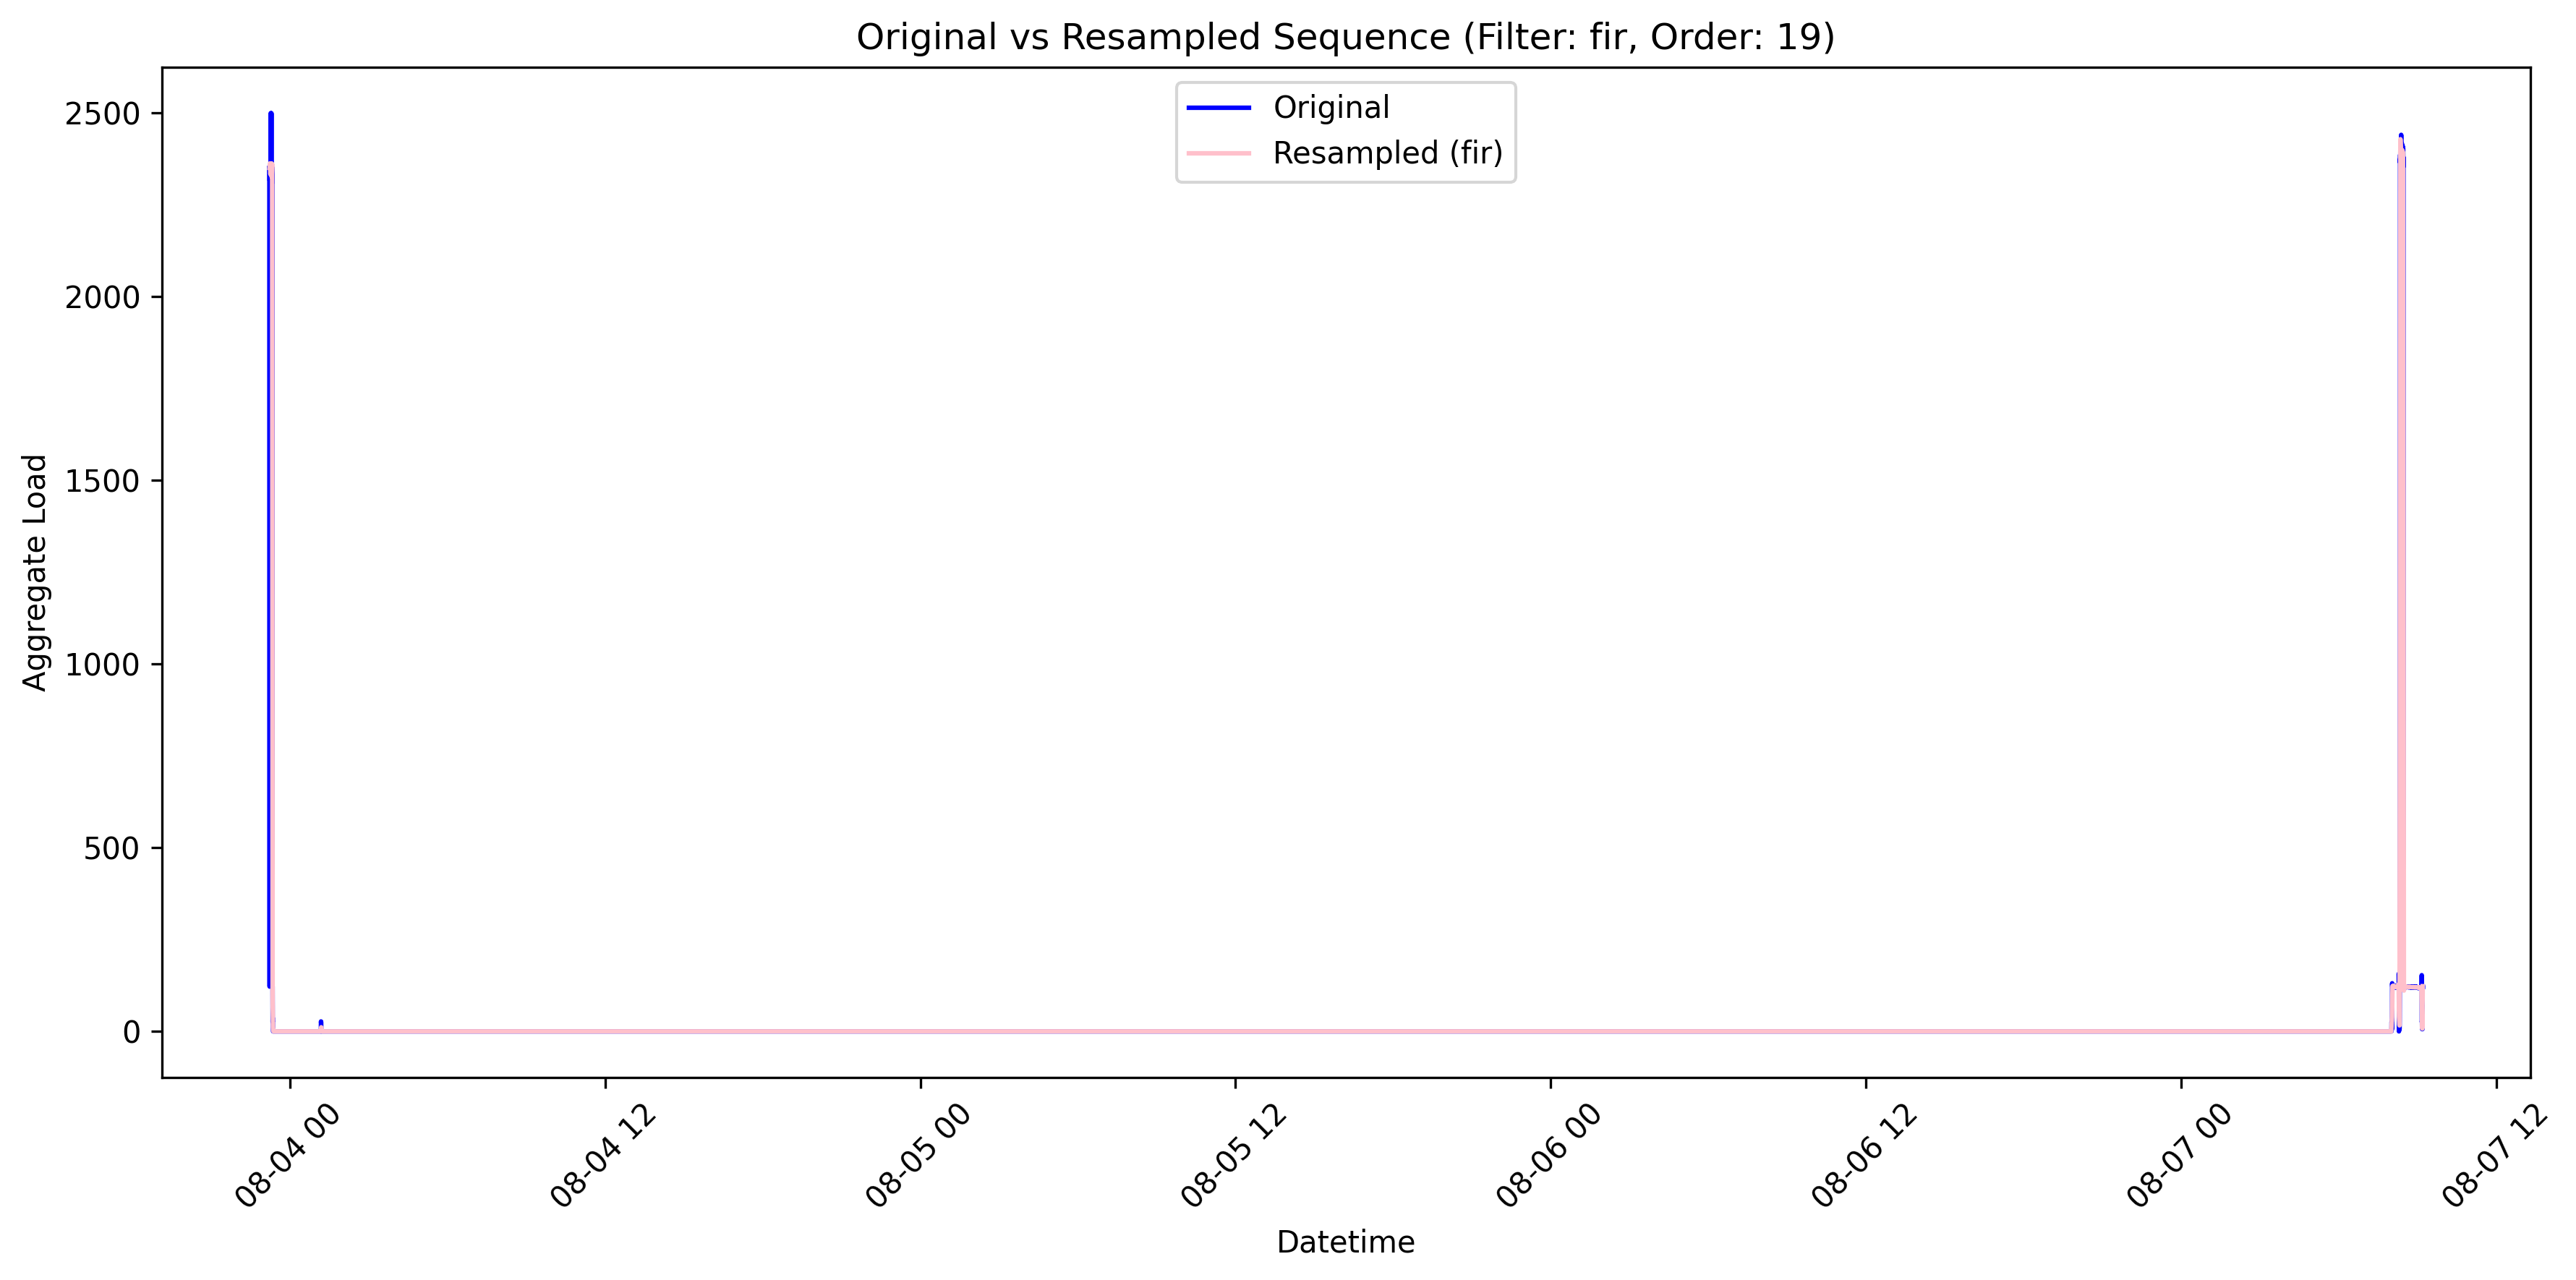

    Original points: 1173
    Downsampled points: 4919
    Compression ratio: 0.2x
    Original time range: 2013-08-03 23:13:40 to 2013-08-07 09:12:22
    Downsampled time range: 2013-08-03 23:13:40 to 2013-08-07 09:11:40


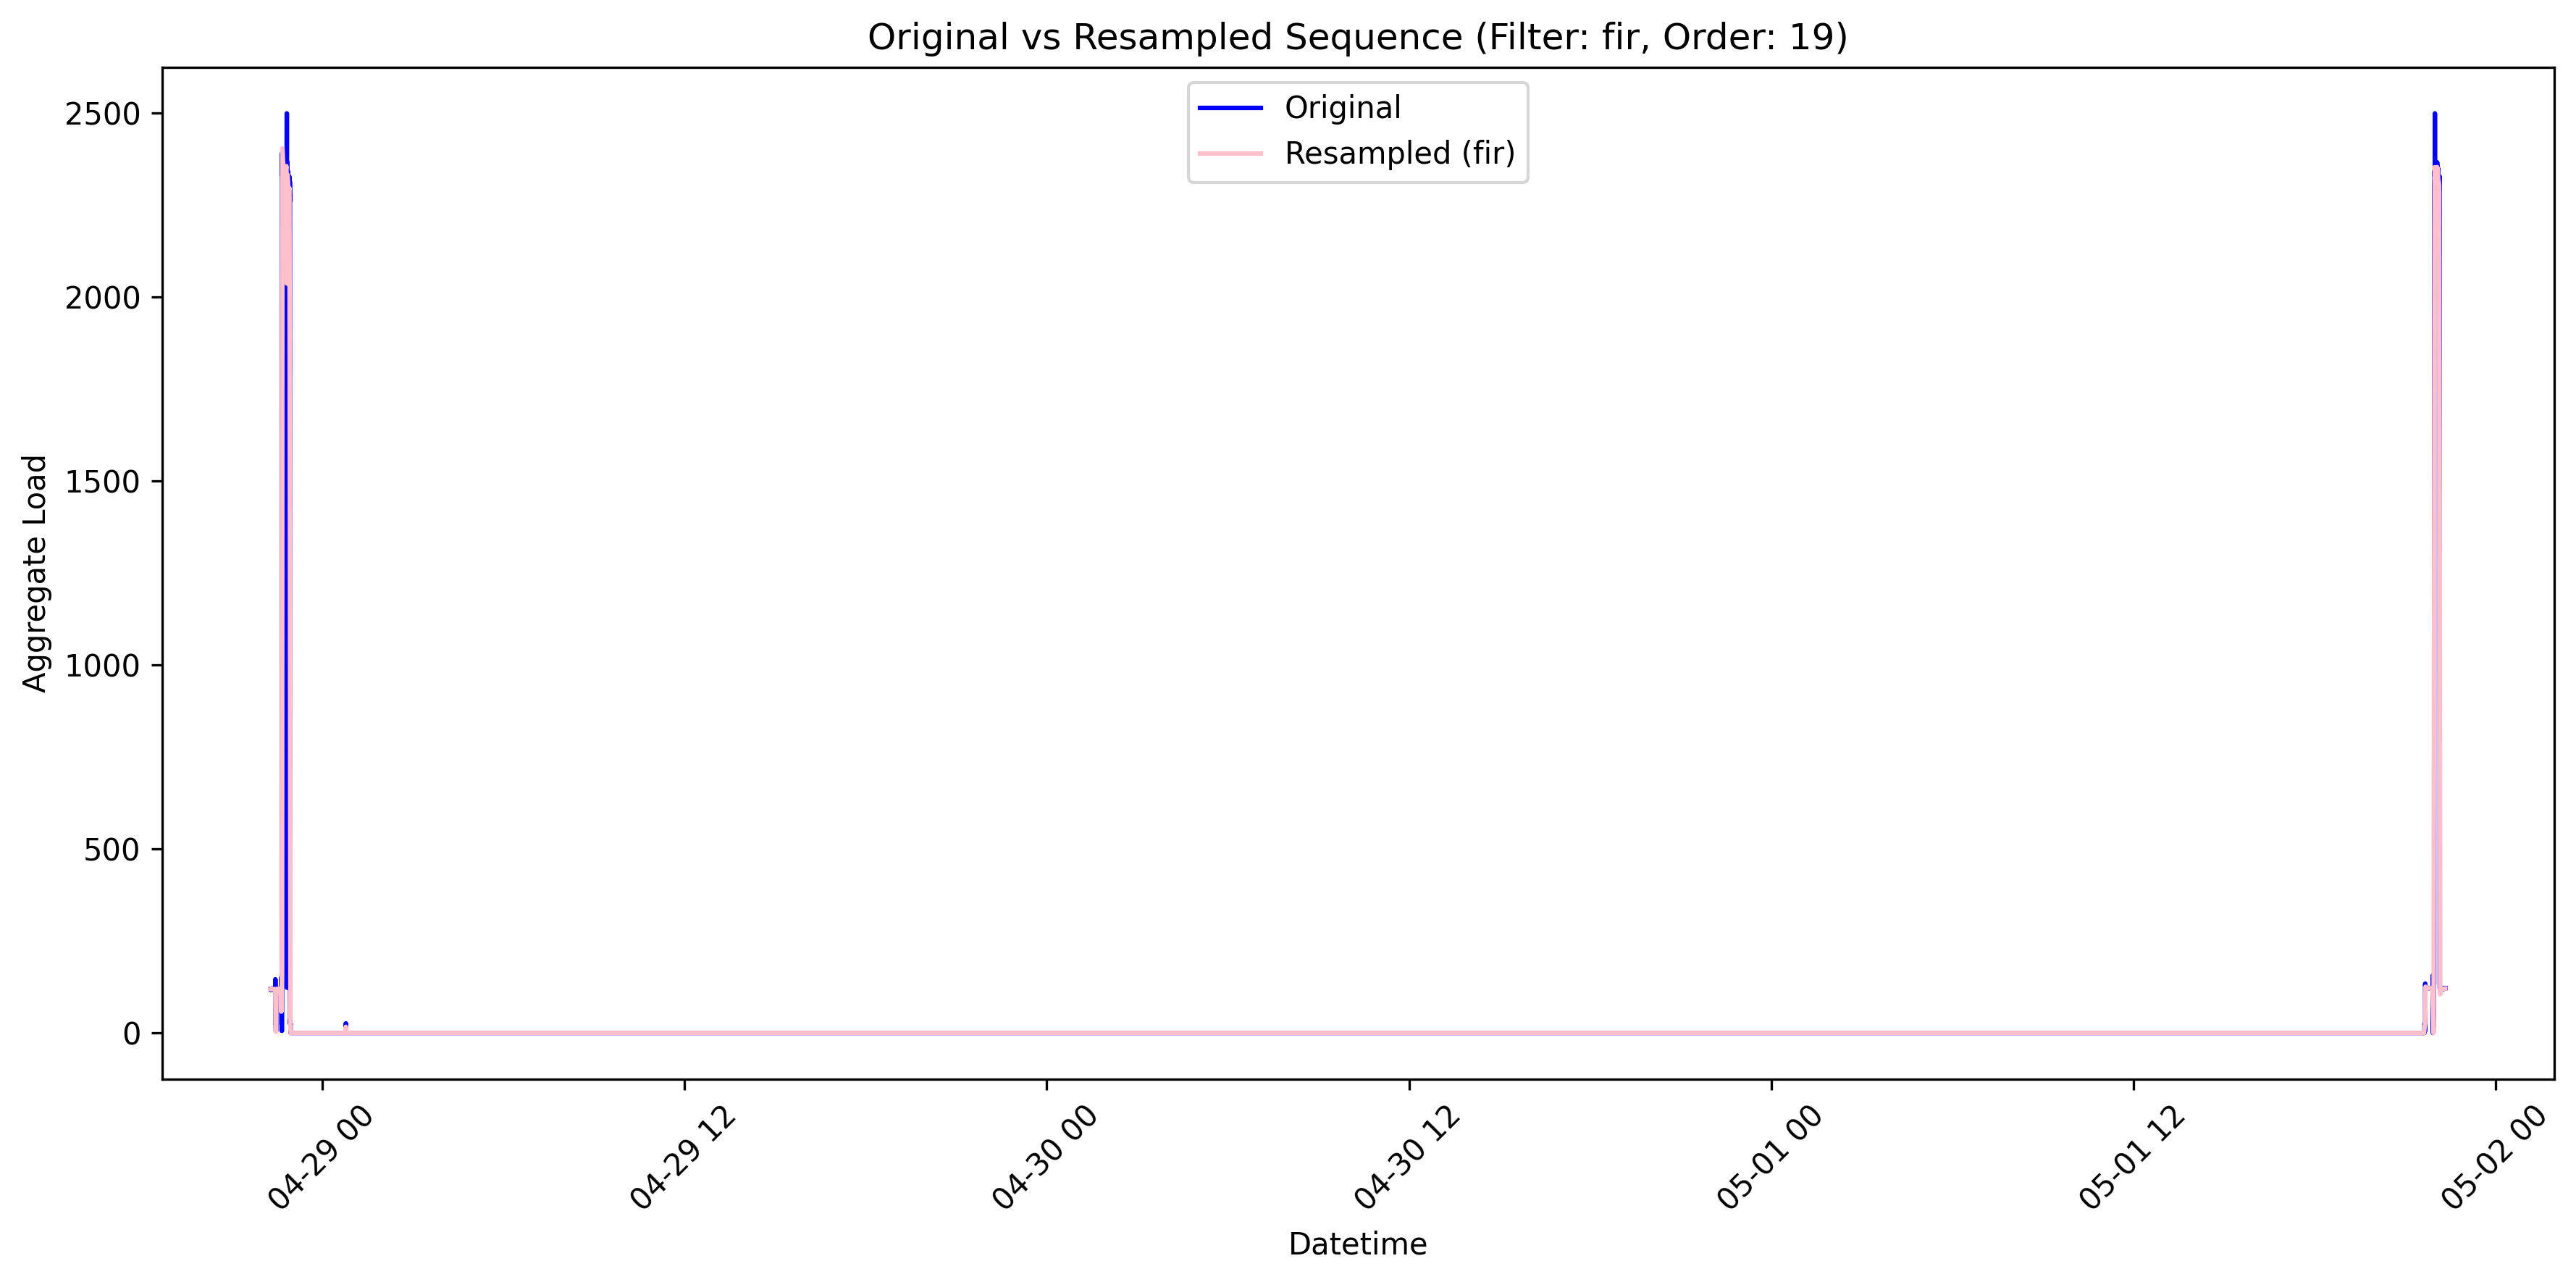

    Original points: 1152
    Downsampled points: 4322
    Compression ratio: 0.3x
    Original time range: 2013-04-28 22:18:06 to 2013-05-01 22:19:46
    Downsampled time range: 2013-04-28 22:18:06 to 2013-05-01 22:19:06


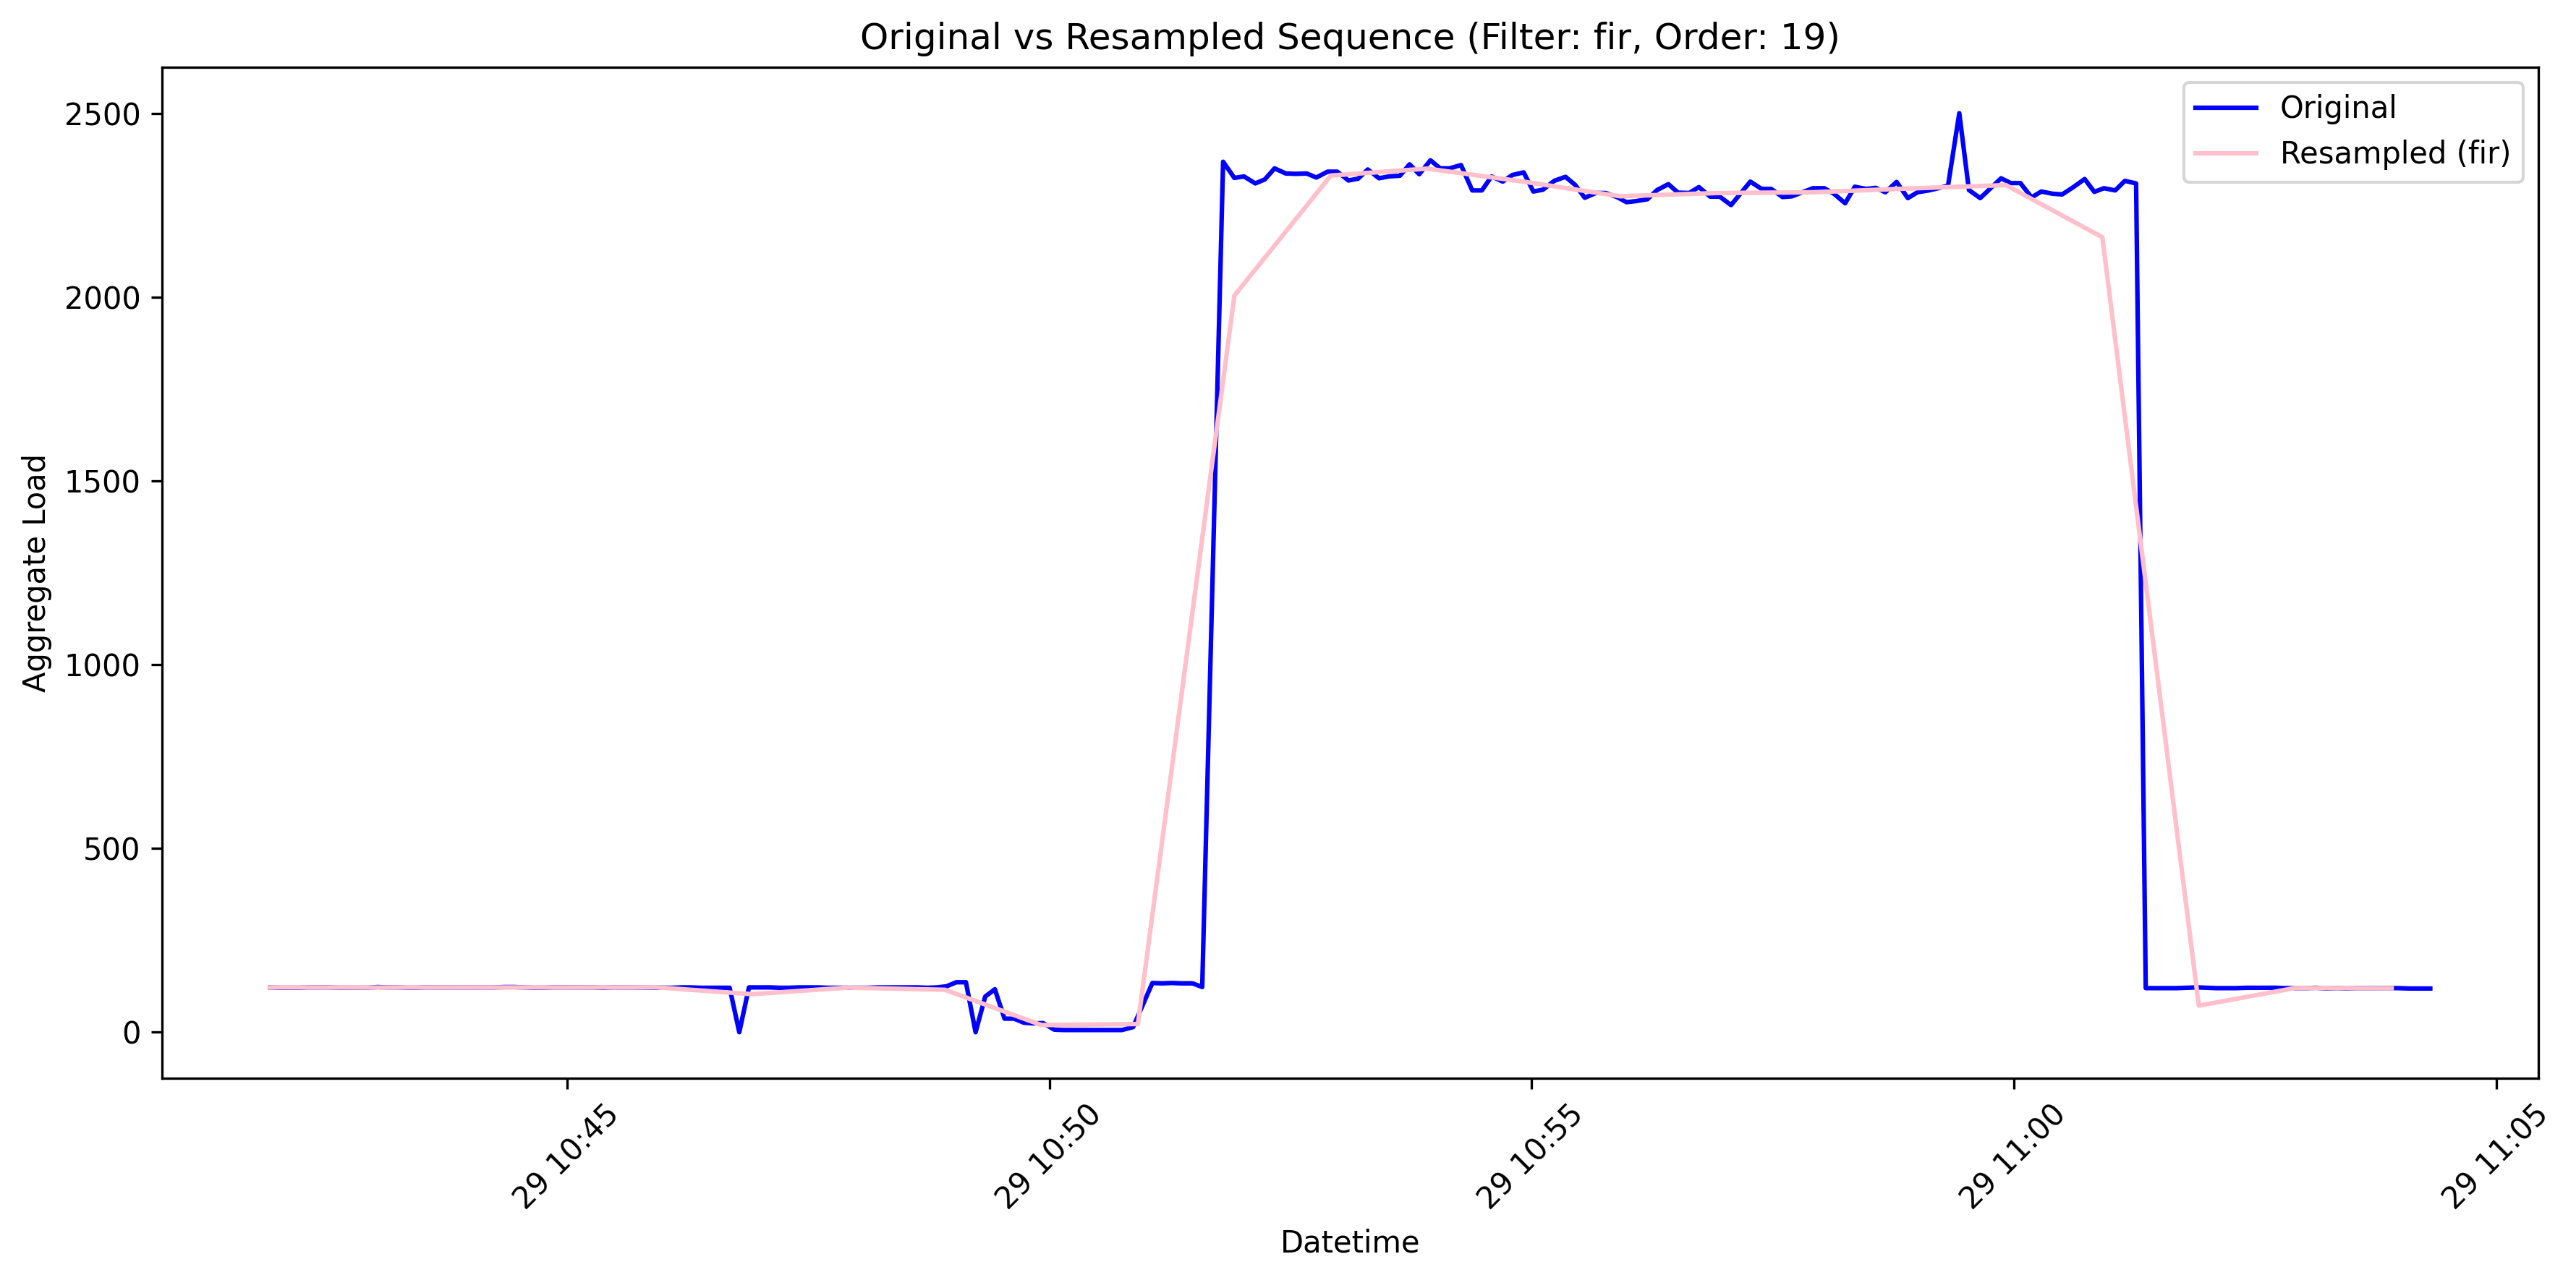

    Original points: 206
    Downsampled points: 23
    Compression ratio: 9.0x
    Original time range: 2013-09-29 10:41:55 to 2013-09-29 11:04:19
    Downsampled time range: 2013-09-29 10:41:55 to 2013-09-29 11:03:55


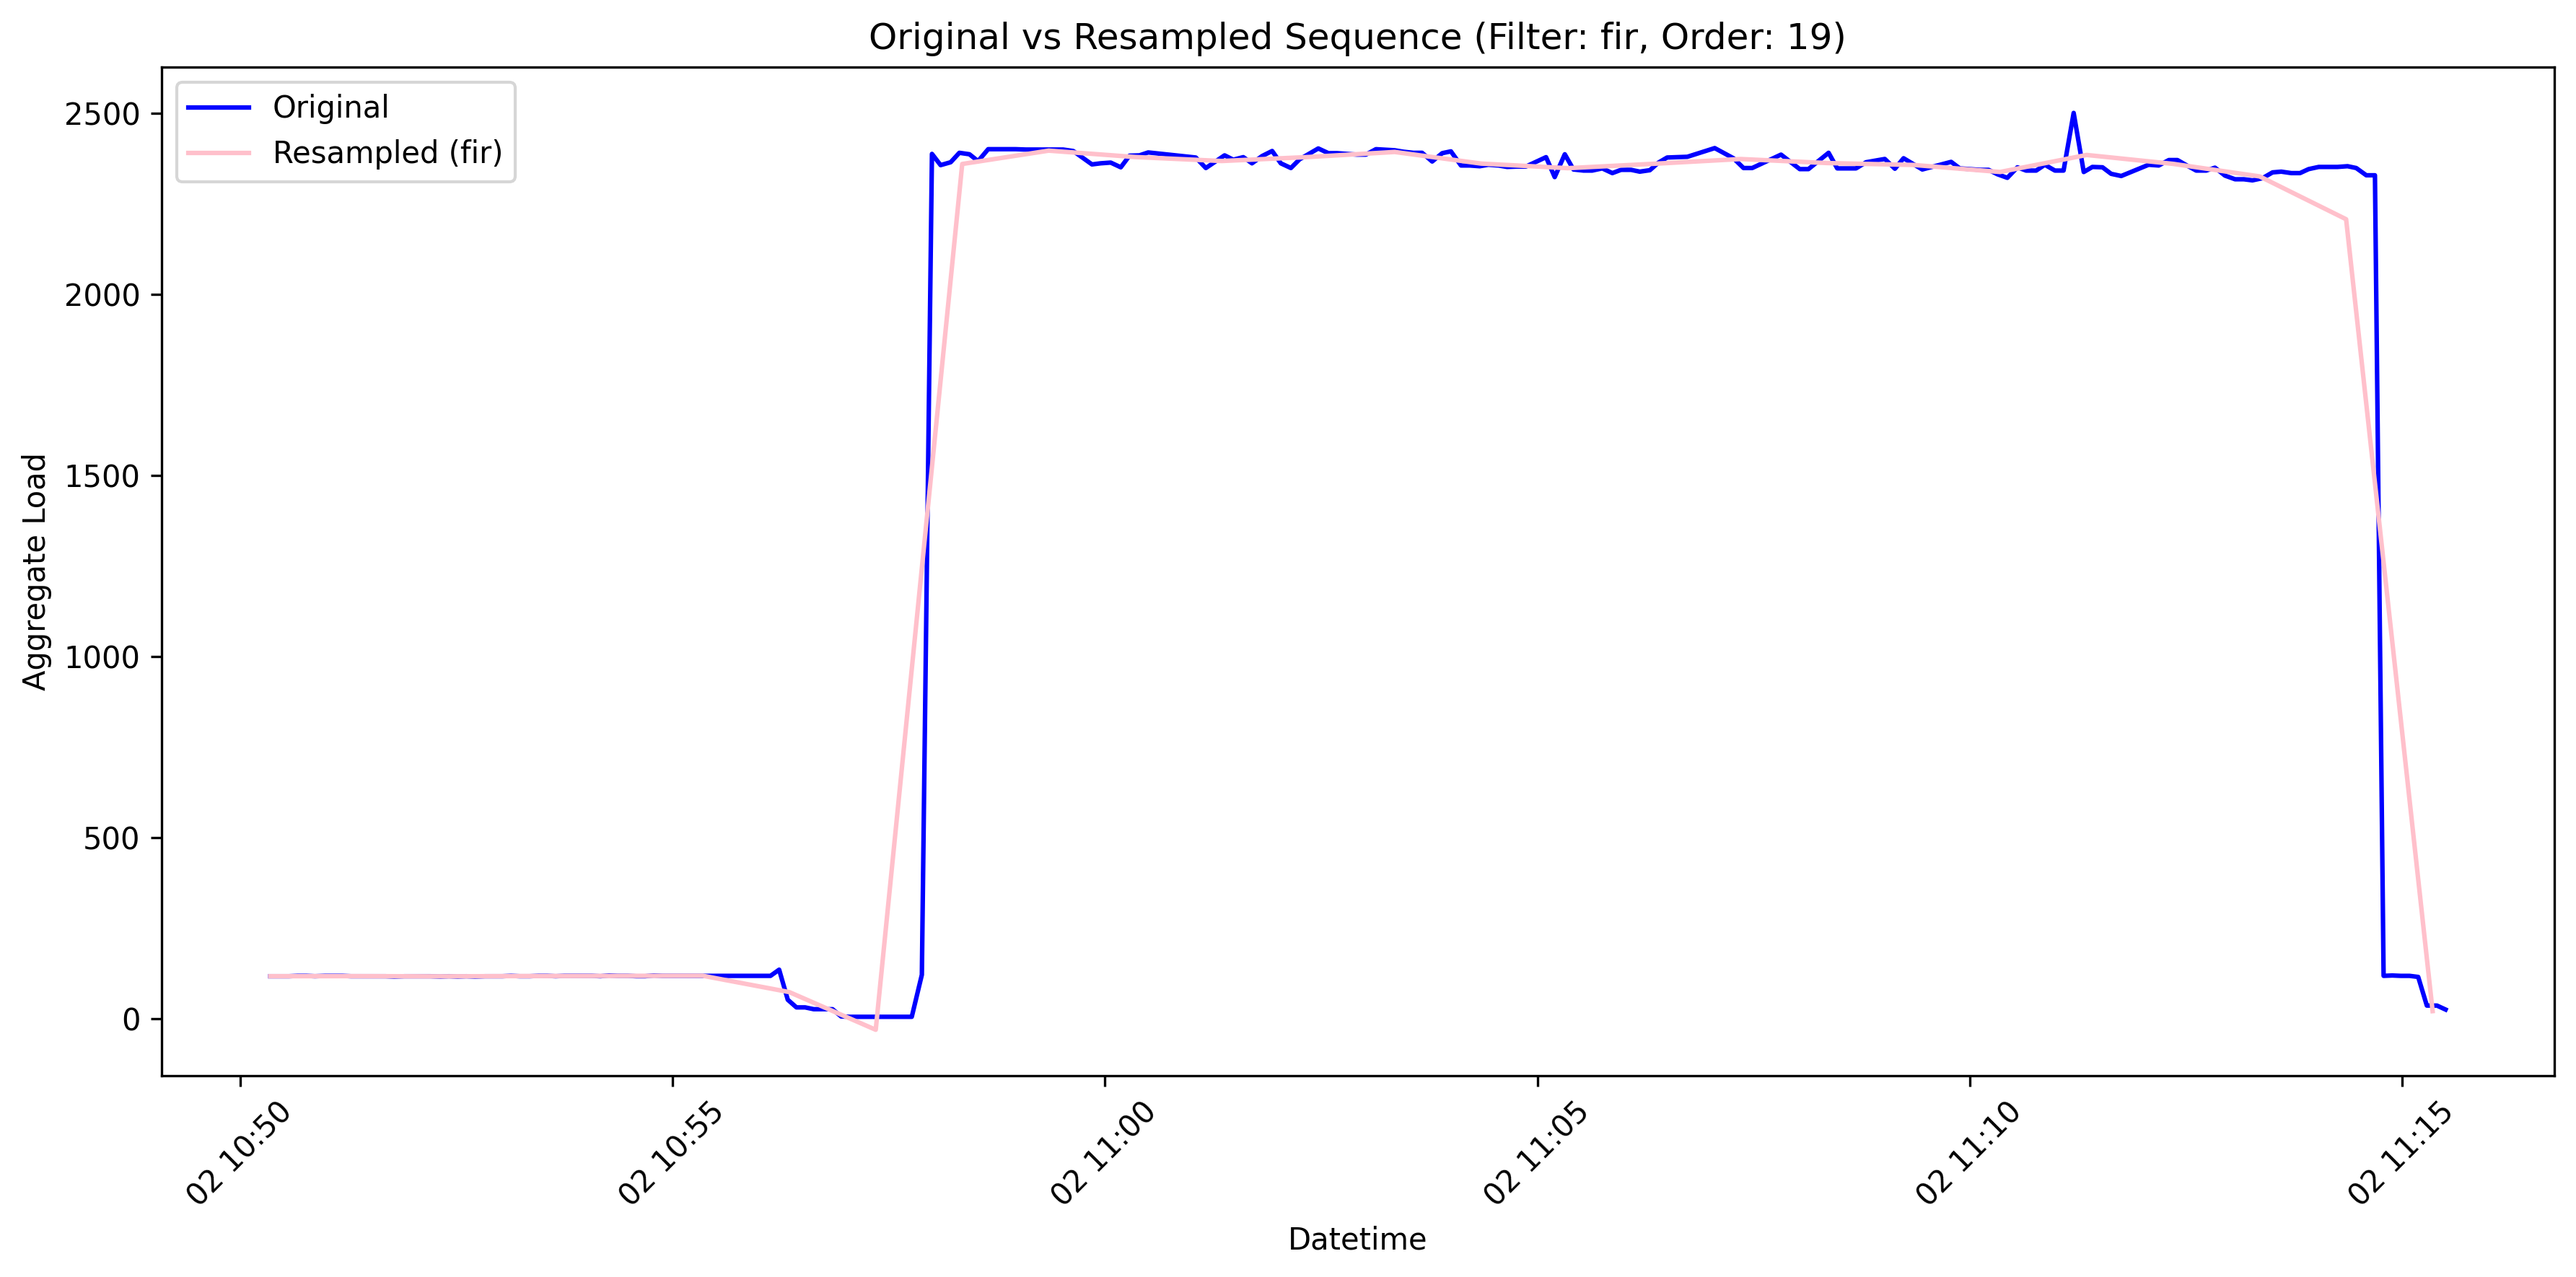

    Original points: 206
    Downsampled points: 26
    Compression ratio: 7.9x
    Original time range: 2013-12-02 10:50:21 to 2013-12-02 11:15:30
    Downsampled time range: 2013-12-02 10:50:21 to 2013-12-02 11:15:21


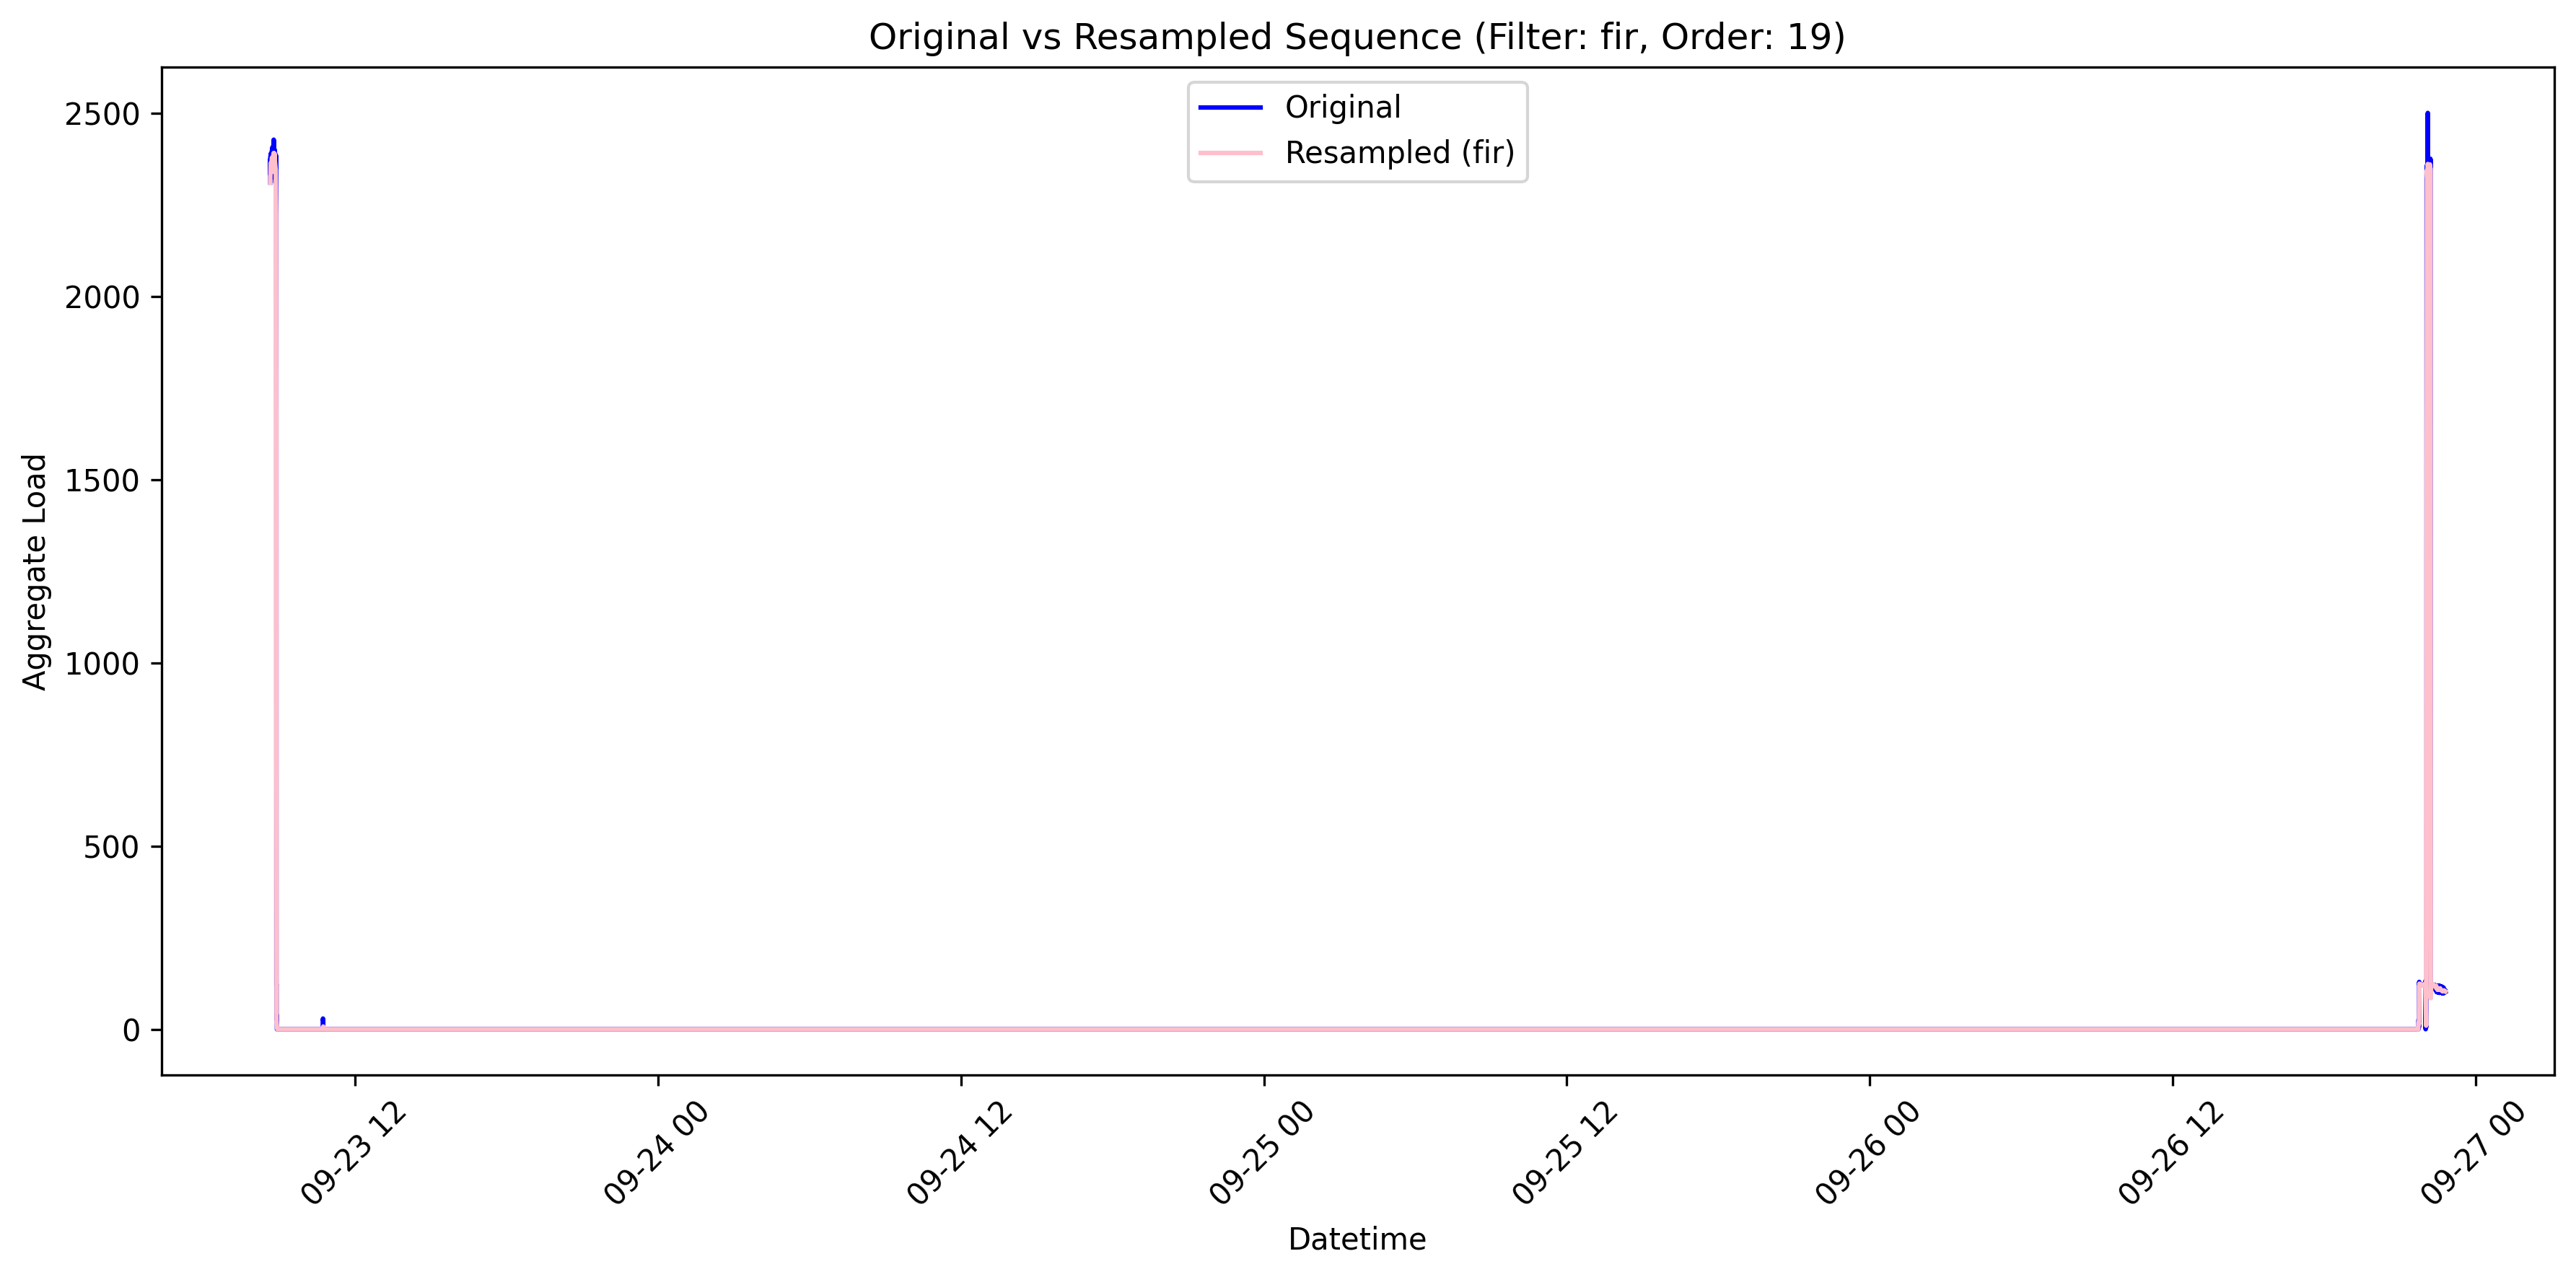

    Original points: 1173
    Downsampled points: 5172
    Compression ratio: 0.2x
    Original time range: 2013-09-23 08:37:46 to 2013-09-26 22:48:59
    Downsampled time range: 2013-09-23 08:37:46 to 2013-09-26 22:48:46


In [42]:
# Visualize appliance signature data comparison
print("=" * 60)
print("VISUALIZING APPLIANCE SIGNATURE DATA COMPARISON")
print("=" * 60)

# Show comparison for selected appliances
for appliance in selected_appliances:
    print(f"\n{appliance.upper()} Signature Comparison:")
    
    # Get train split data for this appliance
    train_orig = []
    train_down = []
    
    # Load original daily sequences for this appliance
    for i in selected_ranges['train'][appliance]:

        start_idx, end_indx = ranges_train[appliance][i]

        # Filter original signatures for this time period
        original_seq = original_signatures['train'][appliance][0]
        original_seq = original_seq[
            (original_seq.index >= start_idx) &
            (original_seq.index <= end_indx)
        ]
        
        downsampled_seq = downsampled_signatures['train'][appliance][i]

        if not original_seq.empty and not downsampled_seq.empty:
            plot_sequences_appliance(appliance,
                original_seq, downsampled_seq, filter_type, filter_order
            )
            
            # Print some stats
            print(f"    Original points: {len(original_seq)}")
            print(f"    Downsampled points: {len(downsampled_seq)}")
            if len(original_seq) > 0:
                print(f"    Compression ratio: {len(original_seq)/len(downsampled_seq):.1f}x")
            print(f"    Original time range: {original_seq['datetime'].iloc[0]} to {original_seq['datetime'].iloc[-1]}")
            print(f"    Downsampled time range: {downsampled_seq['datetime'].iloc[0]} to {downsampled_seq['datetime'].iloc[-1]}")
        else:
            print(f"    Skipping empty sequence")

In [43]:
# save the filter settings as a JSON file for later reference
import json

filter_settings = {
    'filter_type': filter_type,
    'filter_order': filter_order,
    'cutoff_hz': cutoff_hz,
    'zero_phase': zero_phase,
    'down_ratio': down_ratio
}

settings_file = output_folder / 'filter_settings.json'
with open(settings_file, 'w') as f:
    json.dump(filter_settings, f, indent=4)

In [44]:
# Save downsampled data following 03_data_split.ipynb patterns
print("=" * 60)
print("SAVING DOWNSAMPLED DATA")
print("=" * 60)

def save_downsampled_aggregate_data(output_folder, daily_segments, downsampled_sequences, split_name):
    """Save downsampled aggregate data for a split"""
    
    # Create split folder
    split_folder = output_folder / 'split'
    split_folder.mkdir(parents=True, exist_ok=True)
    
    # Save segments
    segments_file = split_folder / f'{split_name}_segments.txt'
    with open(segments_file, 'w') as f:
        for start, end in daily_segments:
            f.write(f"{start.isoformat()} - {end.isoformat()}\n")
    
    print(f"  Saved {segments_file}")
    
    # Combine all downsampled sequences into one DataFrame
    combined_df = pd.DataFrame()
    
    for i, (start, end) in enumerate(daily_segments):
        if i < len(downsampled_sequences) and not downsampled_sequences[i].empty:
            seq_df = downsampled_sequences[i].copy()
            combined_df = pd.concat([combined_df, seq_df], ignore_index=True)
    
    # Sort by datetime
    if not combined_df.empty:
        combined_df = combined_df.sort_values('datetime').reset_index(drop=True)
    
    # Save combined DataFrame
    aggregate_file = split_folder / f'{split_name}_aggregate_df.pkl'
    combined_df.to_pickle(aggregate_file)
    
    print(f"  Saved {aggregate_file} ({len(combined_df)} rows)")
    
    return combined_df

def save_downsampled_signatures(output_folder, downsampled_signatures, original_signatures, split_name):
    """Save downsampled signature data for a split"""
    
    # Create signature library folder structure
    sig_lib_folder = output_folder / 'split' / 'load_signature_library' / split_name
    sig_lib_folder.mkdir(parents=True, exist_ok=True)
    
    for appliance in downsampled_signatures[split_name]:
        appliance_folder = sig_lib_folder / appliance
        appliance_folder.mkdir(parents=True, exist_ok=True)
        
        # Combine all downsampled sequences for this appliance
        combined_signatures = pd.DataFrame()
        
        for seq_df in downsampled_signatures[split_name][appliance]:
            if not seq_df.empty:
                combined_signatures = pd.concat([combined_signatures, seq_df], ignore_index=True)
        
        # Sort by datetime
        if not combined_signatures.empty:
            combined_signatures = combined_signatures.sort_values('datetime').reset_index(drop=True)
        
        # Save combined signatures
        signatures_file = appliance_folder / 'load_signatures.pkl'
        combined_signatures.to_pickle(signatures_file)
        
        # Save ranges (copy from original)
        original_sigs, original_ranges = original_signatures[split_name][appliance]
        if original_ranges:
            ranges_file = appliance_folder / 'selected_ranges.txt'
            with open(ranges_file, 'w') as f:
                for start, end in original_ranges:
                    f.write(f"{start},{end}\n")
            print(f"  Saved {ranges_file}")
        
        print(f"  Saved {signatures_file} ({len(combined_signatures)} rows)")

# Save all splits
print("Saving aggregate data...")
train_df = save_downsampled_aggregate_data(output_folder, daily_segments_train, downsampled_train, 'train')
val_df = save_downsampled_aggregate_data(output_folder, daily_segments_val, downsampled_val, 'val')
test_df = save_downsampled_aggregate_data(output_folder, daily_segments_test, downsampled_test, 'test')

print("\nSaving signature data...")
save_downsampled_signatures(output_folder, downsampled_signatures, original_signatures, 'train')
save_downsampled_signatures(output_folder, downsampled_signatures, original_signatures, 'val')
save_downsampled_signatures(output_folder, downsampled_signatures, original_signatures, 'test')

print(f"\nAll data saved to: {output_folder}")
print(f"Directory structure:")
print(f"  {output_folder}/")
print(f"  ├── split/")
print(f"  │   ├── train_segments.txt")
print(f"  │   ├── train_aggregate_df.pkl")
print(f"  │   ├── val_segments.txt")
print(f"  │   ├── val_aggregate_df.pkl")
print(f"  │   ├── test_segments.txt")
print(f"  │   ├── test_aggregate_df.pkl")
print(f"  │   └── load_signature_library/")
print(f"  │       ├── train/")
print(f"  │       ├── val/")
print(f"  │       └── test/")
print(f"  │           └── [appliance_name]/")
print(f"  │               ├── load_signatures.pkl")
print(f"  │               └── selected_ranges.txt")

SAVING DOWNSAMPLED DATA
Saving aggregate data...
  Saved dataset/20250707_downsampled_1min/split/train_segments.txt
  Saved dataset/20250707_downsampled_1min/split/train_aggregate_df.pkl (231551 rows)
  Saved dataset/20250707_downsampled_1min/split/val_segments.txt
  Saved dataset/20250707_downsampled_1min/split/val_aggregate_df.pkl (104177 rows)
  Saved dataset/20250707_downsampled_1min/split/test_segments.txt
  Saved dataset/20250707_downsampled_1min/split/test_aggregate_df.pkl (115200 rows)

Saving signature data...
  Saved dataset/20250707_downsampled_1min/split/load_signature_library/train/dishwasher/selected_ranges.txt
  Saved dataset/20250707_downsampled_1min/split/load_signature_library/train/dishwasher/load_signatures.pkl (14692 rows)
  Saved dataset/20250707_downsampled_1min/split/load_signature_library/train/washing_machine/selected_ranges.txt
  Saved dataset/20250707_downsampled_1min/split/load_signature_library/train/washing_machine/load_signatures.pkl (12456 rows)
  Saved

In [45]:
# Helper functions for loading downsampled data (similar to 03_data_split.ipynb)
def load_downsampled_split_data(output_folder, split_type='train'):
    """
    Load downsampled data for a specific split
    
    Parameters:
    - output_folder: Path to the downsampled dataset folder
    - split_type: 'train', 'val', or 'test'
    
    Returns:
    - segments: List of (start_datetime, end_datetime) tuples
    - dataframe: Downsampled aggregate dataframe for the split
    """
    split_folder = output_folder / 'split'
    
    # Load segments
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    # Load dataframe
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    
    return segments, df

def load_downsampled_signatures(output_folder, split_type, appliance):
    """Load downsampled appliance signatures"""
    sig_path = output_folder / 'split' / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = output_folder / 'split' / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

# Test helper functions
print("=" * 60)
print("TESTING HELPER FUNCTIONS")
print("=" * 60)

# Test loading downsampled data
test_train_segments, test_train_df = load_downsampled_split_data(output_folder, 'train')
test_val_segments, test_val_df = load_downsampled_split_data(output_folder, 'val')
test_test_segments, test_test_df = load_downsampled_split_data(output_folder, 'test')

print(f"Loaded downsampled data:")
print(f"  Train: {len(test_train_segments)} segments, {len(test_train_df)} data points")
print(f"  Val: {len(test_val_segments)} segments, {len(test_val_df)} data points")
print(f"  Test: {len(test_test_segments)} segments, {len(test_test_df)} data points")

# Test loading signatures
available_sample_appliances = [d.name for d in (output_folder / 'split' / 'load_signature_library' / 'train').iterdir() if d.is_dir()]

if available_sample_appliances:
    sample_app = available_sample_appliances[0]
    test_sigs, test_ranges = load_downsampled_signatures(output_folder, 'train', sample_app)
    print(f"\nLoaded {sample_app} signatures: {len(test_sigs)} signatures, {len(test_ranges)} ranges")

# Summary statistics
print("\n" + "=" * 60)
print("DOWNSAMPLING SUMMARY")
print("=" * 60)

print(f"Output folder: {output_folder}")
print(f"Downsampling parameters:")
print(f"  - Filter type: {filter_type}")
print(f"  - Filter order: {filter_order}")
print(f"  - Downsampling ratio: {down_ratio}x")
print(f"  - Original frequency: 1/6 Hz (~6s intervals)")
print(f"  - Downsampled frequency: 1/60 Hz (1min intervals)")

print(f"\nData reduction:")
for split_name, df in [('train', test_train_df), ('val', test_val_df), ('test', test_test_df)]:
    if split_name == 'train':
        original_count = len(aggregate_load_df_train)
    elif split_name == 'val':
        original_count = len(aggregate_load_df_val)
    else:
        original_count = len(aggregate_load_df_test)
    
    downsampled_count = len(df)
    reduction_factor = original_count / downsampled_count if downsampled_count > 0 else 0
    
    print(f"  {split_name.upper()}: {original_count:,} → {downsampled_count:,} points ({reduction_factor:.1f}x reduction)")

print(f"\nProcessed appliances: {len(appliances)}")
for appliance in appliances:
    train_count = len(downsampled_signatures['train'][appliance])
    val_count = len(downsampled_signatures['val'][appliance])
    test_count = len(downsampled_signatures['test'][appliance])
    total_count = train_count + val_count + test_count
    print(f"  {appliance}: {total_count} daily sequences ({train_count} train, {val_count} val, {test_count} test)")

print(f"\n✅ Downsampling pipeline completed successfully!")
print(f"Ready for next steps in the processing pipeline.")

TESTING HELPER FUNCTIONS
Loaded downsampled data:
  Train: 162 segments, 231551 data points
  Val: 73 segments, 104177 data points
  Test: 80 segments, 115200 data points

Loaded dishwasher signatures: 14692 signatures, 7 ranges

DOWNSAMPLING SUMMARY
Output folder: dataset/20250707_downsampled_1min
Downsampling parameters:
  - Filter type: fir
  - Filter order: 19
  - Downsampling ratio: 10x
  - Original frequency: 1/6 Hz (~6s intervals)
  - Downsampled frequency: 1/60 Hz (1min intervals)

Data reduction:
  TRAIN: 2,231,641 → 231,551 points (9.6x reduction)
  VAL: 998,693 → 104,177 points (9.6x reduction)
  TEST: 1,100,593 → 115,200 points (9.6x reduction)

Processed appliances: 4
  microwave: 67 daily sequences (29 train, 19 val, 19 test)
  kettle: 79 daily sequences (42 train, 14 val, 23 test)
  washing_machine: 28 daily sequences (15 train, 6 val, 7 test)
  dishwasher: 11 daily sequences (7 train, 1 val, 3 test)

✅ Downsampling pipeline completed successfully!
Ready for next steps i